# NLP Final Project

In [38]:
# !pip install numpy pandas scikit-learn matplotlib torch transformers peft safetensors accelerate autotime

# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable execute_time/ExecuteTime

# !pip install tabpfn
# !pip install tabpfn-client

# !pip install torch transformers scikit-learn pandas matplotlib peft sentencepiece datasets

In [1]:
# auto‑reload after editting any of the .py files
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import requests
import gzip
import shutil
import importlib

# import higgs_eda as he

from baseline_pipeline import run_baseline_experiment
import baseline_pipeline_sets
importlib.reload(baseline_pipeline_sets)
from baseline_pipeline_sets import run_baseline_experiment_sets

import tabpfn_client
import tabpfn_pipeline
importlib.reload(tabpfn_pipeline)
from tabpfn_pipeline import run_tabpfn_experiment
import tabpfn_pipeline_sets
importlib.reload(tabpfn_pipeline_sets)
from tabpfn_pipeline_sets import run_tabpfn_experiment_sets

import transformer as tf
import t5_small_pipeline
importlib.reload(t5_small_pipeline)
from t5_small_pipeline import run_t5_experiment
import llama2_pipeline
importlib.reload(llama2_pipeline)
from llama2_pipeline import run_llama2_experiment
import t5_enc_pipeline
importlib.reload(t5_enc_pipeline)
from t5_enc_pipeline import run_t5_enc_experiment
import t5_enc_pipeline_sets_optim
importlib.reload(t5_enc_pipeline_sets_optim)
from t5_enc_pipeline_sets_optim import run_t5_enc_experiment_sets
import t5_fused_pipeline_sets
importlib.reload(t5_fused_pipeline_sets)
from t5_fused_pipeline_sets import run_t5_fused_experiment_sets

In [2]:
print(os.getcwd())

/home/ubuntu/oron/nlp


# Data Preprocessing

### Higgs EDA

In [ ]:
# 1. Visual inspection
he.plot_feature_violins(df, label_col='label')

# 2. Statistics
stats_df = he.compute_feature_stats(df, label_col='label')
display(stats_df.sort_values('cohens_d', ascending=False))

# 3. Binning suggestions → also written to binning_suggestions.txt
bins = he.suggest_feature_binning(
    df,
    label_col='label',
    stats_df=stats_df,          # pass pre-computed metrics
    output_txt='binning_suggestions.txt'
)

print(bins['dijet_invariant_mass'])

In [174]:
stats_df = he.compute_feature_stats(df, label_col='label')
bins = he.suggest_feature_binning(
    df,
    label_col='label',
    stats_df=stats_df,          # reuse metrics
    max_bins=5,                 # cap
    output_txt='binning_suggestions.txt'
)

print(bins['bjet_pair_invariant_mass'])

Binning suggestions written to binning_suggestions.txt
{'bin_edges': [0.04786214604973793, 0.6738168001174927, 0.8733797669410706, 1.1384387016296387, 17.76285171508789], 'bin_names': ['very_low_bjet_pair_invariant_mass', 'low_bjet_pair_invariant_mass', 'high_bjet_pair_invariant_mass', 'very_high_bjet_pair_invariant_mass']}


In [177]:
stats_df = he.compute_feature_stats(df, label_col='label')

# Unified ranking (effect size + p-value)
feature_order = he.rank_features(stats_df, metric="aggregate")
print("Most separable → least:", feature_order)          # top-10

# Still possible to rank by a single metric
feature_by_d = he.rank_features(stats_df, metric="cohens_d")

Most separable → least: ['bjet_pair_invariant_mass', 'wboson_bjet_pair_plus_jet_mass', 'missing_transverse_energy', 'wboson_bjet_pair_mass', 'leading_jet_transverse_momentum', 'subleading_jet_b_tag', 'lepton_transverse_momentum', 'fourth_jet_transverse_momentum', 'dijet_lepton_missing_energy_mass', 'trijet_invariant_mass', 'third_jet_b_tag', 'subleading_jet_transverse_momentum', 'fourth_jet_b_tag', 'third_jet_transverse_momentum', 'dijet_invariant_mass', 'lepton_missing_energy_mass', 'leading_jet_b_tag', 'fourth_jet_pseudorapidity', 'third_jet_pseudorapidity', 'subleading_jet_pseudorapidity', 'lepton_pseudorapidity', 'subleading_jet_azimuthal_angle', 'lepton_azimuthal_angle', 'missing_energy_azimuthal_angle', 'leading_jet_azimuthal_angle', 'fourth_jet_azimuthal_angle', 'third_jet_azimuthal_angle', 'leading_jet_pseudorapidity']


## Fraud Dataset

In [1]:
# pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

# print("Path to dataset files:", path)

100%|██████████| 532M/532M [00:20<00:00, 27.1MB/s] 

Extracting files...


Path to dataset files: /Users/oront/.cache/kagglehub/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/versions/2


In [ ]:
df = pd.read_csv('bank-account-fraud-dataset-neurips-2022/Variant IV.csv')

# Replace 'HasDetections' with the actual target column name if different
proportions = df["fraud_bool"].value_counts(normalize=True) * 100

print(proportions)

df.rename(columns={'fraud_bool': 'label'}, inplace=True)

df.head()

## Higgs Dataset

### Dataset Dowlonad

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
out_dir = "/Users/oront/PycharmProjects/MSc/NLP/project/data/higgs"
os.makedirs(out_dir, exist_ok=True)
gz_path   = os.path.join(out_dir, "HIGGS.csv.gz")
csv_path  = os.path.join(out_dir, "HIGGS.csv")

# 1) Stream-download the gzip
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(gz_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# 2) Decompress
with gzip.open(gz_path, "rb") as f_in, open(csv_path, "wb") as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f"Downloaded and extracted to {csv_path}")

Downloaded and extracted to /Users/oront/PycharmProjects/MSc/NLP/project/data/higgs/HIGGS.csv


### Raw Dataset loading & preparartion

In [ ]:
# 0) Use if we want to sample while loading
def _skip_row(idx):
    # always keep the header (idx == 0)
    if idx == 0:
        return False
    # skip ~90% of rows at random
    return np.random.rand() > 0.1

# 1) Define column names
cols = [
    "label",
    "lepton_pT", "lepton_eta", "lepton_phi",
    "missing_energy_magnitude", "missing_energy_phi",
    "jet1_pt", "jet1_eta", "jet1_phi", "jet1_btag",
    "jet2_pt", "jet2_eta", "jet2_phi", "jet2_btag",
    "jet3_pt", "jet3_eta", "jet3_phi", "jet3_btag",
    "jet4_pt", "jet4_eta", "jet4_phi", "jet4_btag",
    "m_jj", "m_jjj", "m_lv", "m_jlv",
    "m_bb", "m_wbb", "m_wbbj"
]

# 2) Load the raw CSV (no header)
higgs_df = pd.read_csv("/home/ubuntu/oron/nlp/data/higgs/HIGGS.csv", names=cols)#, skiprows=_skip_row)

# 3) Ensure correct dtypes
higgs_df["label"] = higgs_df["label"].astype(int)
for c in cols[1:]:
    higgs_df[c] = higgs_df[c].astype(float)

# 4) (Optional) Shuffle
higgs_df = higgs_df.sample(frac=1, random_state=42)

print("Rows:", len(higgs_df), "Cols:", len(higgs_df.columns))
print(higgs_df.dtypes.value_counts())
print(higgs_df["label"].value_counts(normalize=True))

# 5) Define original column names (no header in source CSV)
original_columns = cols

# 6) Define semantic rename mapping
rename_map = {
    "label": "label",  # 1 = Higgs event, 0 = background
    "lepton_pT": "lepton_transverse_momentum",
    "lepton_eta": "lepton_pseudorapidity",
    "lepton_phi": "lepton_azimuthal_angle",
    "missing_energy_magnitude": "missing_transverse_energy",
    "missing_energy_phi": "missing_energy_azimuthal_angle",
    "jet1_pt": "leading_jet_transverse_momentum",
    "jet1_eta": "leading_jet_pseudorapidity",
    "jet1_phi": "leading_jet_azimuthal_angle",
    "jet1_btag": "leading_jet_b_tag",
    "jet2_pt": "subleading_jet_transverse_momentum",
    "jet2_eta": "subleading_jet_pseudorapidity",
    "jet2_phi": "subleading_jet_azimuthal_angle",
    "jet2_btag": "subleading_jet_b_tag",
    "jet3_pt": "third_jet_transverse_momentum",
    "jet3_eta": "third_jet_pseudorapidity",
    "jet3_phi": "third_jet_azimuthal_angle",
    "jet3_btag": "third_jet_b_tag",
    "jet4_pt": "fourth_jet_transverse_momentum",
    "jet4_eta": "fourth_jet_pseudorapidity",
    "jet4_phi": "fourth_jet_azimuthal_angle",
    "jet4_btag": "fourth_jet_b_tag",
    "m_jj": "dijet_invariant_mass",
    "m_jjj": "trijet_invariant_mass",
    "m_lv": "lepton_missing_energy_mass",
    "m_jlv": "dijet_lepton_missing_energy_mass",
    "m_bb": "bjet_pair_invariant_mass",
    "m_wbb": "wboson_bjet_pair_mass",
    "m_wbbj": "wboson_bjet_pair_plus_jet_mass"
}

# Rename columns for LLM-friendly semantics
higgs_df = higgs_df.rename(columns=rename_map)

# Convert label to integer
higgs_df["label"] = higgs_df["label"].astype(int)

# # Save the clean, renamed dataset
# df.to_csv(output_path, index=False)
# print(f"Loaded {len(df):,} rows × {len(df.columns):,} cols and saved to {output_path}")

### Load Preprocessed Dataset with Subsamples

In [3]:
higgs_df = pd.read_parquet('/home/ubuntu/oron/nlp/data/higgs/HIGGS_with_splits_nested.parquet')

In [4]:
selected_cols = [
    # List of the 7 high-level features plus the label    
    "label",
    "dijet_invariant_mass",
    "trijet_invariant_mass",
    "lepton_missing_energy_mass",
    "dijet_lepton_missing_energy_mass",
    "bjet_pair_invariant_mass",
    "wboson_bjet_pair_mass",
    "wboson_bjet_pair_plus_jet_mass",

    # Categorical features (b-tagging information)
    "leading_jet_b_tag",      # jet1_btag - 3 unique values
    "subleading_jet_b_tag",   # jet2_btag - 3 unique values  
    "third_jet_b_tag",        # jet3_btag - 3 unique values
    "fourth_jet_b_tag",        # jet4_btag - 3 unique values

    # Transverse momentum features
    "missing_transverse_energy",
    "leading_jet_transverse_momentum",
    "lepton_transverse_momentum",
    "fourth_jet_transverse_momentum",
    "subleading_jet_transverse_momentum",

    # Markers
    "test",
    "validation",
    "train_50",
    "train_100",
    "train_200",
    "train_500",
    "train_1K",
    "train_5K",
    "train_10K",
    "train_50K",
    "train_100K",
    "train_500K",
    "train_1M",
    "train_5M",
]

# Assume `df` is your existing DataFrame
higgs_top_ft = higgs_df[selected_cols].copy()
#higgs_top_ft.rename(columns={'label': 'is_higgs_event'}, inplace=True)

# Add explicit dummy feature for sanity check
# higgs_top_ft['higgs_indication'] = higgs_top_ft['is_higgs_event'].apply(lambda x: 'Higgs' if x == 1 else 'Not Higgs')

# Show the resulting DataFrame shape and columns
print(f"higgs_top_ft shape: {higgs_top_ft.shape}")
print("Columns in higgs_top_ft:", higgs_top_ft.columns.tolist())

higgs_top_ft shape: (11000000, 31)
Columns in higgs_top_ft: ['label', 'dijet_invariant_mass', 'trijet_invariant_mass', 'lepton_missing_energy_mass', 'dijet_lepton_missing_energy_mass', 'bjet_pair_invariant_mass', 'wboson_bjet_pair_mass', 'wboson_bjet_pair_plus_jet_mass', 'leading_jet_b_tag', 'subleading_jet_b_tag', 'third_jet_b_tag', 'fourth_jet_b_tag', 'missing_transverse_energy', 'leading_jet_transverse_momentum', 'lepton_transverse_momentum', 'fourth_jet_transverse_momentum', 'subleading_jet_transverse_momentum', 'test', 'validation', 'train_50', 'train_100', 'train_200', 'train_500', 'train_1K', 'train_5K', 'train_10K', 'train_50K', 'train_100K', 'train_500K', 'train_1M', 'train_5M']


In [14]:
# 1) Semantic bins
# df_bins = tf.custom_bins_transformer(higgs_top_ft, label_col='is_higgs_event')

# 2) Decile bins
higgs_deciles = tf.percentile_bins_transformer(higgs_top_ft, n_bins=10, label_col='label')

# 3) Multiply numeric values by 100 then round to 1 decimal place
higgs_scaled = tf.numeric_transformer(higgs_top_ft, numeric_factor_val=1000, numeric_round_digits=0, label_col='label')

# 4) Z-score + round to 2 decimals
higgs_z_score = tf.z_score_transformer(higgs_top_ft, numeric_factor_val=1000, numeric_round_digits=0, label_col='label')

In [15]:
higgs_deciles.head()

label dijet_invariant_mass trijet_invariant_mass  \
3967303      0         tenth_decile          tenth_decile   
5946179      1        eighth_decile          first_decile   
6910558      0         third_decile          fifth_decile   
3414332      0         first_decile          third_decile   
5840458      1         tenth_decile          ninth_decile   

        lepton_missing_energy_mass dijet_lepton_missing_energy_mass  \
3967303               first_decile                     third_decile   
5946179               first_decile                     tenth_decile   
6910558               fifth_decile                    fourth_decile   
3414332               sixth_decile                     fifth_decile   
5840458               tenth_decile                    eighth_decile   

        bjet_pair_invariant_mass wboson_bjet_pair_mass  \
3967303             tenth_decile          tenth_decile   
5946179            second_decile          ninth_decile   
6910558             first_decile         second_decile   
3414332            second_decile          first_decile   
5840458             sixth_decile         eighth_decile   

        wboson_bjet_pair_plus_jet_mass leading_jet_b_tag subleading_jet_b_tag  \
3967303                   ninth_decile      first_decile         first_decile   
5946179                   tenth_decile      first_decile         first_decile   
6910558                  second_decile      first_decile         first_decile   
3414332                   sixth_decile     second_decile         first_decile   
5840458                 seventh_decile      first_decile         first_decile   

         ... train_200 train_500 train_1K train_5K train_10K train_50K  \
3967303  ...     False     False    False    False     False     False   
5946179  ...     False     False    False    False     False     False   
6910558  ...     False     False    False    False     False     False   
3414332  ...     False     False    False    False     False     False   
5840458  ...     False     False    False    False     False     False   

        train_100K  train_500K  train_1M  train_5M  
3967303      False       False     False      True  
5946179      False       False     False      True  
6910558      False       False      True      True  
3414332      False       False     False      True  
5840458      False       False     False      True  

[5 rows x 31 columns]

In [9]:
len(higgs_scaled)

11000000

## Flights Dataset

### Prepare Dataset

In [3]:
# 1. Load & initial filter
df = pd.read_csv('data/flights/flights.csv', low_memory=False)
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)].copy()

# 2. Derive binary label, then drop the source
df['label'] = (df['ARRIVAL_DELAY'] > 15).astype(int)
df.drop(columns=['ARRIVAL_DELAY'], inplace=True)

# 3. Drop truly “leaky” columns (post‑arrival info)
to_drop = [
    'YEAR', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
    'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'

    # never-known-at-prediction
    'DEPARTURE_TIME','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
    'ELAPSED_TIME','AIR_TIME','WHEELS_ON','TAXI_IN', 'ARRIVAL_TIME',
]
df.drop(columns=to_drop, errors='ignore', inplace=True)

# 4. Rename for clarity
df.rename(columns={
    'OP_CARRIER': 'AIRLINE',
    'ORIGIN':     'ORIGIN_AIRPORT',
    'DEST':       'DESTINATION_AIRPORT',
}, inplace=True)

# 5. Engineer date/time buckets
df['month']       = df['MONTH'].astype('int8')
df['day_of_week'] = df['DAY_OF_WEEK'].astype('int8')

df['sched_departure_hour']   = (df['SCHEDULED_DEPARTURE'] // 100).astype('int8')
df['sched_departure_minute'] = (df['SCHEDULED_DEPARTURE'] % 100).astype('int8')
df['sched_arrival_hour']   = (df['SCHEDULED_ARRIVAL']   // 100).astype('int8')
df['sched_arrival_minute'] = (df['SCHEDULED_ARRIVAL']   % 100).astype('int8')

# (optionally) drop the raw fields you’ve just split
df.drop(columns=[
    'MONTH','DAY_OF_WEEK',
    'SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL'
], inplace=True, errors='ignore')

# 6. Build numeric vs. categorical lists **dynamically**
all_feats = df.columns.drop('label')
num_features = df[all_feats].select_dtypes(include=['number']).columns.tolist()
cat_features = df[all_feats].select_dtypes(exclude=['number']).columns.tolist()

print(f"Keeping {len(num_features)} numeric + {len(cat_features)} categorical features\n")

# 7. Fill missing per type
df[num_features] = df[num_features].fillna(0)
for c in cat_features:
    df[c] = df[c].astype(object).fillna('Missing').astype(str)

# 8. (Optional) cast cats to pandas.Categorical for memory savings
for c in cat_features:
    df[c] = df[c].astype('category')

# 9. Final check
print("Final shape:", df.shape)
print("Numeric:", num_features)
print("Categorical:", cat_features)
print("\nSample dtypes:\n", df.dtypes.head(10))

Keeping 12 numeric + 4 categorical features

Final shape: (5714008, 17)
Numeric: ['DAY', 'FLIGHT_NUMBER', 'DEPARTURE_TIME', 'SCHEDULED_TIME', 'DISTANCE', 'WEATHER_DELAY', 'month', 'day_of_week', 'sched_departure_hour', 'sched_departure_minute', 'sched_arrival_hour', 'sched_arrival_minute']
Categorical: ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

Sample dtypes:
 DAY                       int64
AIRLINE                category
FLIGHT_NUMBER             int64
TAIL_NUMBER            category
ORIGIN_AIRPORT         category
DESTINATION_AIRPORT    category
DEPARTURE_TIME          float64
SCHEDULED_TIME          float64
DISTANCE                  int64
WEATHER_DELAY           float64
dtype: object


### Load Preprocessed Dataset with Subsamples

In [5]:
flights_post_arrival = pd.read_parquet('/home/ubuntu/oron/nlp/data/flights/flights_with_splits_nested.parquet').drop(columns=[
    # Irrelevnt cancellation feature
    'DIVERTED',
    'CANCELLED',
    'CANCELLATION_REASON'
], inplace=False)

In [6]:
flights_post_departure = flights_post_arrival.drop(columns=[
    'ELAPSED_TIME',
    'AIR_TIME',
    'WHEELS_ON',
    'TAXI_IN',
    'ARRIVAL_TIME',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
], inplace=False)

In [7]:
flights_pre_departure = flights_post_arrival.drop(columns=[
    # Post-departure features
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'TAXI_OUT',
    'WHEELS_OFF',
    # In-flight / arrival features
    'ELAPSED_TIME',
    'AIR_TIME',
    'WHEELS_ON',
    'TAXI_IN',
    'ARRIVAL_TIME',
    # Delay-reason breakdown (post-flight analysis)
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
], inplace=False)

In [8]:
flights_post_departure.columns

Index(['DAY', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE', 'label', 'month',
       'day_of_week', 'scheduled_departure_hour', 'scheduled_departure_minute',
       'scheduled_arrival_hour', 'scheduled_arrival_minute', 'test',
       'validation', 'train_5M', 'train_1M', 'train_500K', 'train_100K',
       'train_50K', 'train_10K', 'train_5K', 'train_1K', 'train_500',
       'train_200', 'train_100', 'train_50'],
      dtype='object')

# Higgs Models Training & Inference

## CatBoost Baseline

Learning Curves (ratio=0.0001, train=792, val=198)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=0.0001, train=792, val=198, test=1100000):
  accuracy=0.6630, precision=0.6698, recall=0.7181, f1=0.6931, auc=0.7217
Learning Curves (ratio=0.001, train=7,920, val=1,980)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=0.001, train=7920, val=1980, test=1100000):
  accuracy=0.7094, precision=0.7203, recall=0.7383, f1=0.7292, auc=0.7838
Learning Curves (ratio=0.01, train=79,200, val=19,800)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=0.01, train=79200, val=19800, test=1100000):
  accuracy=0.7339, precision=0.7429, recall=0.7614, f1=0.7520, auc=0.8138


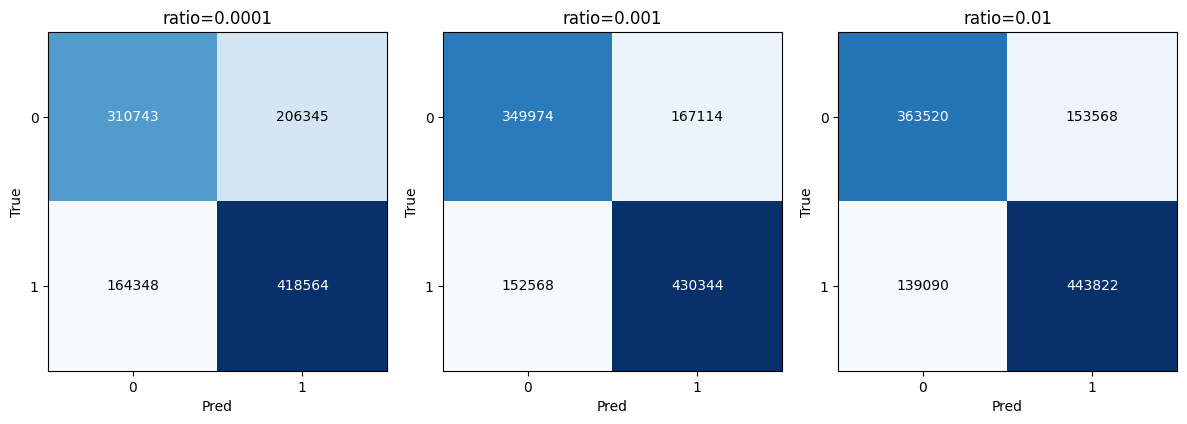

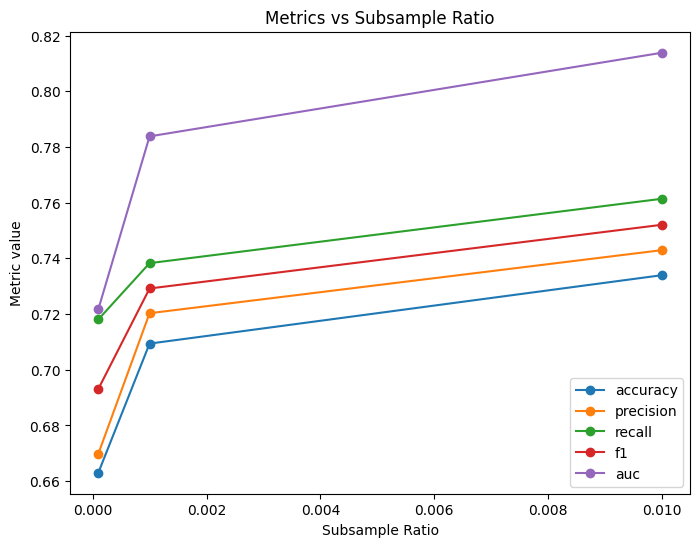

In [15]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_df,
    label_col="label",
    test_size=0.1,
    subsample_ratios=[0.0001, 0.001, 0.01],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

### Static Sets

#### ALL features raw

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.5715, precision=0.5625, recall=0.6432, f1=0.6002, auc=0.5990
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5923, precision=0.5787, recall=0.6788, f1=0.6248, auc=0.6236
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.6208, precision=0.6065, recall=0.6878, f1=0.6446, auc=0.6599
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.6297, precision=0.6174, recall=0.6820, f1=0.6481, auc=0.6862
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.6616, precision=0.6494, recall=0.7024, f1=0.6749, auc=0.7216
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.7007, precision=0.7007, recall=0.7006, f1=0.7007, auc=0.7740
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.7133, precision=0.7140, recall=0.7116, f1=0.7128, auc=0.7914
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.7312, precision=0.7336, recall=0.7260, f1=0.7298, auc=0.8127
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.7358, precision=0.7368, recall=0.7336, f1=0.7352, auc=0.8177
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.7399, precision=0.7414, recall=0.7368, f1=0.7391, auc=0.8242
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.7409, precision=0.7438, recall=0.7350, f1=0.7394, auc=0.8252


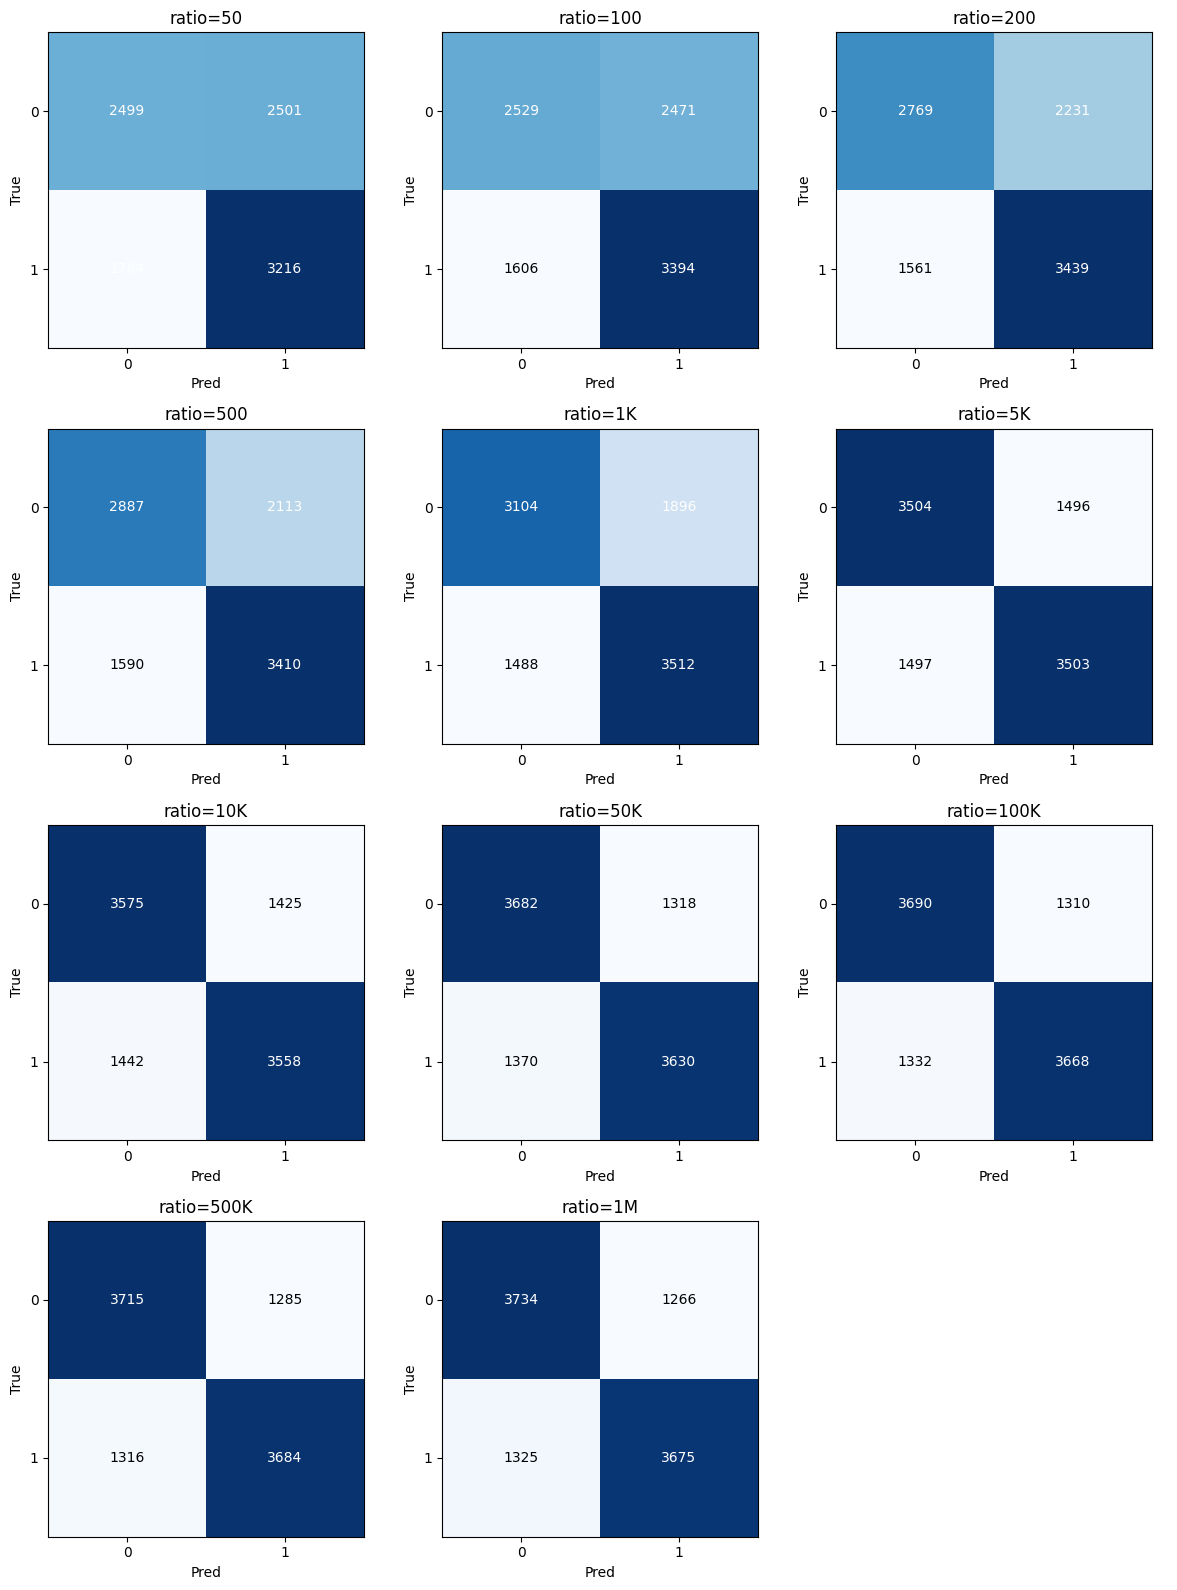

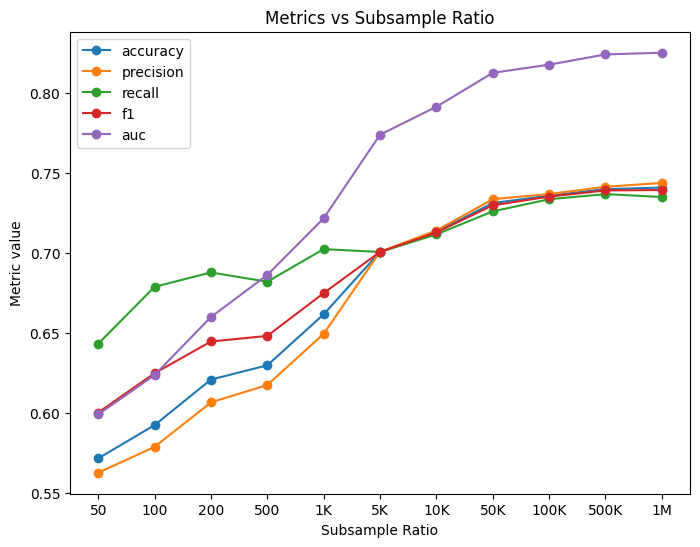


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.5715  0.5923  0.6208  0.6297  0.6616  0.7007  0.7133  0.7312  0.7358  0.7399  0.7409
precision  0.5625  0.5787  0.6065  0.6174  0.6494  0.7007  0.7140  0.7336  0.7368  0.7414  0.7438
recall     0.6432  0.6788  0.6878  0.6820  0.7024  0.7006  0.7116  0.7260  0.7336  0.7368  0.7350
f1         0.6002  0.6248  0.6446  0.6481  0.6749  0.7007  0.7128  0.7298  0.7352  0.7391  0.7394
auc        0.5990  0.6236  0.6599  0.6862  0.7216  0.7740  0.7914  0.8127  0.8177  0.8242  0.8252


In [16]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_df,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Top features raw

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.5881, precision=0.5758, recall=0.6694, f1=0.6191, auc=0.6267
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5922, precision=0.5891, recall=0.6094, f1=0.5991, auc=0.6262
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.6227, precision=0.6093, recall=0.6842, f1=0.6446, auc=0.6696
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.6605, precision=0.6527, recall=0.6862, f1=0.6690, auc=0.7176
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.6788, precision=0.6725, recall=0.6970, f1=0.6845, auc=0.7467
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.7081, precision=0.7082, recall=0.7078, f1=0.7080, auc=0.7825
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.7177, precision=0.7176, recall=0.7180, f1=0.7178, auc=0.7945
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.7333, precision=0.7351, recall=0.7294, f1=0.7323, auc=0.8122
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.7348, precision=0.7366, recall=0.7310, f1=0.7338, auc=0.8161
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.7401, precision=0.7422, recall=0.7358, f1=0.7390, auc=0.8217
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.7390, precision=0.7408, recall=0.7352, f1=0.7380, auc=0.8222


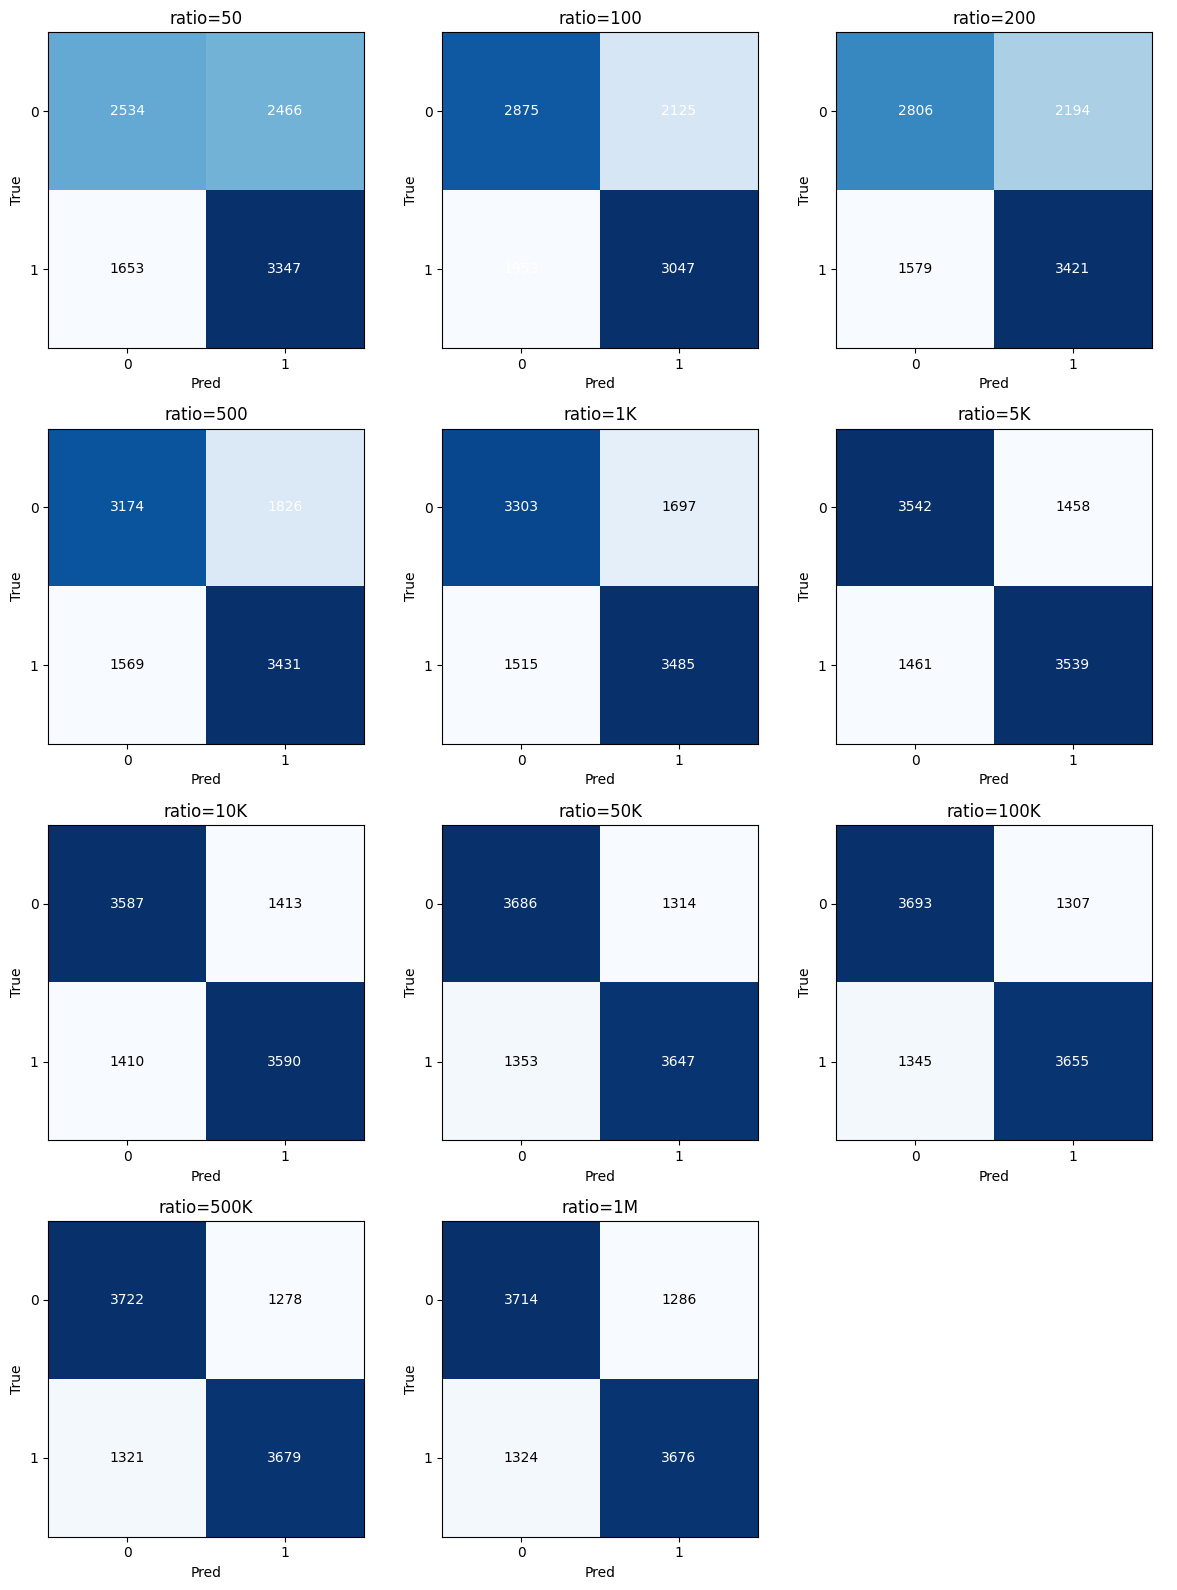

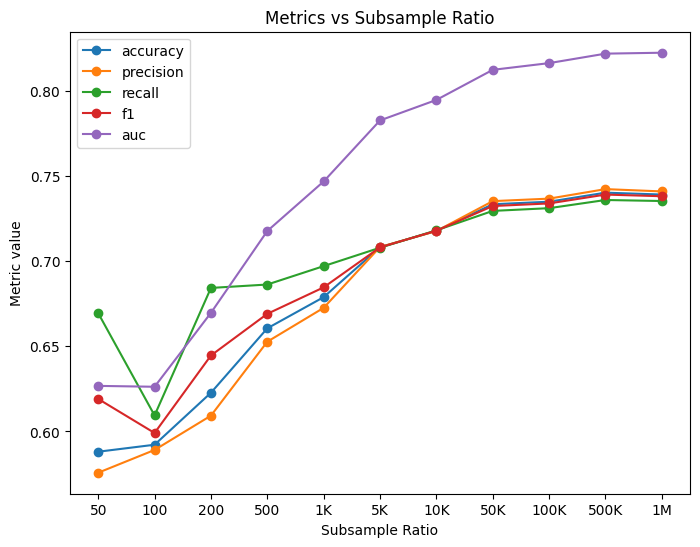


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.5881  0.5922  0.6227  0.6605  0.6788  0.7081  0.7177  0.7333  0.7348  0.7401  0.7390
precision  0.5758  0.5891  0.6093  0.6527  0.6725  0.7082  0.7176  0.7351  0.7366  0.7422  0.7408
recall     0.6694  0.6094  0.6842  0.6862  0.6970  0.7078  0.7180  0.7294  0.7310  0.7358  0.7352
f1         0.6191  0.5991  0.6446  0.6690  0.6845  0.7080  0.7178  0.7323  0.7338  0.7390  0.7380
auc        0.6267  0.6262  0.6696  0.7176  0.7467  0.7825  0.7945  0.8122  0.8161  0.8217  0.8222


In [9]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_top_ft,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Deciles features

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.5310, precision=0.5240, recall=0.6774, f1=0.5909, auc=0.5438
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5379, precision=0.5383, recall=0.5322, f1=0.5353, auc=0.5472
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.5496, precision=0.5354, recall=0.7508, f1=0.6250, auc=0.5683
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.5928, precision=0.5718, recall=0.7392, f1=0.6448, auc=0.6361
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.6399, precision=0.6363, recall=0.6532, f1=0.6446, auc=0.6934
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.6872, precision=0.6918, recall=0.6752, f1=0.6834, auc=0.7569
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.6981, precision=0.7102, recall=0.6694, f1=0.6892, auc=0.7735
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.7125, precision=0.7198, recall=0.6958, f1=0.7076, auc=0.7933
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.7144, precision=0.7185, recall=0.7050, f1=0.7117, auc=0.7982
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.7221, precision=0.7294, recall=0.7062, f1=0.7176, auc=0.8040
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.7248, precision=0.7321, recall=0.7090, f1=0.7204, auc=0.8059


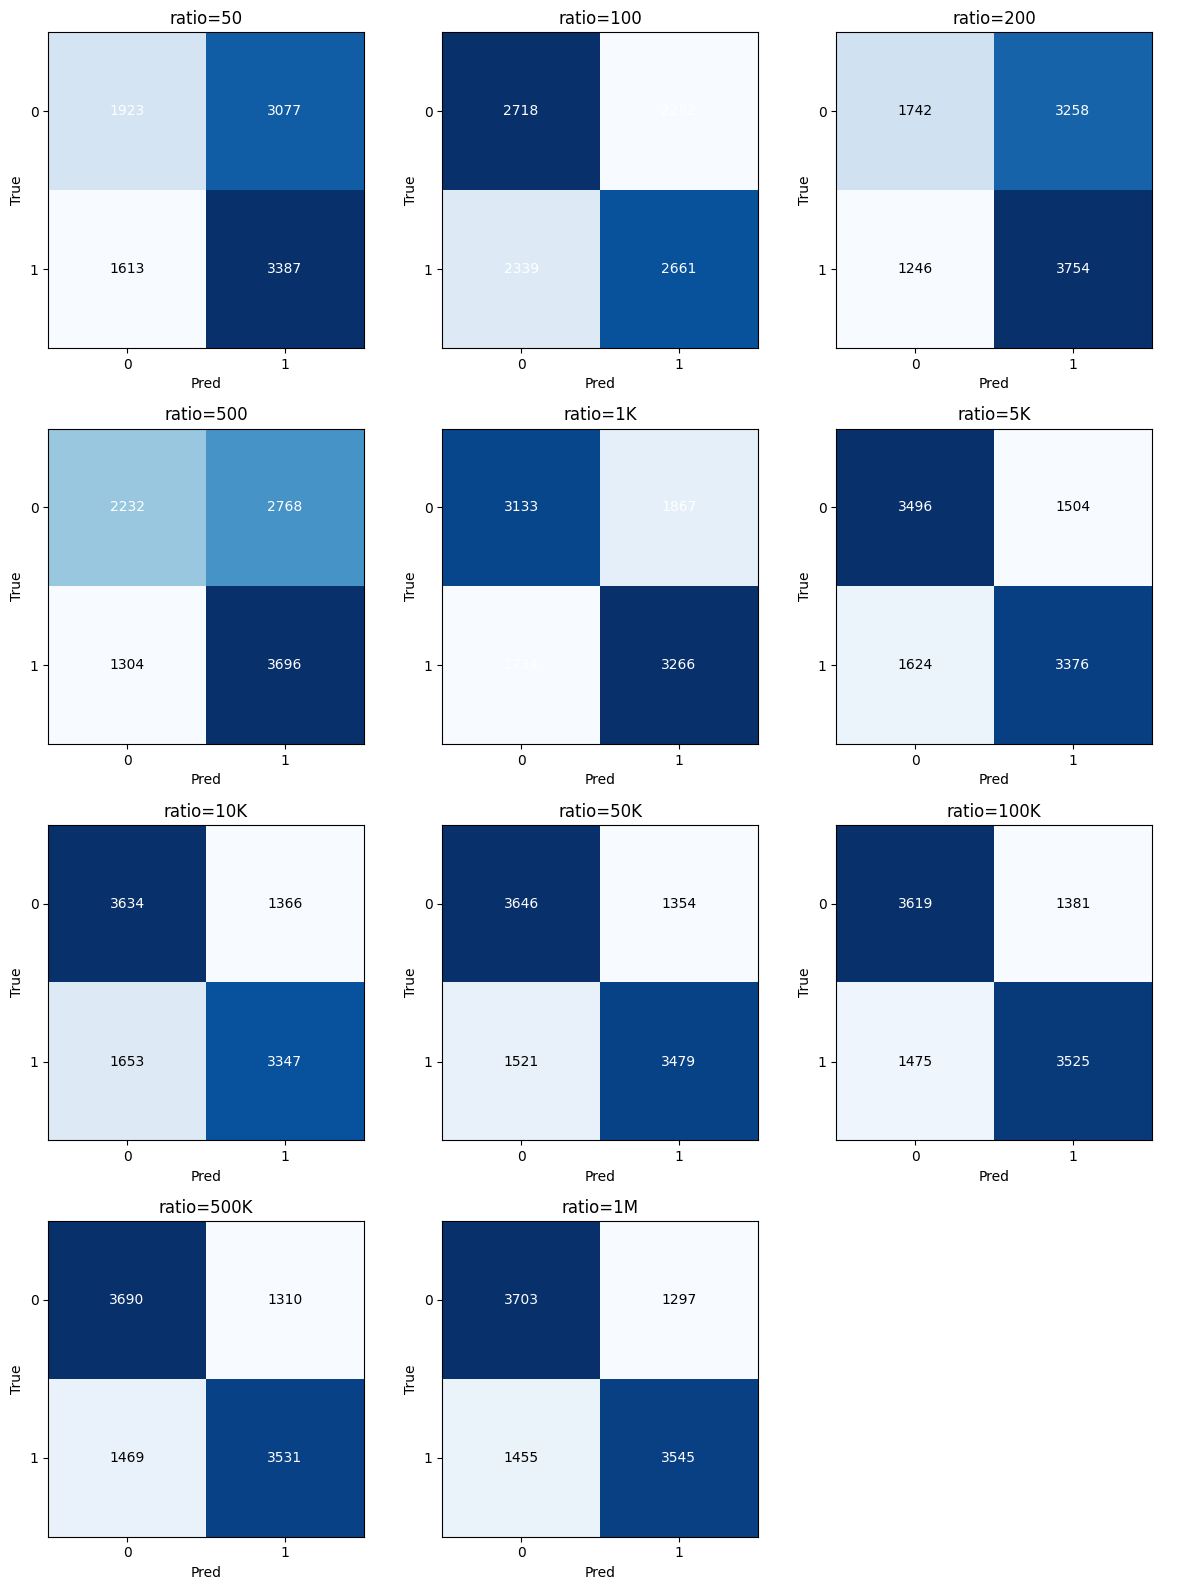

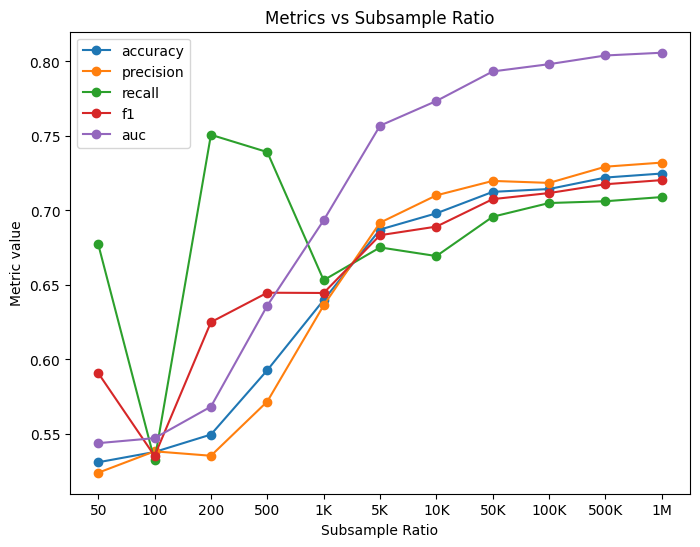


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.5310  0.5379  0.5496  0.5928  0.6399  0.6872  0.6981  0.7125  0.7144  0.7221  0.7248
precision  0.5240  0.5383  0.5354  0.5718  0.6363  0.6918  0.7102  0.7198  0.7185  0.7294  0.7321
recall     0.6774  0.5322  0.7508  0.7392  0.6532  0.6752  0.6694  0.6958  0.7050  0.7062  0.7090
f1         0.5909  0.5353  0.6250  0.6448  0.6446  0.6834  0.6892  0.7076  0.7117  0.7176  0.7204
auc        0.5438  0.5472  0.5683  0.6361  0.6934  0.7569  0.7735  0.7933  0.7982  0.8040  0.8059


In [17]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_deciles,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Z-score features

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.5911, precision=0.5777, recall=0.6770, f1=0.6234, auc=0.6292
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5908, precision=0.5839, recall=0.6320, f1=0.6070, auc=0.6250
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.6106, precision=0.6036, recall=0.6446, f1=0.6234, auc=0.6557
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.6507, precision=0.6382, recall=0.6958, f1=0.6658, auc=0.7110
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.6805, precision=0.6730, recall=0.7022, f1=0.6873, auc=0.7425
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.7055, precision=0.7070, recall=0.7018, f1=0.7044, auc=0.7835
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.7141, precision=0.7149, recall=0.7122, f1=0.7136, auc=0.7944
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.7319, precision=0.7324, recall=0.7308, f1=0.7316, auc=0.8121
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.7353, precision=0.7368, recall=0.7322, f1=0.7345, auc=0.8162
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.7385, precision=0.7399, recall=0.7356, f1=0.7377, auc=0.8214
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.7392, precision=0.7417, recall=0.7340, f1=0.7378, auc=0.8218


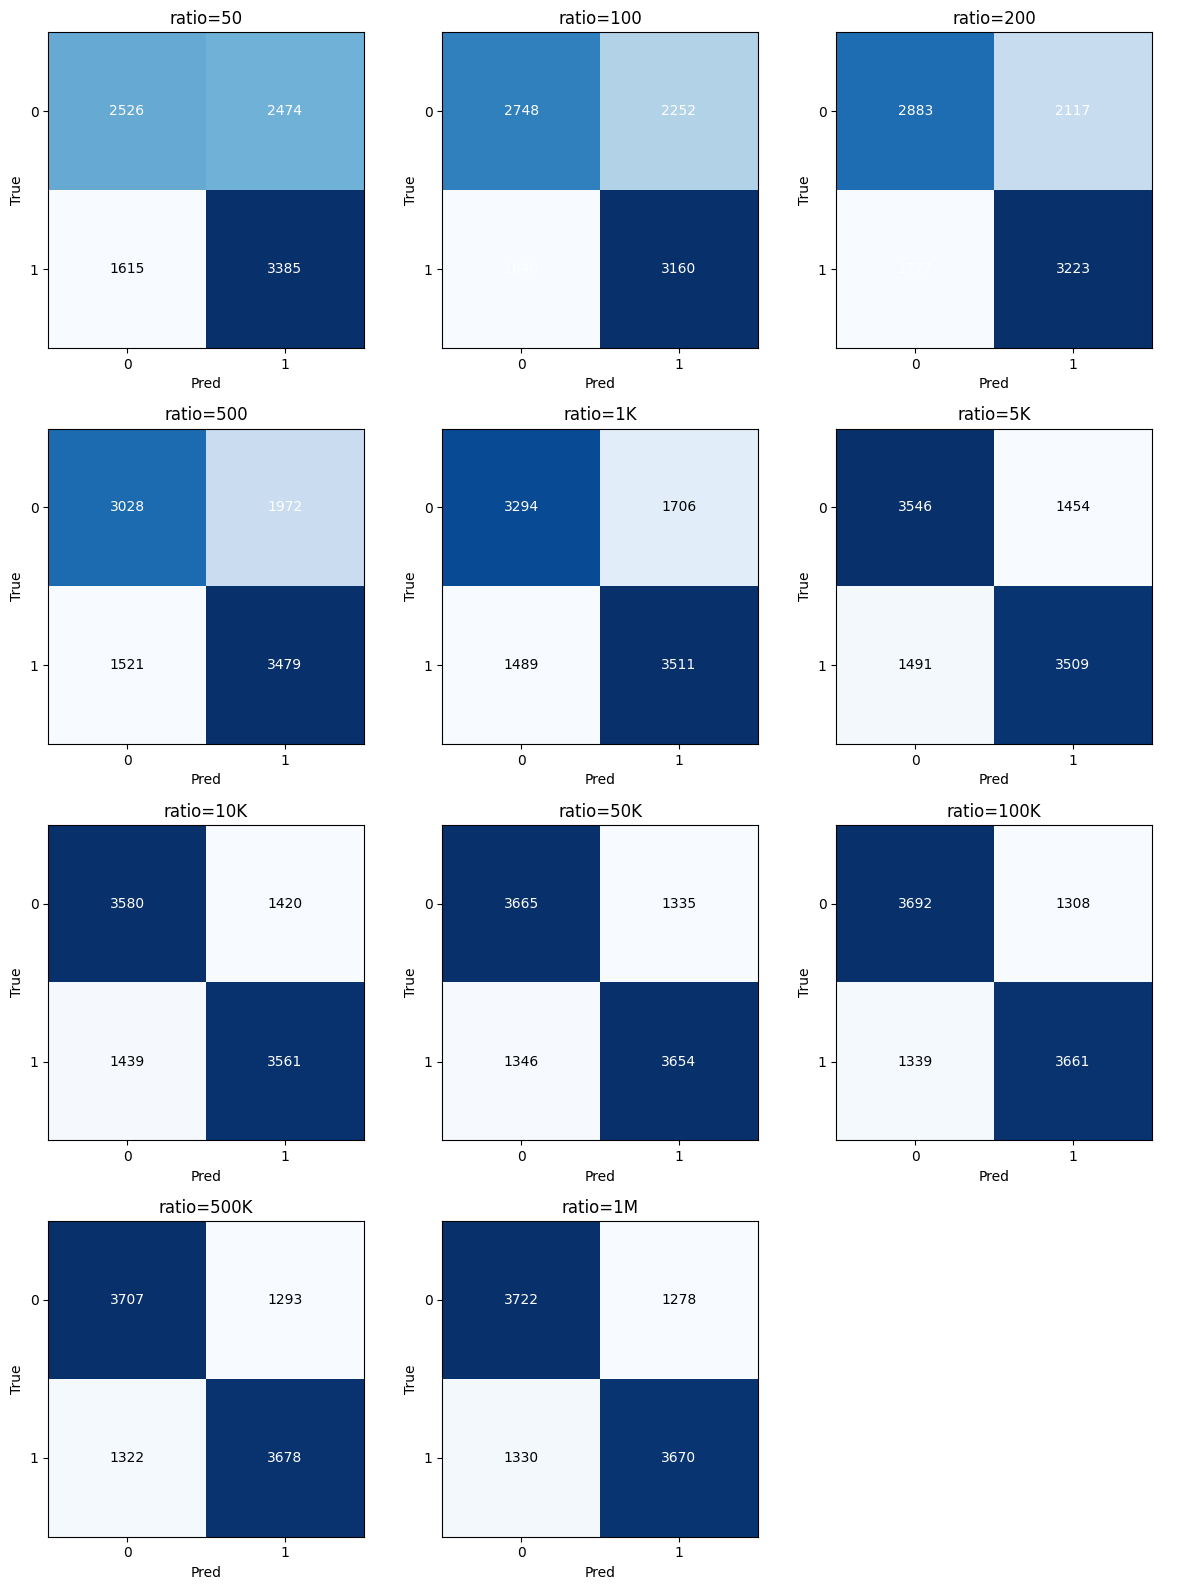

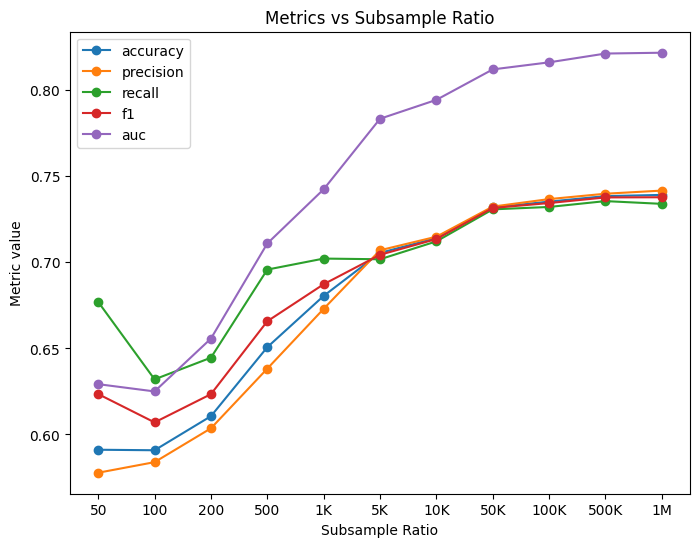


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.5911  0.5908  0.6106  0.6507  0.6805  0.7055  0.7141  0.7319  0.7353  0.7385  0.7392
precision  0.5777  0.5839  0.6036  0.6382  0.6730  0.7070  0.7149  0.7324  0.7368  0.7399  0.7417
recall     0.6770  0.6320  0.6446  0.6958  0.7022  0.7018  0.7122  0.7308  0.7322  0.7356  0.7340
f1         0.6234  0.6070  0.6234  0.6658  0.6873  0.7044  0.7136  0.7316  0.7345  0.7377  0.7378
auc        0.6292  0.6250  0.6557  0.7110  0.7425  0.7835  0.7944  0.8121  0.8162  0.8214  0.8218


In [18]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_z_score,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Scaled features

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.5946, precision=0.5853, recall=0.6490, f1=0.6155, auc=0.6300
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5941, precision=0.5893, recall=0.6208, f1=0.6047, auc=0.6322
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.6214, precision=0.6118, recall=0.6644, f1=0.6370, auc=0.6656
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.6611, precision=0.6521, recall=0.6908, f1=0.6709, auc=0.7159
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.6728, precision=0.6672, recall=0.6896, f1=0.6782, auc=0.7394
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.7063, precision=0.7075, recall=0.7034, f1=0.7054, auc=0.7821
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.7153, precision=0.7153, recall=0.7152, f1=0.7153, auc=0.7964
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.7301, precision=0.7316, recall=0.7268, f1=0.7292, auc=0.8127
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.7332, precision=0.7352, recall=0.7290, f1=0.7321, auc=0.8162
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.7391, precision=0.7402, recall=0.7368, f1=0.7385, auc=0.8215
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.7383, precision=0.7418, recall=0.7310, f1=0.7364, auc=0.8219


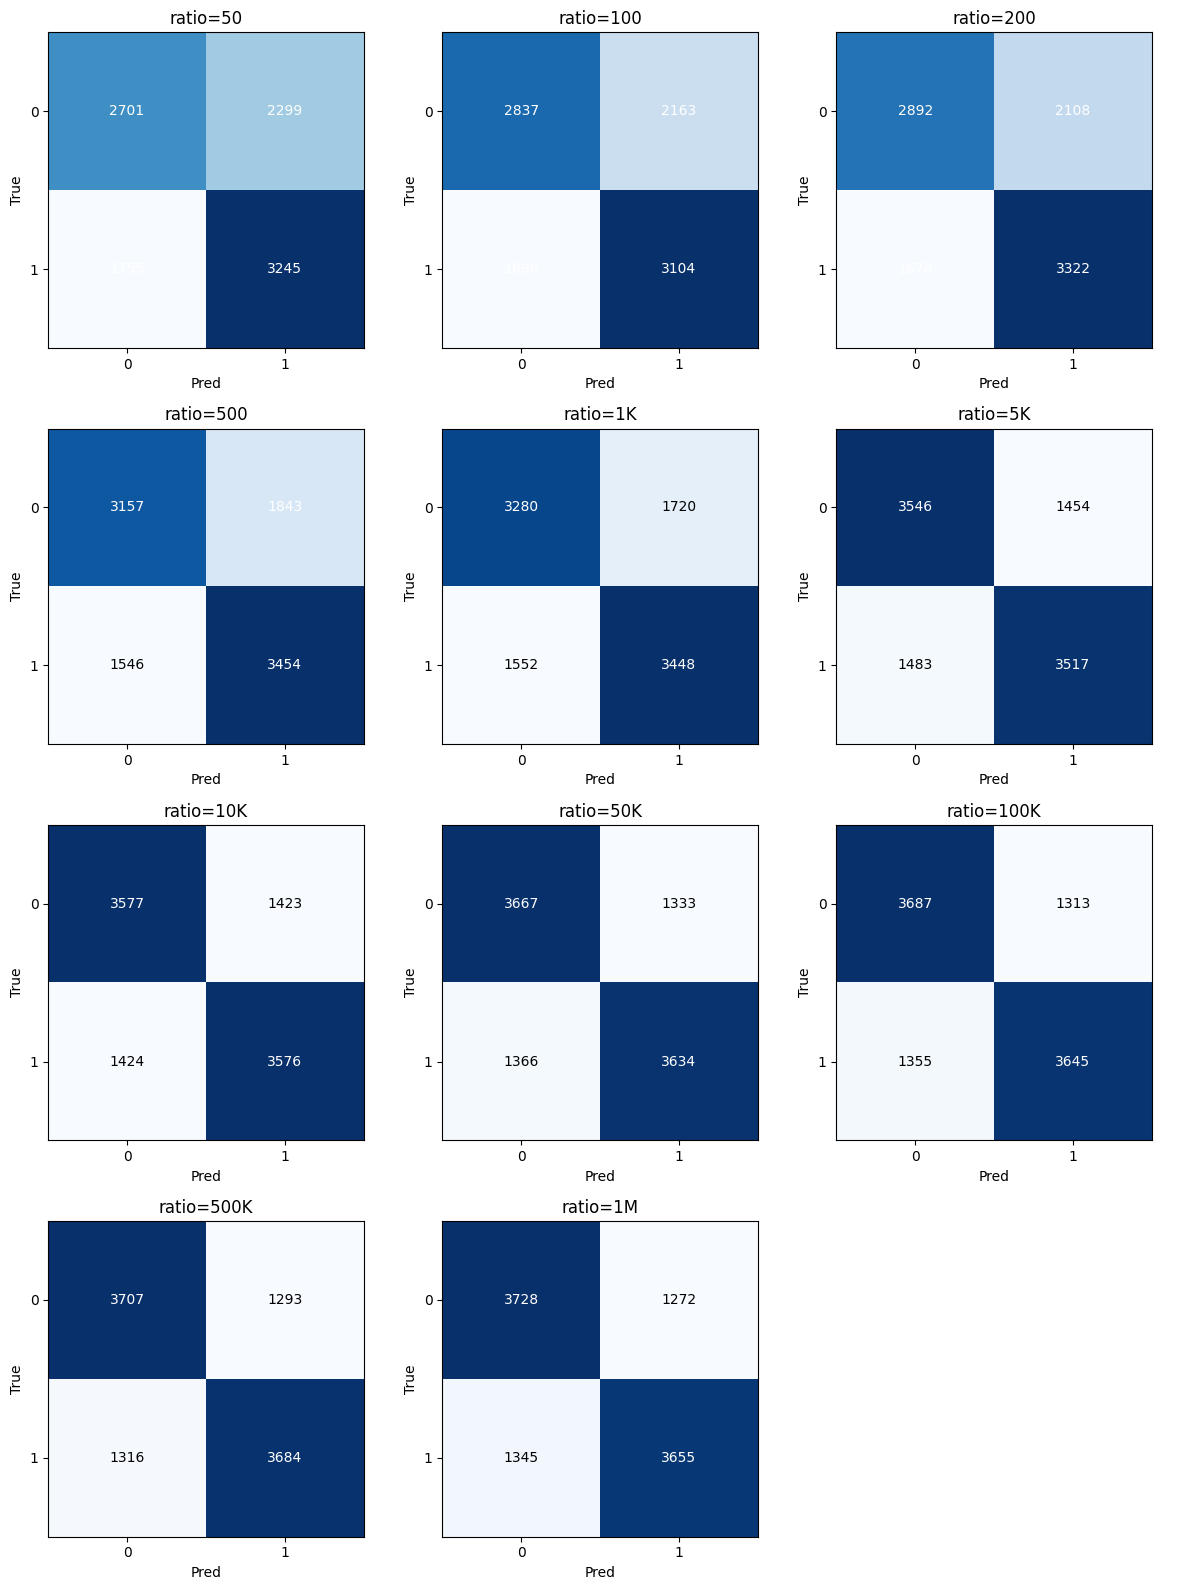

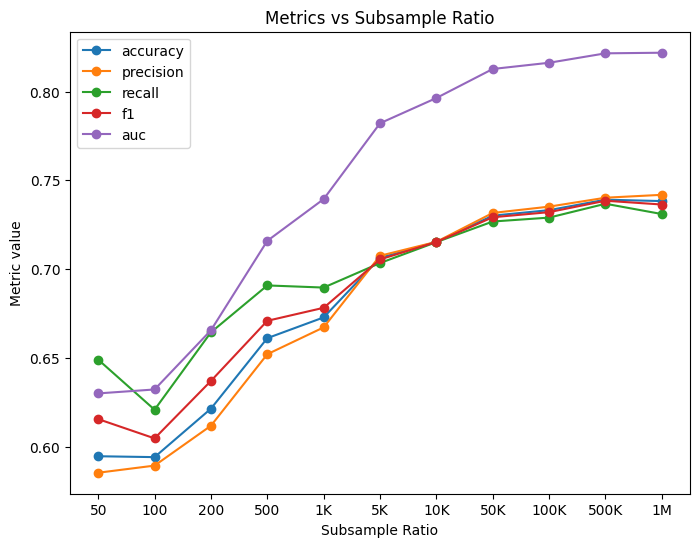


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.5946  0.5941  0.6214  0.6611  0.6728  0.7063  0.7153  0.7301  0.7332  0.7391  0.7383
precision  0.5853  0.5893  0.6118  0.6521  0.6672  0.7075  0.7153  0.7316  0.7352  0.7402  0.7418
recall     0.6490  0.6208  0.6644  0.6908  0.6896  0.7034  0.7152  0.7268  0.7290  0.7368  0.7310
f1         0.6155  0.6047  0.6370  0.6709  0.6782  0.7054  0.7153  0.7292  0.7321  0.7385  0.7364
auc        0.6300  0.6322  0.6656  0.7159  0.7394  0.7821  0.7964  0.8127  0.8162  0.8215  0.8219


In [19]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=higgs_scaled,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

## TabPFN Few-Shot

In [11]:
token = tabpfn_client.get_access_token()
tabpfn_client.set_access_token(token)

  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:01<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:06<00:00]
Processing: 100%|████████████████████████████████████████████████████████████████| [00:07<00:00]


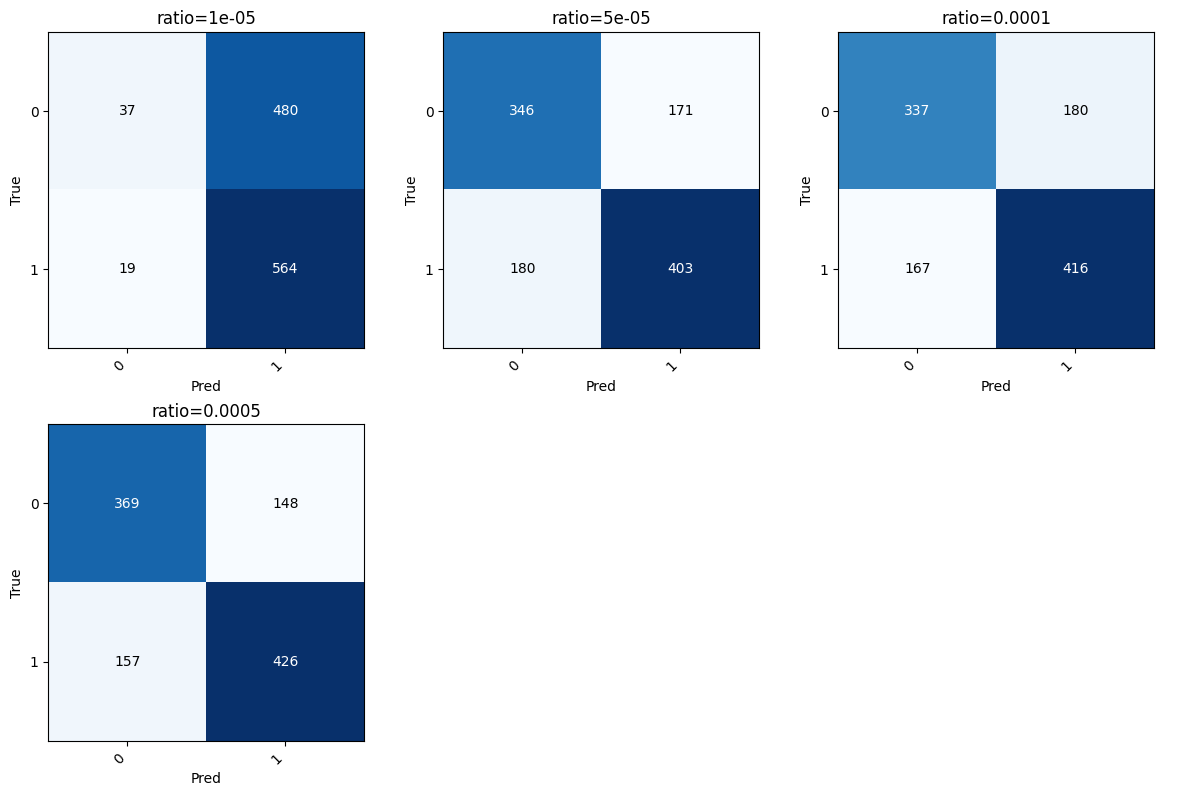

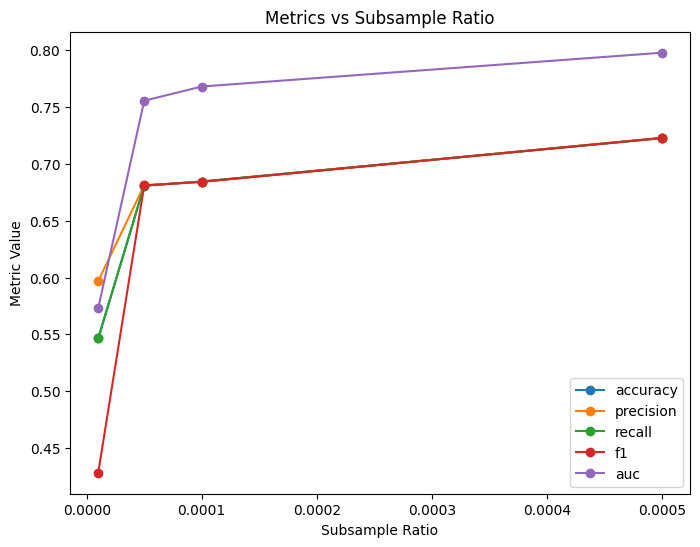

In [22]:
results = run_tabpfn_experiment(
    df=df,
    label_col='label',
    test_size=0.0001,
    subsample_ratios=[0.00001, 0.00005, 0.0001, 0.0005], #, 0.001],
    device='cpu',
    is_classifier=True,
    use_remote=True,
)

### Static Sets

#### All features raw

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.5452, precision=0.5452, recall=0.5452, f1=0.5452, auc=0.5664
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.6029, precision=0.6038, recall=0.6029, f1=0.6020, auc=0.6280
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.6295, precision=0.6331, recall=0.6295, f1=0.6269, auc=0.6644
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.6763, precision=0.6778, recall=0.6763, f1=0.6756, auc=0.7368
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6922, precision=0.6926, recall=0.6922, f1=0.6921, auc=0.7638
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.7162, precision=0.7163, recall=0.7162, f1=0.7162, auc=0.7939
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.7212, precision=0.7213, recall=0.7212, f1=0.7212, auc=0.8020


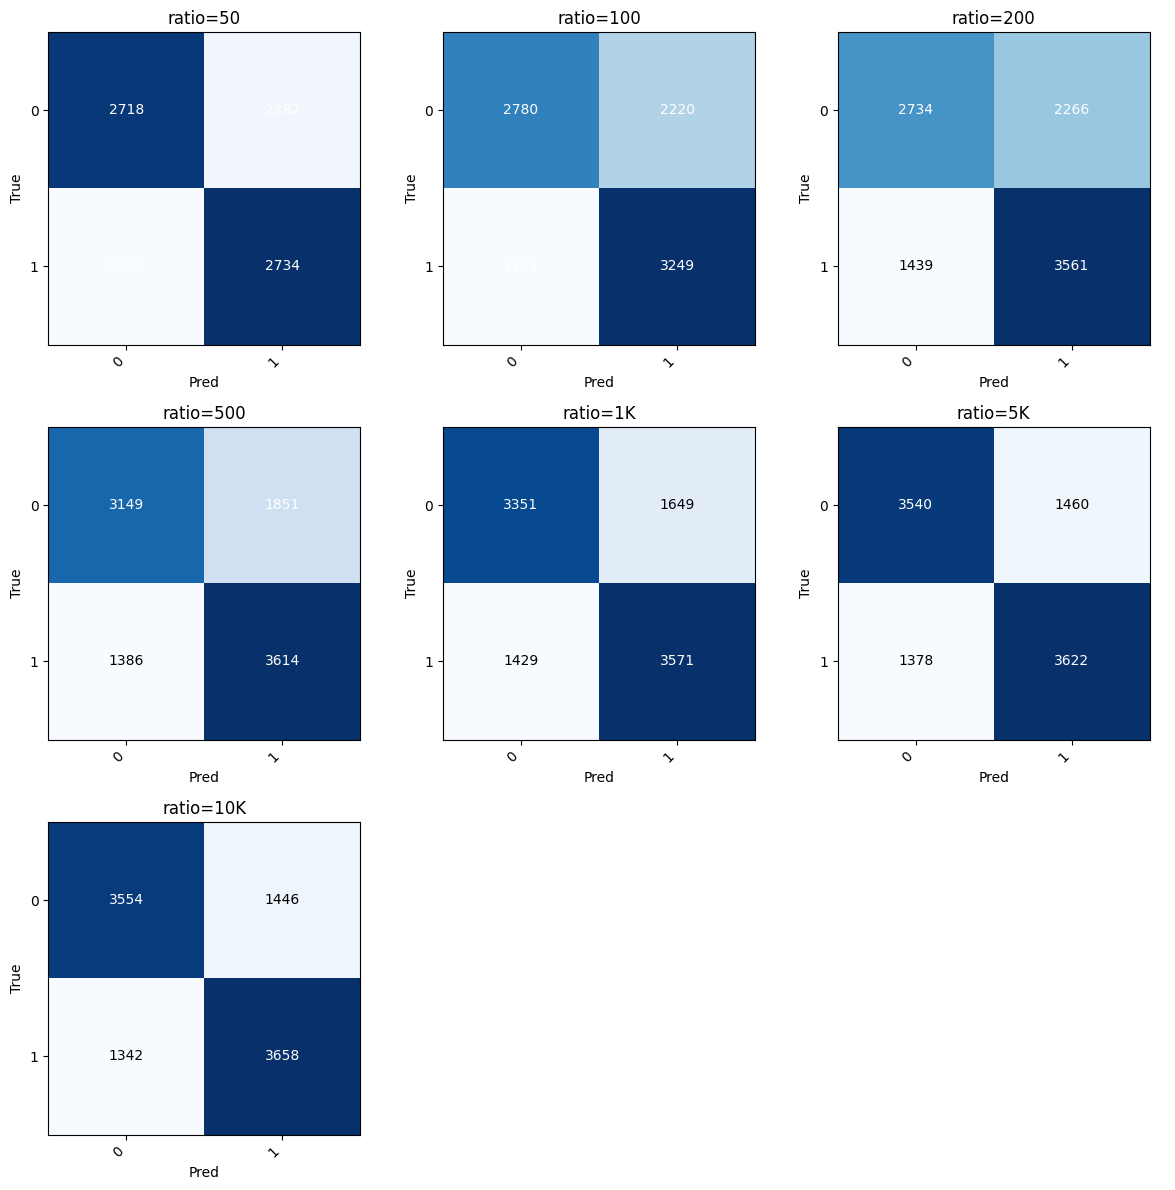

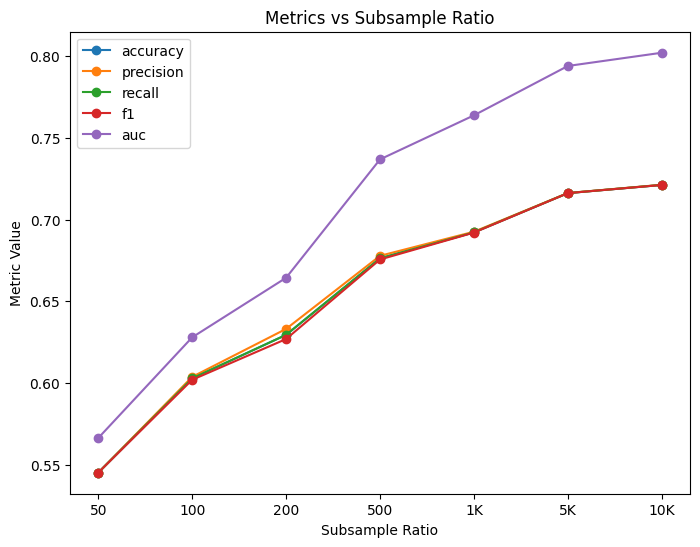


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.5452  0.6029  0.6295  0.6763  0.6922  0.7162  0.7212
precision  0.5452  0.6038  0.6331  0.6778  0.6926  0.7163  0.7213
recall     0.5452  0.6029  0.6295  0.6763  0.6922  0.7162  0.7212
f1         0.5452  0.6020  0.6269  0.6756  0.6921  0.7162  0.7212
auc        0.5664  0.6280  0.6644  0.7368  0.7638  0.7939  0.8020


In [25]:
results = run_tabpfn_experiment_sets(
    df=higgs_df,
    label_col='label',
    test_size=0.0001,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Top features raw

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.6241, precision=0.6243, recall=0.6241, f1=0.6240, auc=0.6551
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.6042, precision=0.6050, recall=0.6042, f1=0.6034, auc=0.6352
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.6355, precision=0.6386, recall=0.6355, f1=0.6334, auc=0.6818
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.6767, precision=0.6778, recall=0.6767, f1=0.6762, auc=0.7347
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6952, precision=0.6957, recall=0.6952, f1=0.6950, auc=0.7651
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.7150, precision=0.7151, recall=0.7150, f1=0.7150, auc=0.7952
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.7191, precision=0.7194, recall=0.7191, f1=0.7190, auc=0.8018


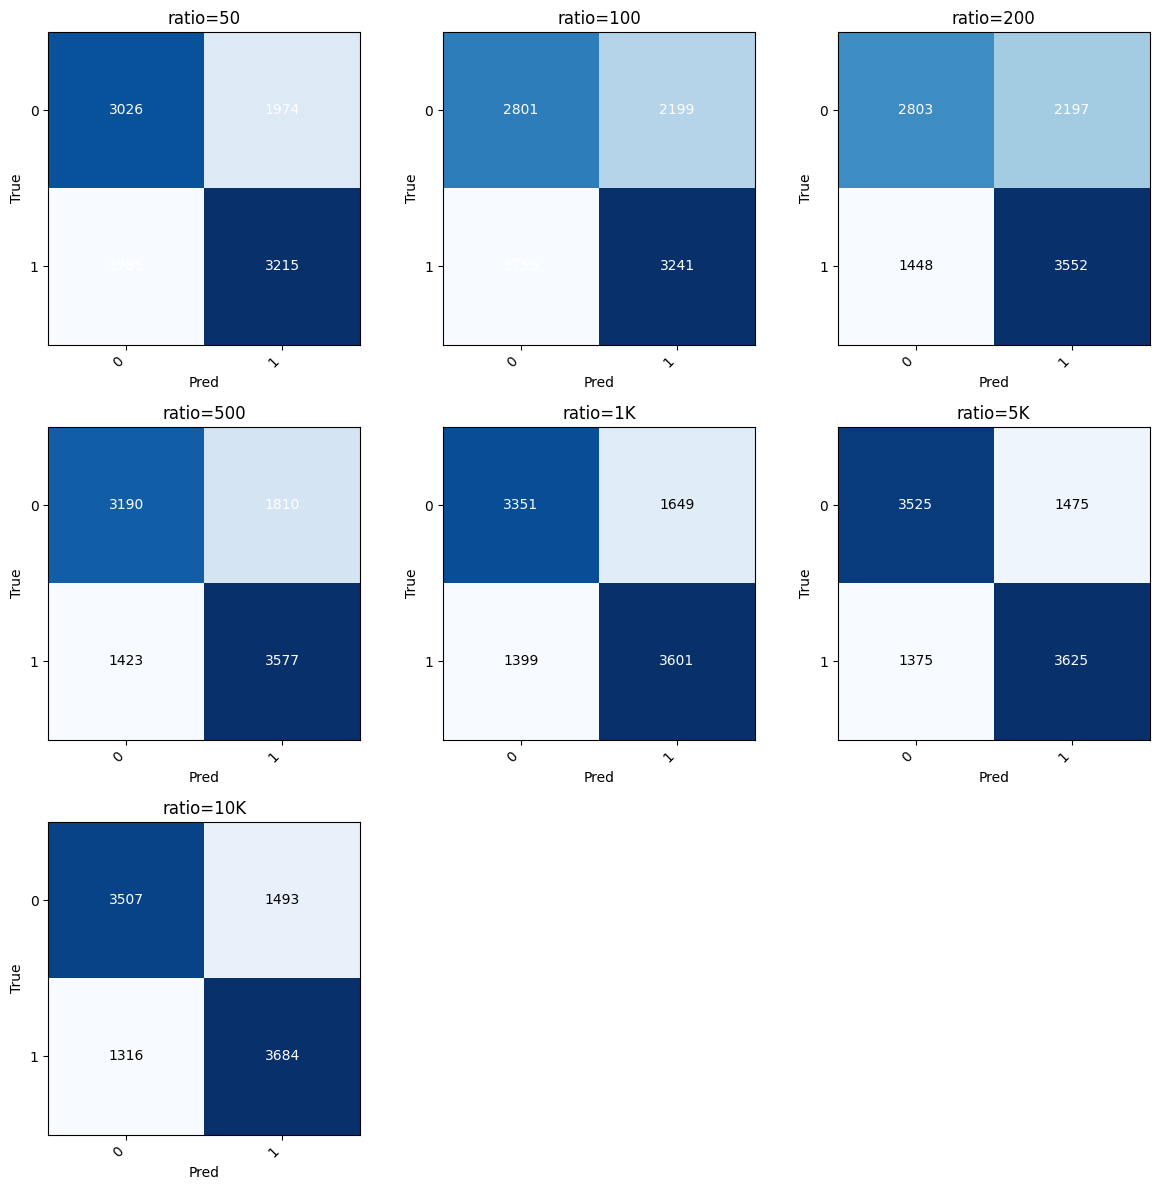

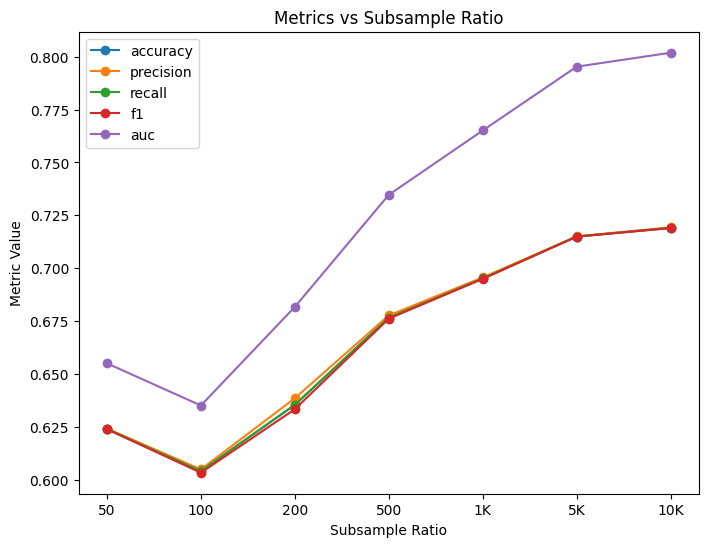


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.6241  0.6042  0.6355  0.6767  0.6952  0.7150  0.7191
precision  0.6243  0.6050  0.6386  0.6778  0.6957  0.7151  0.7194
recall     0.6241  0.6042  0.6355  0.6767  0.6952  0.7150  0.7191
f1         0.6240  0.6034  0.6334  0.6762  0.6950  0.7150  0.7190
auc        0.6551  0.6352  0.6818  0.7347  0.7651  0.7952  0.8018


In [12]:
results = run_tabpfn_experiment_sets(
    df=higgs_top_ft,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Deciles features

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.5169, precision=0.5170, recall=0.5169, f1=0.5161, auc=0.5248
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.5221, precision=0.5221, recall=0.5221, f1=0.5221, auc=0.5339
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.5380, precision=0.5403, recall=0.5380, f1=0.5312, auc=0.5793
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.6060, precision=0.6060, recall=0.6060, f1=0.6060, auc=0.6458
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6312, precision=0.6313, recall=0.6312, f1=0.6311, auc=0.6773
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.6708, precision=0.6713, recall=0.6708, f1=0.6706, auc=0.7326
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.6801, precision=0.6806, recall=0.6801, f1=0.6799, auc=0.7465


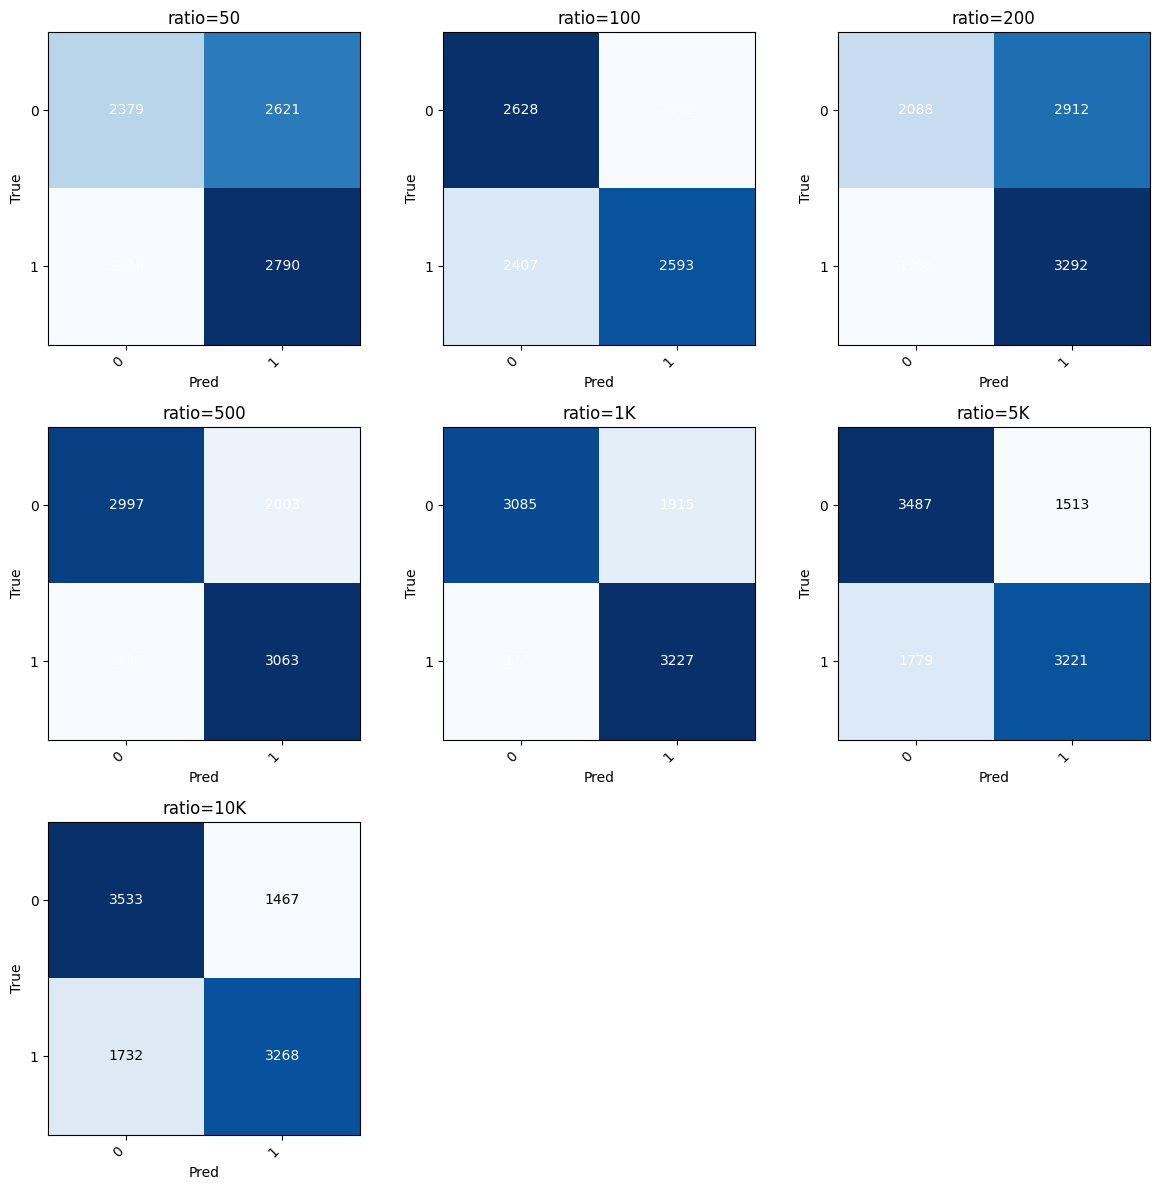

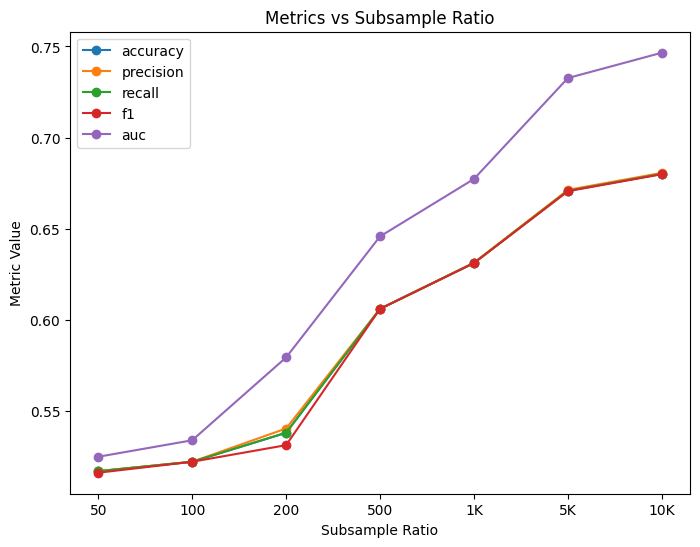


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.5169  0.5221  0.5380  0.6060  0.6312  0.6708  0.6801
precision  0.5170  0.5221  0.5403  0.6060  0.6313  0.6713  0.6806
recall     0.5169  0.5221  0.5380  0.6060  0.6312  0.6708  0.6801
f1         0.5161  0.5221  0.5312  0.6060  0.6311  0.6706  0.6799
auc        0.5248  0.5339  0.5793  0.6458  0.6773  0.7326  0.7465


In [26]:
results = run_tabpfn_experiment_sets(
    df=higgs_deciles,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Z-score features

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.6217, precision=0.6217, recall=0.6217, f1=0.6217, auc=0.6591
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.6065, precision=0.6077, recall=0.6065, f1=0.6054, auc=0.6360
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.6320, precision=0.6352, recall=0.6320, f1=0.6298, auc=0.6802
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.6782, precision=0.6793, recall=0.6782, f1=0.6777, auc=0.7367
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6980, precision=0.6986, recall=0.6980, f1=0.6978, auc=0.7654
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.7151, precision=0.7152, recall=0.7151, f1=0.7151, auc=0.7959
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.7199, precision=0.7201, recall=0.7199, f1=0.7198, auc=0.8021


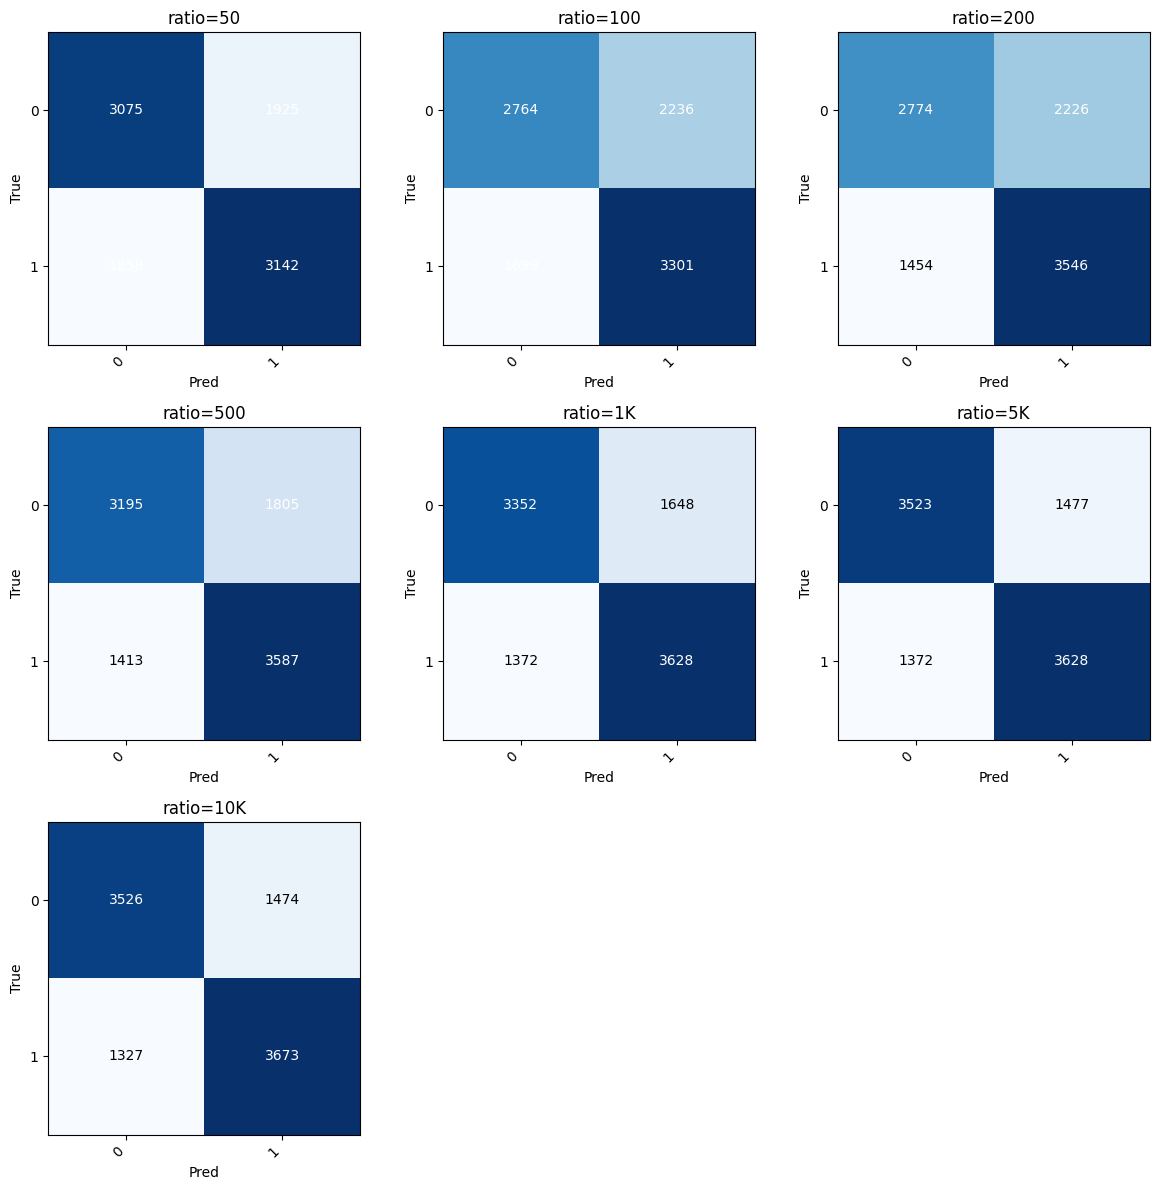

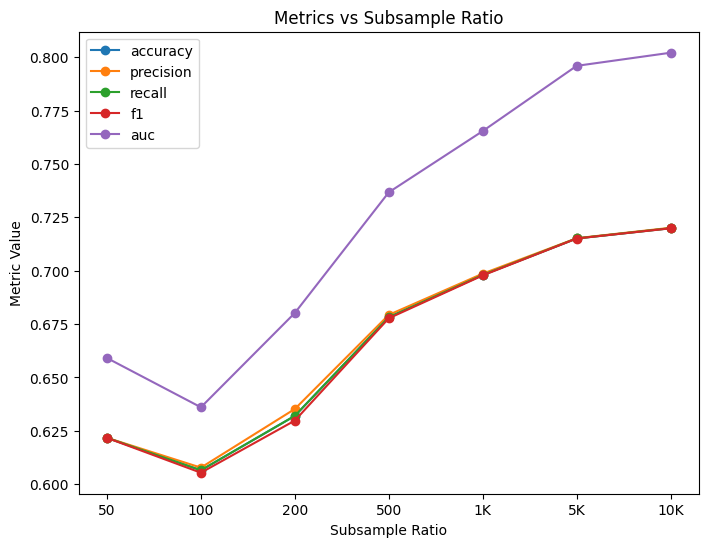


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.6217  0.6065  0.6320  0.6782  0.6980  0.7151  0.7199
precision  0.6217  0.6077  0.6352  0.6793  0.6986  0.7152  0.7201
recall     0.6217  0.6065  0.6320  0.6782  0.6980  0.7151  0.7199
f1         0.6217  0.6054  0.6298  0.6777  0.6978  0.7151  0.7198
auc        0.6591  0.6360  0.6802  0.7367  0.7654  0.7959  0.8021


In [27]:
results = run_tabpfn_experiment_sets(
    df=higgs_z_score,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Scaled features

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.6173, precision=0.6176, recall=0.6173, f1=0.6170, auc=0.6487
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.6076, precision=0.6084, recall=0.6076, f1=0.6068, auc=0.6392
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.6330, precision=0.6365, recall=0.6330, f1=0.6306, auc=0.6784
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.6795, precision=0.6805, recall=0.6795, f1=0.6790, auc=0.7377
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6967, precision=0.6972, recall=0.6967, f1=0.6965, auc=0.7660
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.7152, precision=0.7153, recall=0.7152, f1=0.7152, auc=0.7955
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.7197, precision=0.7200, recall=0.7197, f1=0.7196, auc=0.8023


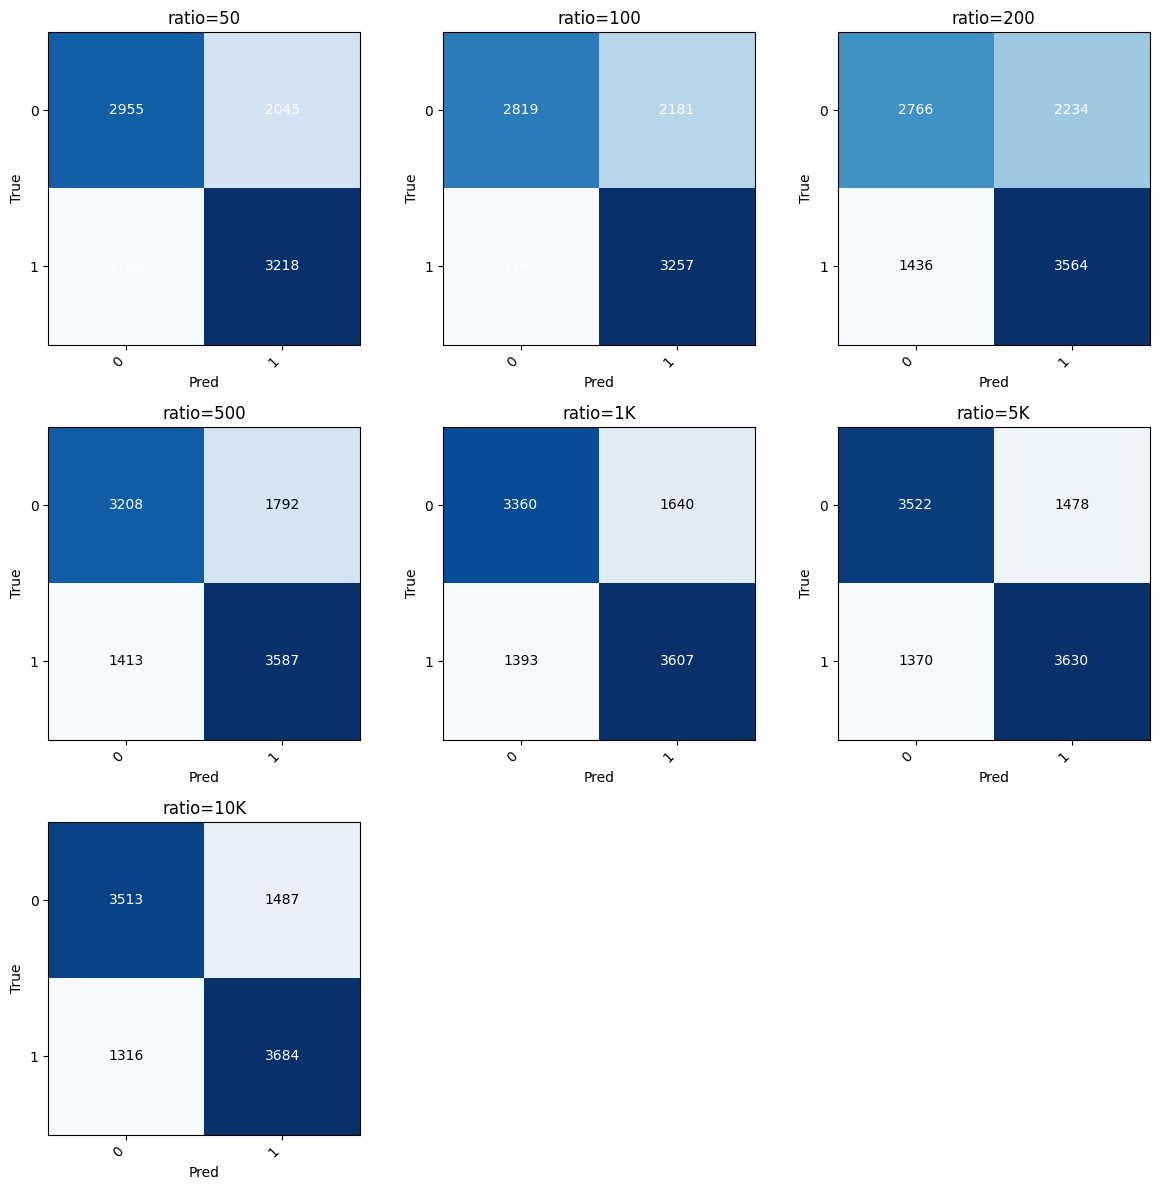

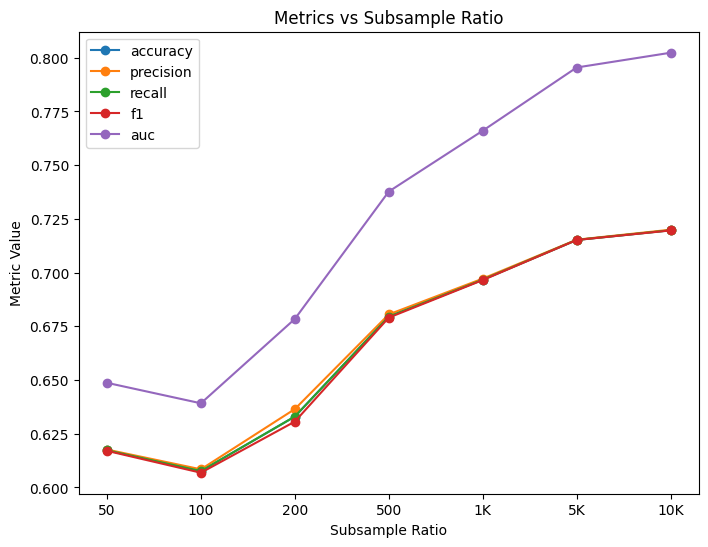


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.6173  0.6076  0.6330  0.6795  0.6967  0.7152  0.7197
precision  0.6176  0.6084  0.6365  0.6805  0.6972  0.7153  0.7200
recall     0.6173  0.6076  0.6330  0.6795  0.6967  0.7152  0.7197
f1         0.6170  0.6068  0.6306  0.6790  0.6965  0.7152  0.7196
auc        0.6487  0.6392  0.6784  0.7377  0.7660  0.7955  0.8023


In [28]:
results = run_tabpfn_experiment_sets(
    df=higgs_scaled,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

## T5 Encoder Head Only Fine-tuning

### Ratios

In [ ]:
from t5_enc_pipeline import run_t5_enc_experiment

# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment(
    df=higgs_deciles,
    label_col='is_higgs_event',
    task_def='Higgs Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_ratios=[0.01],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=1e-5,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=False,
    bf16=True,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=320,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio 0.01 ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=320, max=320
DEBUG: Sample training prompt: Higgs Classification | "dijet_invariant_mass":"third_decile","trijet_invariant_mass":"fourth_decile","lepton_missing_energy_mass":"fifth_decile","dijet_lepton_missing_energy_mass":"tenth_decile","bjet_pair_invariant_mass":"fifth_decile","wboson_bjet_pair_mass":"eighth_decile","wboson_bjet_pair_plus_jet_mass":"eighth_decile","leading_jet_b_tag":"second_decile","subleading_jet_b_tag":"first_decile","third_jet_b_tag":"second_decile","fourth_jet_b_tag":"first_decile","missing_transverse_energy":"tenth_decile","leading_jet_transverse_momentum":"first_decile","lepton_transverse_momentum":"first_decile","fourth_jet_transverse_momentum":"fourth_decile","subleading_jet_transverse_
DEBUG: Sample training label: 0
DEBUG: Training data size: 76961
DEBUG: Validation data size: 32984

=== PRE-TRAINING 

/home/ubuntu/oron/nlp/t5_enc_pipeline.py:422: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=76961, val=32984, test=5500):
  accuracy=0.4701, precision=0.2210, recall=0.4701, f1=0.3006, auc=0.4984
Learning Curves (ratio=0.01, train=76,961, val=32,984)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=76961, val=32984, test=5500):
  accuracy=0.5298, precision=0.4988, recall=0.5298, f1=0.3688, auc=0.5076
Learning Curves (ratio=0.01, train=76,961, val=32,984)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=76961, val=32984, test=5500):
  accuracy=0.5299, precision=0.2808, recall=0.5299, f1=0.3671, auc=0.5120
Learning Curves (ratio=0.01, train=76,961, val=32,984)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=76961, val=32984, test=5500):
  accuracy=0.5299, precision=0.2808, recall=0.5299, f1=0.3671, auc=0.5144
Learning Curves (ratio=0.01, train=76,961, val=32,984)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


### Static Sets

#### ALL features raw

#### Top features raw

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=257, max=270
DEBUG: Sample training prompt: Higgs Classification | "dijet_invariant_mass":0.3933,"trijet_invariant_mass":0.9899,"lepton_missing_energy_mass":1.1447,"dijet_lepton_missing_energy_mass":1.3297,"bjet_pair_invariant_mass":0.9349,"wboson_bjet_pair_mass":1.0655,"wboson_bjet_pair_plus_jet_mass":0.9325,"leading_jet_b_tag":2.1731,"subleading_jet_b_tag":2.2149,"third_jet_b_tag":0.0,"fourth_jet_b_tag":0.0,"missing_transverse_energy":1.6704,"leading_jet_transverse_momentum":0.8795,"lepton_transverse_momentum":0.6759,"fourth_jet_transverse_momentum":0.6007,"subleading_jet_transverse_momentum":1.4026
DEBUG: Sample training label: 0
DEBUG: Training data size: 50000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.2226
DEBUG: Pre-training logits: tensor([[ 0.7557, -0.6617],
        [ 0.7309,

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/p

Test metrics (ratio=50K, train=50000, val=10000, test=10000):
  accuracy=0.6892, precision=0.6900, recall=0.6892, f1=0.6889, auc=0.7657


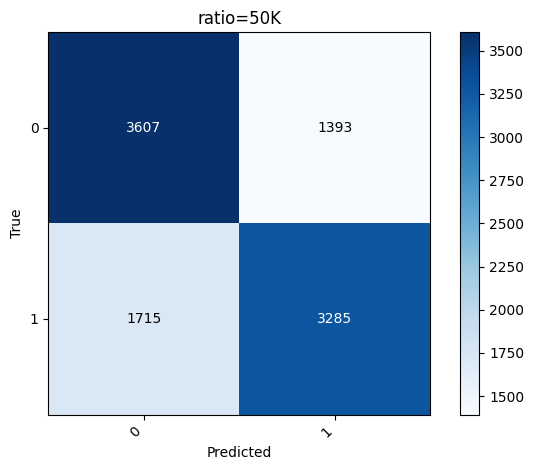

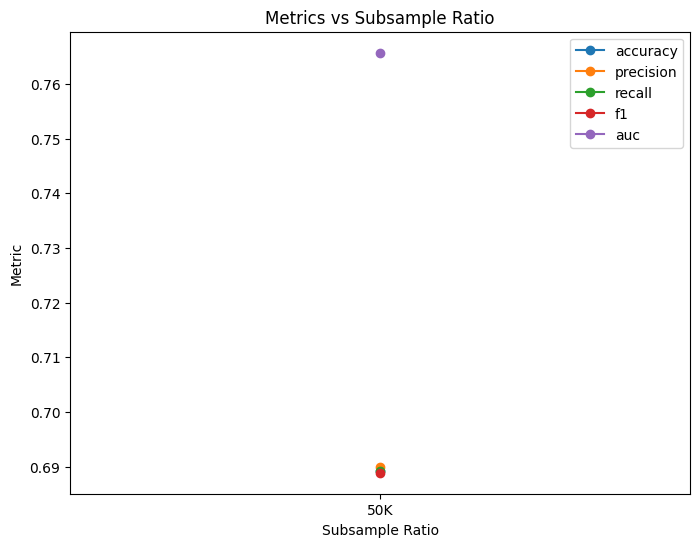

In [14]:
results = run_t5_enc_experiment_sets(
    df=higgs_top_ft,
    label_col='label',
    task_def='Higgs Classification',
    subsample_sets=['50K'],  # train‐set fractions to sweep
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=6,
    per_device_train_batch_size=32, #16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    # optimizer & scheduler
    learning_rate=5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,
    dataloader_num_workers=4,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=320,
)

In [ ]:
results = run_t5_enc_experiment_sets(
    df=higgs_top_ft,
    label_col='label',
    task_def='Higgs Classification',
    subsample_sets=['100K'],  # train‐set fractions to sweep
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=12,
    per_device_train_batch_size=32, #16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    # optimizer & scheduler
    learning_rate=5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,
    dataloader_num_workers=8,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=320,
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=256, max=270
DEBUG: Sample training prompt: Higgs Classification | "dijet_invariant_mass":0.8991,"trijet_invariant_mass":0.74,"lepton_missing_energy_mass":0.989,"dijet_lepton_missing_energy_mass":1.2129,"bjet_pair_invariant_mass":0.9464,"wboson_bjet_pair_mass":0.9411,"wboson_bjet_pair_plus_jet_mass":0.8291,"leading_jet_b_tag":2.1731,"subleading_jet_b_tag":1.1074,"third_jet_b_tag":0.0,"fourth_jet_b_tag":0.0,"missing_transverse_energy":1.164,"leading_jet_transverse_momentum":0.6096,"lepton_transverse_momentum":1.4121,"fourth_jet_transverse_momentum":0.7789,"subleading_jet_transverse_momentum":1.081
DEBUG: Sample training label: 1
DEBUG: Training data size: 100000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 1.5954
DEBUG: Pre-training logits: tensor([[ 0.7554, -0.6440],
        [ 0.7235, -0.6142]])
DEBUG: Pre-training pre

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/p

#### Deciles features

In [ ]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=higgs_deciles,
    label_col='label',
    task_def='Higgs Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['10K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=1e-5,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=False,
    bf16=True,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

#### Z-score features

#### Scaled features

## T5 Fused Head Fine-tuning

### Ratios - Runs with good results

LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)

=== Processing ratio 0.0005 ===
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: 1090.0 ; trijet_invariant_mass: 921.0 ; lepton_missing_energy_mass: 988.0 ; dijet_lepton_missing_energy_mass: 897.0 ; bjet_pair_invariant_mass: 1488.0 ; wboson_bjet_pair_mass: 1046.0 ; wboson_bjet_pair_plus_jet_mass: 867.0 ; leading_jet_b_tag: 2173.0 ; subleading_jet_b_tag: 2215.0 ; third_jet_b_tag: 0.0 ; fourth_jet_b_tag: 0.0 ; missing_transverse_energy: 696.0 ; leading_jet_transverse_momentum: 1121.0 ; lepton_transverse_momentum: 955.0 ; fourth_jet_transverse_momentum: 1178.0 ; subleading_jet_transverse_momentum: 992.0</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 3847
DEBUG: Validation data size: 1650

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.6760
DEBUG: Pre-training logits: tensor([[ 0.1786, -0.1552],
        [ 0.0680, -0.1158]])
DEBUG: Pre-training pre

/home/ubuntu/oron/nlp/t5_small_pipeline.py:395: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


DEBUG: Raw logits shape: (1650, 2)
DEBUG: Sample logits: [[0.0486145  0.07104492]
 [0.04797363 0.06896973]
 [0.0475769  0.07037354]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [   0 1650]
DEBUG: True labels: [1 0 0 0 0 0 1 0 0 1]
DEBUG: True label distribution: [791 859]
DEBUG: Raw logits shape: (1650, 2)
DEBUG: Sample logits: [[ 0.38110352 -0.16320801]
 [-0.40283203  0.57421875]
 [ 0.3190918  -0.10925293]]
DEBUG: Predictions: [0 1 0 1 1 0 0 0 1 1]
DEBUG: Prediction distribution: [ 618 1032]
DEBUG: True labels: [1 0 0 0 0 0 1 0 0 1]
DEBUG: True label distribution: [791 859]


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.42211914 -0.1763916 ]
 [-0.65722656  0.79785156]
 [ 0.5239258  -0.2915039 ]]
DEBUG: Predictions: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2525 2975]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.42211914 -0.1763916 ]
 [-0.65722656  0.79785156]
 [ 0.5239258  -0.2915039 ]]
DEBUG: Predictions: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2525 2975]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Final predictions for confusion matrix: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2525 2975]
DEBUG: Final true labels for confusion matrix: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]


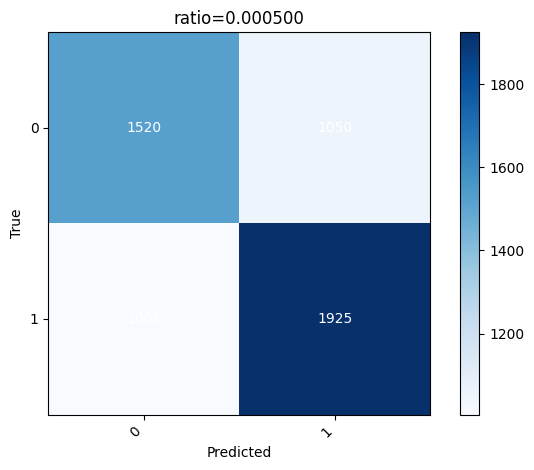

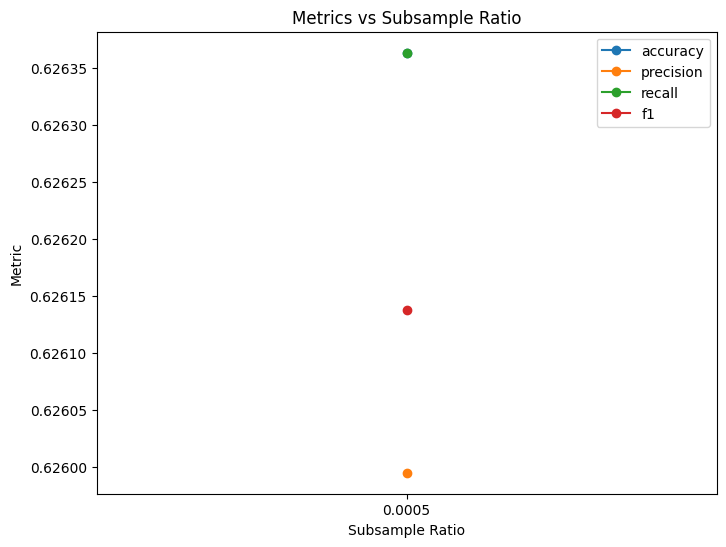

In [12]:
results = run_t5_experiment(
    df=df_scaled,
    label_col='is_higgs_event',        # your target column name
    test_size=0.0005,            # 20% held out for test
    subsample_ratios=[0.0005],  # the list of train‑set fractions to try
    val_ratio=0.3,            # 10% of (each) train split for validation
    model_name='t5-base',    # or another T5 checkpoint
    output_dir='./t5_results',# where to save checkpoints & logs
    random_state=42,          # for reproducibility
    # below are T5 training kwargs, 
    # e.g. num_train_epochs, per_device_train_batch_size, learning_rate, etc.
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-3,#5e-4,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=12,#4,                        # optionally tune these
    lora_alpha=64,#32,
    lora_dropout=0.1,
    warmup_steps=100,
)

LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)

=== Processing ratio 0.001 ===
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: 1144.0 ; trijet_invariant_mass: 880.0 ; lepton_missing_energy_mass: 978.0 ; dijet_lepton_missing_energy_mass: 1258.0 ; bjet_pair_invariant_mass: 544.0 ; wboson_bjet_pair_mass: 828.0 ; wboson_bjet_pair_plus_jet_mass: 1035.0 ; leading_jet_b_tag: 2173.0 ; subleading_jet_b_tag: 0.0 ; third_jet_b_tag: 2548.0 ; fourth_jet_b_tag: 0.0 ; missing_transverse_energy: 578.0 ; leading_jet_transverse_momentum: 905.0 ; lepton_transverse_momentum: 1275.0 ; fourth_jet_transverse_momentum: 1291.0 ; subleading_jet_transverse_momentum: 447.0</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 7695
DEBUG: Validation data size: 3299

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.5948
DEBUG: Pre-training logits: tensor([[ 0.0455, -0.1461],
        [ 0.0737, -0.1498]])
DEBUG: Pre-training pred

/home/ubuntu/oron/nlp/t5_small_pipeline.py:395: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.03393555 -0.1616211 ]
 [ 0.034729   -0.1619873 ]
 [ 0.0378418  -0.15563965]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.24951172  0.13183594]
 [-0.24804688  0.13269043]
 [-0.24890137  0.13342285]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [   0 3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.2355957   0.1137085 ]
 [-0.22619629  0.11126709]
 [-0.25439453  0.1463623 ]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [   0 3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.3408203  -

DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.25878906 -0.17932129]
 [-0.76464844  0.70214844]
 [ 0.34985352 -0.32421875]]
DEBUG: Predictions: [0 1 0 1 1 0 0 1 1 0]
DEBUG: Prediction distribution: [2101 3399]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.25878906 -0.17932129]
 [-0.76464844  0.70214844]
 [ 0.34985352 -0.32421875]]
DEBUG: Predictions: [0 1 0 1 1 0 0 1 1 0]
DEBUG: Prediction distribution: [2101 3399]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Final predictions for confusion matrix: [0 1 0 1 1 0 0 1 1 0]
DEBUG: Prediction distribution: [2101 3399]
DEBUG: Final true labels for confusion matrix: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]


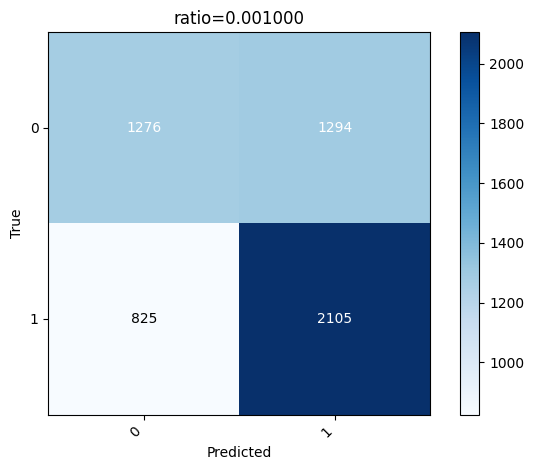

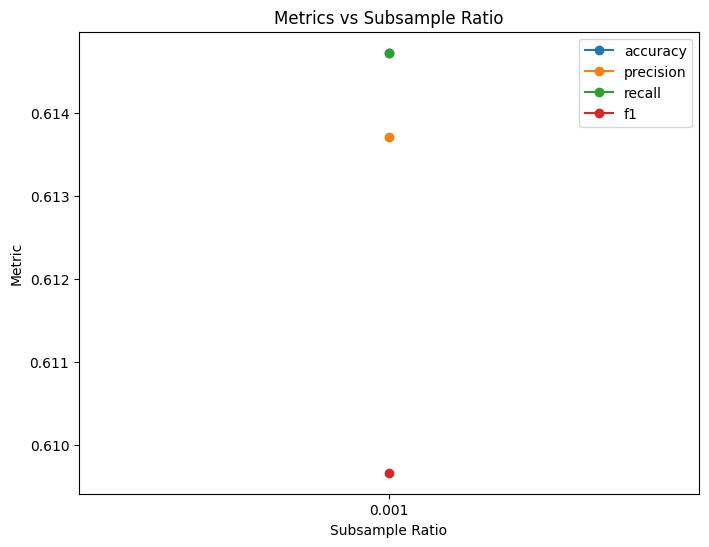

In [13]:
results = run_t5_experiment(
    df=df_scaled,
    label_col='is_higgs_event',          # our target column name
    test_size=0.0005,            # % of dataset to be held out for test
    subsample_ratios=[0.001],  # the list of train‑set fractions to try
    val_ratio=0.3,            # % split for validation
    model_name='t5-base',    # T5 version
    output_dir='./t5_results',
    random_state=42,        
    # below are T5 training kwargs, 
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-4,#1e-3,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=8,#4,                     # optionally tune these
    lora_alpha=32,#64,
    lora_dropout=0.0,#0.1,
    warmup_steps=100,
)

LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)

=== Processing ratio 0.001 ===
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: 1144.0 ; trijet_invariant_mass: 880.0 ; lepton_missing_energy_mass: 978.0 ; dijet_lepton_missing_energy_mass: 1258.0 ; bjet_pair_invariant_mass: 544.0 ; wboson_bjet_pair_mass: 828.0 ; wboson_bjet_pair_plus_jet_mass: 1035.0 ; leading_jet_b_tag: 2173.0 ; subleading_jet_b_tag: 0.0 ; third_jet_b_tag: 2548.0 ; fourth_jet_b_tag: 0.0 ; missing_transverse_energy: 578.0 ; leading_jet_transverse_momentum: 905.0 ; lepton_transverse_momentum: 1275.0 ; fourth_jet_transverse_momentum: 1291.0 ; subleading_jet_transverse_momentum: 447.0</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 7695
DEBUG: Validation data size: 3299

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.5948
DEBUG: Pre-training logits: tensor([[ 0.0455, -0.1461],
        [ 0.0737, -0.1498]])
DEBUG: Pre-training pred

/home/ubuntu/oron/nlp/t5_small_pipeline.py:395: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.02210999 -0.13903809]
 [ 0.02276611 -0.14038086]
 [ 0.02206421 -0.1381836 ]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.25610352  0.14550781]
 [-0.2565918   0.1459961 ]
 [-0.25634766  0.14660645]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [   0 3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.28271484  0.19140625]
 [-0.2824707   0.19091797]
 [-0.28344727  0.19177246]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [   0 3299]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]
DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.08544922  

DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.21875    -0.20983887]
 [-0.38916016  0.32421875]
 [-0.00813293 -0.01026917]]
DEBUG: Predictions: [0 1 0 1 1 1 0 1 1 0]
DEBUG: Prediction distribution: [1470 4030]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.21875    -0.20983887]
 [-0.38916016  0.32421875]
 [-0.00813293 -0.01026917]]
DEBUG: Predictions: [0 1 0 1 1 1 0 1 1 0]
DEBUG: Prediction distribution: [1470 4030]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Final predictions for confusion matrix: [0 1 0 1 1 1 0 1 1 0]
DEBUG: Prediction distribution: [1470 4030]
DEBUG: Final true labels for confusion matrix: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]


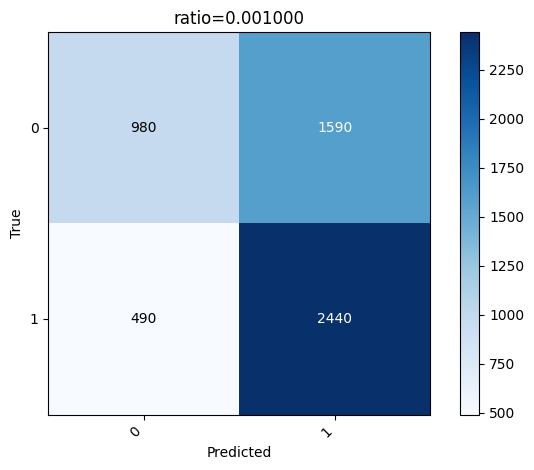

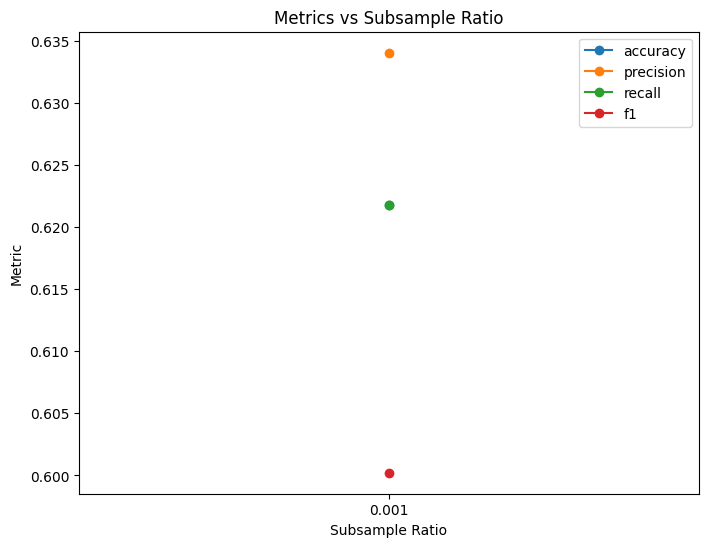

In [16]:
results = run_t5_experiment(
    df=df_scaled,
    label_col='is_higgs_event',        # your target column name
    test_size=0.0005,            # 20% held out for test
    subsample_ratios=[0.001],  # the list of train‑set fractions to try
    val_ratio=0.3,            # 10% of (each) train split for validation
    model_name='t5-base',    # or another T5 checkpoint
    output_dir='./t5_results',# where to save checkpoints & logs
    random_state=42,          # for reproducibility
    # below are T5 training kwargs, 
    # e.g. num_train_epochs, per_device_train_batch_size, learning_rate, etc.
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-4,#1e-3,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=8,#4,                        # optionally tune these
    lora_alpha=32,#64,
    lora_dropout=0.0,#0.1,
    warmup_steps=100,
)

LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)

=== Processing ratio 0.001 ===
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: ninth_decile ; trijet_invariant_mass: fourth_decile ; lepton_missing_energy_mass: first_decile ; dijet_lepton_missing_energy_mass: ninth_decile ; bjet_pair_invariant_mass: second_decile ; wboson_bjet_pair_mass: third_decile ; wboson_bjet_pair_plus_jet_mass: eighth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: second_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: third_decile ; leading_jet_transverse_momentum: sixth_decile ; lepton_transverse_momentum: eighth_decile ; fourth_jet_transverse_momentum: eighth_decile ; subleading_jet_transverse_momentum: first_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 7695
DEBUG: Validation data size: 3299

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 

/home/ubuntu/oron/nlp/t5_small_pipeline.py:396: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.042804   -0.15402241]
 [-0.01969696 -0.04111885]
 [-0.23336738  0.1458193 ]]
DEBUG: Predictions: [0 0 1 1 1 0 1 1 1 1]
DEBUG: Prediction distribution: [ 641 2658]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.6886381  -0.9862698 ]
 [ 0.4394053  -0.64332277]
 [ 0.07912944 -0.2709042 ]]
DEBUG: Predictions: [0 0 0 0 1 0 0 1 1 1]
DEBUG: Prediction distribution: [1778 1521]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.38430917 -0.5405448 ]
 [-0.5234966   0.40253136]
 [ 0.4222103  -0.68822694]]
DEBUG: Predictions: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2570 2930]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.38430917 -0.5405448 ]
 [-0.5234966   0.40253136]
 [ 0.4222103  -0.68822694]]
DEBUG: Predictions: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2570 2930]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Final predictions for confusion matrix: [0 1 0 0 1 0 0 1 0 1]
DEBUG: Prediction distribution: [2570 2930]
DEBUG: Final true labels for confusion matrix: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]


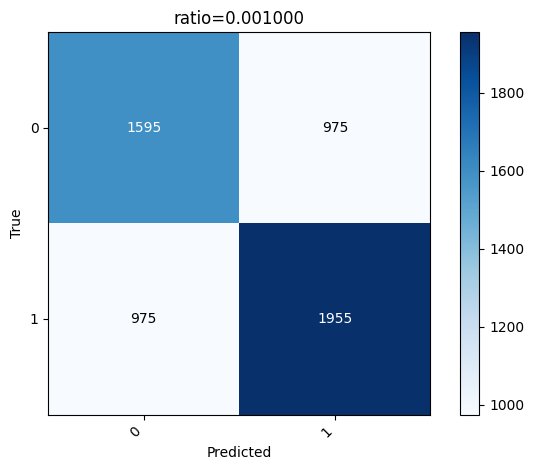

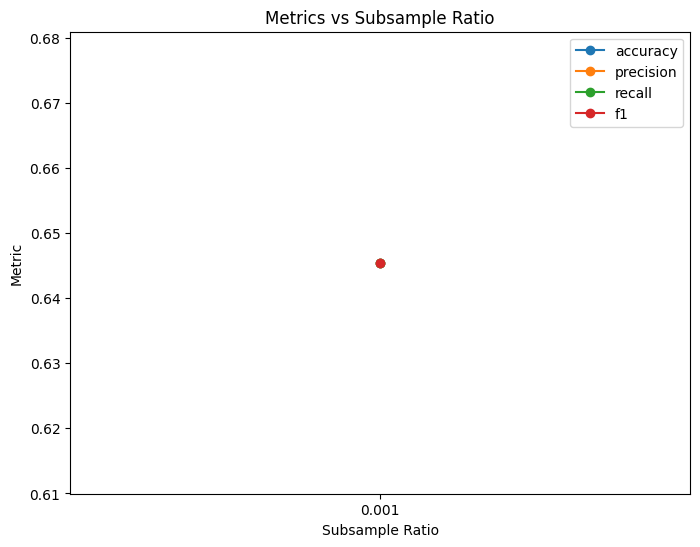

In [12]:
results = run_t5_experiment(
    df=df_deciles,
    label_col='is_higgs_event',          # our target column name
    test_size=0.0005,            # % of dataset to be held out for test
    subsample_ratios=[0.001],  # the list of train‑set fractions to try
    val_ratio=0.3,            # % split for validation
    model_name='t5-base',    # T5 version
    output_dir='./t5_results',
    random_state=42,        
    # below are T5 training kwargs, 
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-4,#1e-3,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=8,#4,                     # optionally tune these
    lora_alpha=32,#64,
    lora_dropout=0.0,#0.1,
    warmup_steps=100,
)

LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)

=== Processing ratio 0.001 ===
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: ninth_decile ; trijet_invariant_mass: fourth_decile ; lepton_missing_energy_mass: first_decile ; dijet_lepton_missing_energy_mass: ninth_decile ; bjet_pair_invariant_mass: second_decile ; wboson_bjet_pair_mass: third_decile ; wboson_bjet_pair_plus_jet_mass: eighth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: second_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: third_decile ; leading_jet_transverse_momentum: sixth_decile ; lepton_transverse_momentum: eighth_decile ; fourth_jet_transverse_momentum: eighth_decile ; subleading_jet_transverse_momentum: first_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 7695
DEBUG: Validation data size: 3299

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 

/home/ubuntu/oron/nlp/t5_small_pipeline.py:414: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[-0.10974588 -0.079042  ]
 [-0.09147521 -0.11181848]
 [-0.10731559 -0.09314729]]
DEBUG: Predictions: [1 0 1 1 1 1 1 0 1 1]
DEBUG: Prediction distribution: [1376 1923]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.5065325  -0.488282  ]
 [ 0.42327237 -0.4643002 ]
 [ 0.01156294  0.01898851]]
DEBUG: Predictions: [0 0 1 0 1 0 0 1 1 1]
DEBUG: Prediction distribution: [1879 1420]
DEBUG: True labels: [0 0 0 1 1 0 1 0 0 1]
DEBUG: True label distribution: [1536 1763]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.32579106 -0.36873955]
 [-0.55263007  0.37188816]
 [ 0.36218053 -0.27069077]]
DEBUG: Predictions: [0 1 0 1 1 0 0 1 0 0]
DEBUG: Prediction distribution: [2349 3151]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[ 0.32579106 -0.36873955]
 [-0.55263007  0.37188816]
 [ 0.36218053 -0.27069077]]
DEBUG: Predictions: [0 1 0 1 1 0 0 1 0 0]
DEBUG: Prediction distribution: [2349 3151]
DEBUG: True labels: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]
DEBUG: Final predictions for confusion matrix: [0 1 0 1 1 0 0 1 0 0]
DEBUG: Prediction distribution: [2349 3151]
DEBUG: Final true labels for confusion matrix: [0 1 0 1 0 1 0 1 0 0]
DEBUG: True label distribution: [2570 2930]


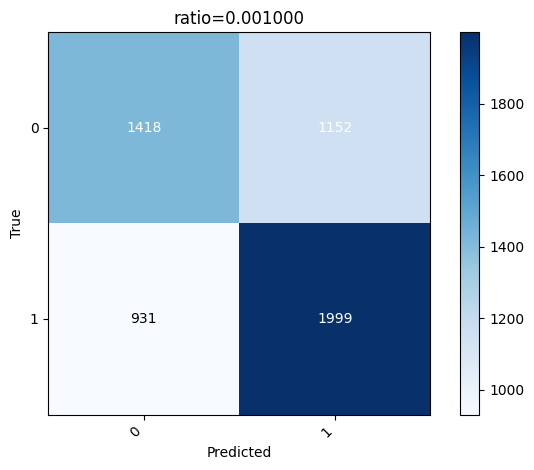

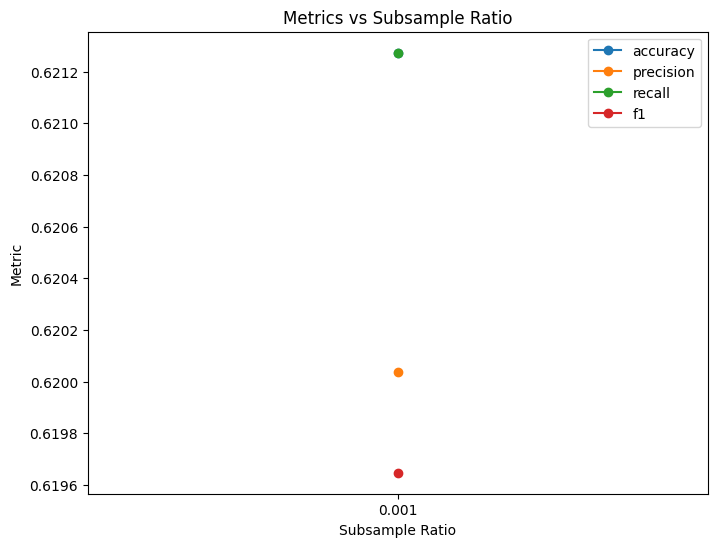

In [10]:
results = run_t5_experiment(
    df=df_deciles,
    label_col='is_higgs_event',          # our target column name
    test_size=0.0005,            # % of dataset to be held out for test
    subsample_ratios=[0.001],  # the list of train‑set fractions to try
    val_ratio=0.3,            # % split for validation
    model_name='t5-base',    # T5 version
    output_dir='./t5_results',
    random_state=42,        
    # below are T5 training kwargs, 
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-4,#1e-3,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=8,#4,                     # optionally tune these
    lora_alpha=32,#64,
    lora_dropout=0.0,#0.1,
    warmup_steps=100,
)

In [ ]:
results = run_t5_experiment(
    df=df_scaled,
    label_col='is_higgs_event',        # your target column name
    test_size=0.0005,            # 20% held out for test
    subsample_ratios=[0.0005],  # the list of train‑set fractions to try
    val_ratio=0.3,            # 10% of (each) train split for validation
    model_name='t5-base',    # or another T5 checkpoint
    output_dir='./t5_results',# where to save checkpoints & logs
    random_state=42,          # for reproducibility
    # below are T5 training kwargs, 
    # e.g. num_train_epochs, per_device_train_batch_size, learning_rate, etc.
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    learning_rate=5e-4,#1e-3,
    logging_steps=50,
    eval_steps=200,
    save_total_limit=2,
    use_lora=True,                   # turn on LoRA
    lora_r=8,#4,                        # optionally tune these
    lora_alpha=32,#64,
    lora_dropout=0.0,#0.1,
    warmup_steps=100,
)

### Ratios - Testing playground


=== Processing ratio 0.001 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=285, max=305
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: seventh_decile ; trijet_invariant_mass: first_decile ; lepton_missing_energy_mass: first_decile ; dijet_lepton_missing_energy_mass: first_decile ; bjet_pair_invariant_mass: first_decile ; wboson_bjet_pair_mass: first_decile ; wboson_bjet_pair_plus_jet_mass: first_decile ; leading_jet_b_tag: first_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: first_decile ; fourth_jet_b_tag: second_decile ; missing_transverse_energy: first_decile ; leading_jet_transverse_momentum: first_decile ; lepton_transverse_momentum: third_decile ; fourth_jet_transverse_momentum: seventh_decile ; subleading_jet_transverse_momentum: first_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 7695
DEBUG: Validation data size: 3299

=

/home/ubuntu/oron/nlp/t5_small_pipeline.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (3299, 2)
DEBUG: Sample logits: [[ 0.13761222  0.11716506]
 [ 0.14960855  0.0734051 ]
 [ 0.3570016  -0.08773725]]
DEBUG: Predictions: [0 0 0 0 1 0 0 1 1 1]
DEBUG: Prediction distribution: [2061 1238]
DEBUG: True labels: [1 0 0 1 1 1 0 1 1 1]
DEBUG: True label distribution: [1551 1748]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-0.39800712  0.6539415 ]
 [ 0.36876166 -0.1044889 ]
 [ 0.5660359  -0.29966244]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [3437 2063]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-0.39800712  0.6539415 ]
 [ 0.36876166 -0.1044889 ]
 [ 0.5660359  -0.29966244]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [3437 2063]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Final predictions for confusion matrix: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [3437 2063]
DEBUG: Final true labels for confusion matrix: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]


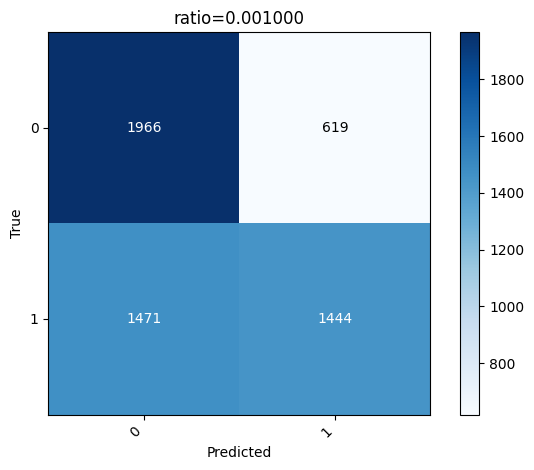

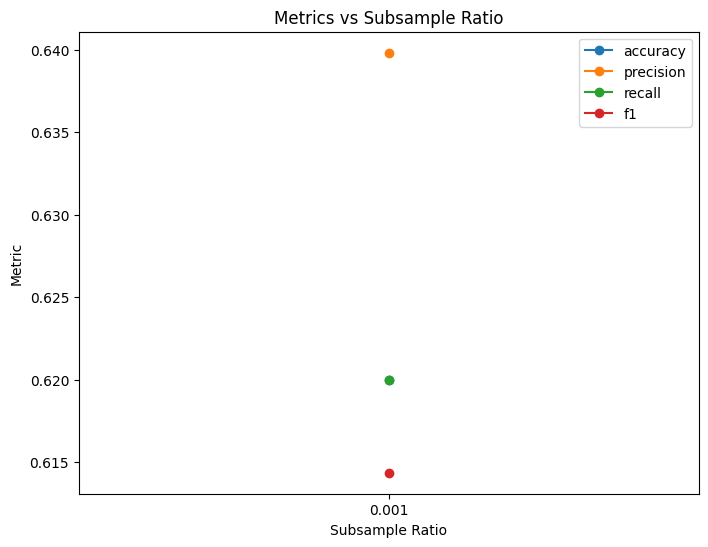

In [12]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_deciles,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.001],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-4,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=False,
    bf16=True,#False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)


=== Processing ratio 0.005 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=285, max=305
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: sixth_decile ; trijet_invariant_mass: ninth_decile ; lepton_missing_energy_mass: fifth_decile ; dijet_lepton_missing_energy_mass: tenth_decile ; bjet_pair_invariant_mass: third_decile ; wboson_bjet_pair_mass: tenth_decile ; wboson_bjet_pair_plus_jet_mass: ninth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: first_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: sixth_decile ; leading_jet_transverse_momentum: tenth_decile ; lepton_transverse_momentum: seventh_decile ; fourth_jet_transverse_momentum: tenth_decile ; subleading_jet_transverse_momentum: tenth_decile</s>
DEBUG: Sample training label: 1
DEBUG: Training data size: 38480
DEBUG: Validation data size: 16492

=

/home/ubuntu/oron/nlp/t5_small_pipeline.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[0.07065281 0.28365192]
 [0.0688643  0.28545934]
 [0.06830647 0.28374174]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [    0 16492]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[-0.01372109  0.16266462]
 [ 0.03300899  0.17796318]
 [ 0.10537031  0.12596266]]
DEBUG: Predictions: [1 1 1 0 1 1 1 1 1 1]
DEBUG: Prediction distribution: [ 2831 13661]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[-0.75954014  0.82047504]
 [-0.138943    0.2792386 ]
 [ 0.3535103   0.05082228]]
DEBUG: Predictions: [1 1 0 0 1 1 1 1 1 1]
DEBUG: Prediction distribution: [ 5843 10649]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[-0.4913869   0.40910685]
 [-0.14221317  0.19517565]
 [ 0.47142032 -0.13776457]]
DEBUG: Predictions: [1 1 0 0 1 1 1 0 1 0]
DEBUG: Prediction distribution: [8362 8130]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[-0.6097151   0.5762384 ]
 [-0.24208415  0.27710727]
 [ 0.5949529  -0.16524382]]
DEBUG: Predictions: [1 1 0 0 1 1 1 0 1 0]
DEBUG: Prediction distribution: [9197 7295]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (16492, 2)
DEBUG: Sample logits: [[-0.67035884  0.6657956 ]
 [-0.3289857   0.35167047]
 [ 0.4518035  -0.10825081]]
DEBUG: Predictions: [1 1 0 0 1 1 1 0 1 0]
DEBUG: Prediction distribution: [8262 8230]
DEBUG: True labels: [1 1 0 0 0 0 0 1 0 0]
DEBUG: True label distribution: [7752 8740]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-0.83136016  0.7917464 ]
 [ 0.1830799  -0.02882263]
 [ 0.74817467 -0.19865674]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [2783 2717]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-0.83136016  0.7917464 ]
 [ 0.1830799  -0.02882263]
 [ 0.74817467 -0.19865674]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [2783 2717]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Final predictions for confusion matrix: [1 0 0 0 1 0 1 0 1 0]
DEBUG: Prediction distribution: [2783 2717]
DEBUG: Final true labels for confusion matrix: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]


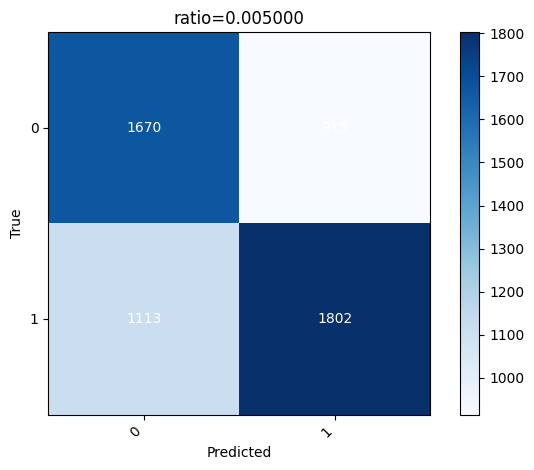

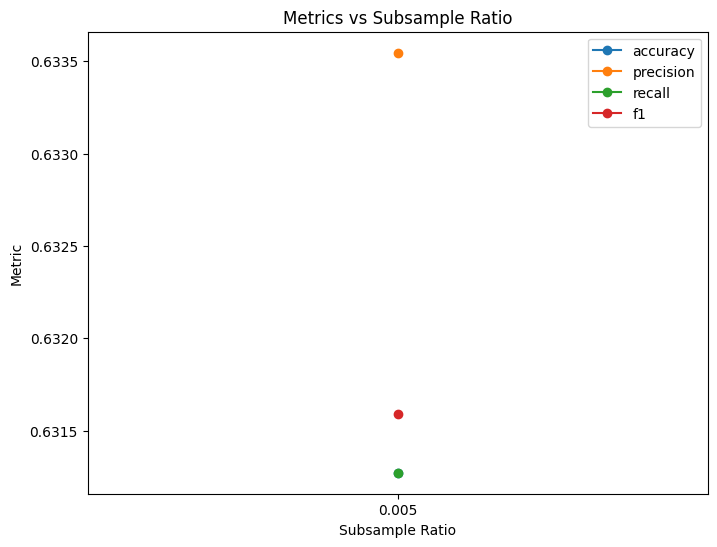

In [16]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_deciles,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.005],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-4,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=False,
    bf16=True,#False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

In [17]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_deciles,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.01],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-4,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=False,
    bf16=True,#False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)


=== Processing ratio 0.01 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=285, max=307
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: third_decile ; trijet_invariant_mass: fourth_decile ; lepton_missing_energy_mass: fifth_decile ; dijet_lepton_missing_energy_mass: tenth_decile ; bjet_pair_invariant_mass: fifth_decile ; wboson_bjet_pair_mass: eighth_decile ; wboson_bjet_pair_plus_jet_mass: eighth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: second_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: tenth_decile ; leading_jet_transverse_momentum: first_decile ; lepton_transverse_momentum: first_decile ; fourth_jet_transverse_momentum: fourth_decile ; subleading_jet_transverse_momentum: second_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 76961
DEBUG: Validation data size: 32984

/home/ubuntu/oron/nlp/t5_small_pipeline.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[ 0.1162794   0.0014183 ]
 [ 0.11526689 -0.00266837]
 [ 0.12007973 -0.00340626]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [32984]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.20357734  0.2695693 ]
 [ 0.00296091  0.07213964]
 [-0.27721456  0.28494525]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [ 7457 25527]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-4.4122288e-01  5.4846334e-01]
 [ 3.0532169e-01 -7.0893182e-04]
 [-6.9267213e-01  7.2153074e-01]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [11853 21131]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.7305695   0.6800599 ]
 [ 0.34979856 -0.09372535]
 [-0.8759701   0.73240155]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [17343 15641]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.43632406  0.3747214 ]
 [-0.04407977  0.06007599]
 [-0.5101056   0.450707  ]]
DEBUG: Predictions: [1 1 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [15154 17830]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.3583066   0.39780608]
 [ 0.38093653 -0.05355446]
 [-0.3425261   0.40161267]]
DEBUG: Predictions: [1 0 1 0 1 1 0 1 0 1]
DEBUG: Prediction distribution: [18732 14252]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 


=== Processing ratio 0.01 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=285, max=307
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: third_decile ; trijet_invariant_mass: fourth_decile ; lepton_missing_energy_mass: fifth_decile ; dijet_lepton_missing_energy_mass: tenth_decile ; bjet_pair_invariant_mass: fifth_decile ; wboson_bjet_pair_mass: eighth_decile ; wboson_bjet_pair_plus_jet_mass: eighth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: second_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: tenth_decile ; leading_jet_transverse_momentum: first_decile ; lepton_transverse_momentum: first_decile ; fourth_jet_transverse_momentum: fourth_decile ; subleading_jet_transverse_momentum: second_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 76961
DEBUG: Validation data size: 32984

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


DEBUG: Pre-training loss: 0.7281
DEBUG: Pre-training logits: tensor([[0.1731, 0.2974],
        [0.2958, 0.3222]])
DEBUG: Pre-training predictions: tensor([1, 1])
DEBUG: Trainable parameters: 1,182,338 / 224,085,890 (0.5%)


/home/ubuntu/oron/nlp/t5_small_pipeline.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[0.16302042 0.06710288]
 [0.16419876 0.06440308]
 [0.16197287 0.06548595]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [32984]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.4219311   0.28199428]
 [-0.0698019   0.08495523]
 [-0.5752363   0.31279203]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [15223 17761]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.87163043  0.4671565 ]
 [ 0.17006505 -0.01095803]
 [-1.0990733   0.5501917 ]]
DEBUG: Predictions: [1 0 1 1 1 1 1 1 0 1]
DEBUG: Prediction distribution: [10822 22162]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.8255003  0.5337084]
 [ 0.9644752 -0.3075893]
 [-0.9396858  0.5314505]]
DEBUG: Predictions: [1 0 1 0 1 1 0 1 0 1]
DEBUG: Prediction distribution: [21284 11700]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.53346646  0.2930858 ]
 [-0.35513946  0.1844164 ]
 [-0.724712    0.35912558]]
DEBUG: Predictions: [1 1 1 0 1 1 1 1 1 1]
DEBUG: Prediction distribution: [11931 21053]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.6383636   0.29002813]
 [ 0.47198525 -0.23728247]
 [-0.5692146   0.20242703]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [18310 14674]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.8074807   0.40081632]
 [ 0.35095158 -0.25925   ]
 [-0.77075136  0.36019668]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [13666 19318]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.93417746  0.6396521 ]
 [ 0.71325004 -0.44223228]
 [-0.80098563  0.5248944 ]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [15251 17733]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.61930853  0.35045183]
 [ 0.49697948 -0.31589565]
 [-0.4563991   0.24057408]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [16184 16800]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.7804067   0.50184345]
 [ 0.6523298  -0.35332143]
 [-0.4214606   0.27122653]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [16079 16905]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.81206506  0.5040854 ]
 [ 0.71154404 -0.4091641 ]
 [-0.4245357   0.24992555]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [17157 15827]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (32984, 2)
DEBUG: Sample logits: [[-0.84864265  0.5546366 ]
 [ 0.7444588  -0.42108604]
 [-0.40760013  0.280077  ]]
DEBUG: Predictions: [1 0 1 0 1 1 1 1 0 1]
DEBUG: Prediction distribution: [15779 17205]
DEBUG: True labels: [1 1 1 0 0 0 1 1 0 1]
DEBUG: True label distribution: [15505 17479]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-1.1023276   0.7019737 ]
 [ 0.49230075 -0.29463214]
 [ 0.97863716 -0.49581492]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 1]
DEBUG: Prediction distribution: [2687 2813]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Raw logits shape: (5500, 2)
DEBUG: Sample logits: [[-1.1023276   0.7019737 ]
 [ 0.49230075 -0.29463214]
 [ 0.97863716 -0.49581492]]
DEBUG: Predictions: [1 0 0 0 1 0 1 0 1 1]
DEBUG: Prediction distribution: [2687 2813]
DEBUG: True labels: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]
DEBUG: Final predictions for confusion matrix: [1 0 0 0 1 0 1 0 1 1]
DEBUG: Prediction distribution: [2687 2813]
DEBUG: Final true labels for confusion matrix: [1 0 1 0 1 1 0 0 1 0]
DEBUG: True label distribution: [2585 2915]


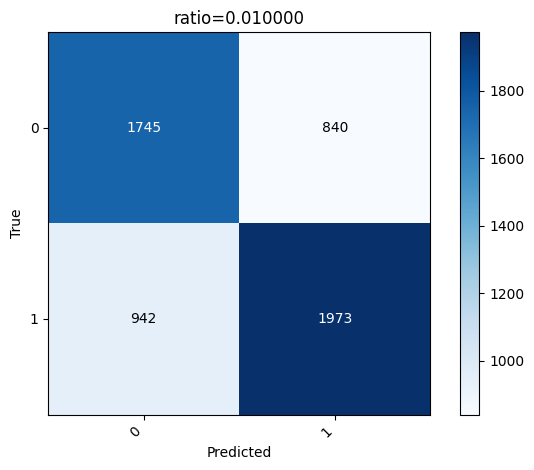

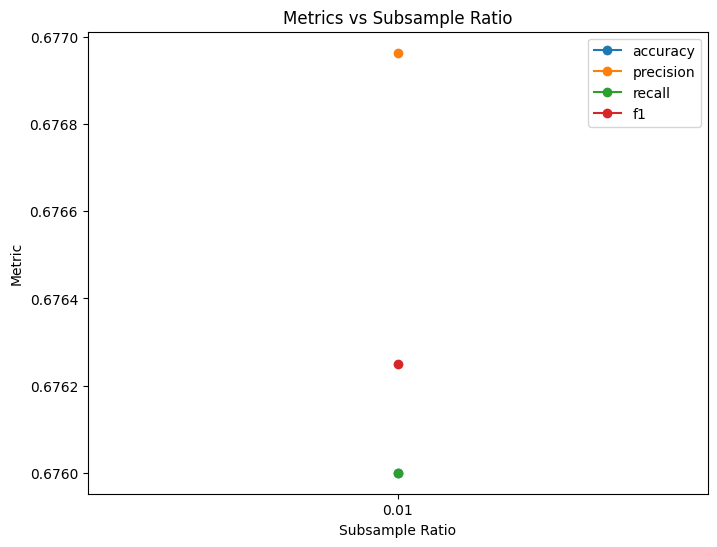

In [9]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_deciles,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.01],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-4,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=True,
    bf16=False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

In [12]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_deciles,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.01],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-3,#5e-4,#5e-5,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=True,
    bf16=False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



=== Processing ratio 0.01 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=285, max=307
DEBUG: Sample training prompt: task: higgs_classification | dijet_invariant_mass: third_decile ; trijet_invariant_mass: fourth_decile ; lepton_missing_energy_mass: fifth_decile ; dijet_lepton_missing_energy_mass: tenth_decile ; bjet_pair_invariant_mass: fifth_decile ; wboson_bjet_pair_mass: eighth_decile ; wboson_bjet_pair_plus_jet_mass: eighth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: second_decile ; fourth_jet_b_tag: first_decile ; missing_transverse_energy: tenth_decile ; leading_jet_transverse_momentum: first_decile ; lepton_transverse_momentum: first_decile ; fourth_jet_transverse_momentum: fourth_decile ; subleading_jet_transverse_momentum: second_decile</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 76961
DEBUG: Validation data size: 32984

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


DEBUG: Pre-training loss: 0.7281
DEBUG: Pre-training logits: tensor([[0.1731, 0.2974],
        [0.2958, 0.3222]])
DEBUG: Pre-training predictions: tensor([1, 1])
DEBUG: Trainable parameters: 1,182,338 / 224,085,890 (0.5%)


/home/ubuntu/oron/nlp/t5_small_pipeline.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_z,                           # ■ full DataFrame of all examples
    label_col='is_higgs_event',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.01],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-4,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=False,
    bf16=True,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=16,#8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.0,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

### Static Sets

#### ALL features raw

In [ ]:
results = run_t5_fused_experiment_sets(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=higgs_df,                           # ■ full DataFrame of all examples
    label_col='label',                 # ■ name of the target column
    task_def='Higgs Classification',
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_sets=['5K'],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    max_length=320,
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=4e-5,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=True,
    bf16=False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.1,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=False,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

#### Top features raw

#### Deciles features

#### Z-score features

#### Scaled features

## LLaMA Fine-tuning

In [36]:
# 2. Call the experiment runner
results = run_llama2_experiment(
    df=higgs_deciles,
    label_col="is_higgs_event",                # name of your binary label column
    test_size=0.005,                     # 20% hold‑out test split
    subsample_ratios=[0.0005], # train on 1%, 10%, and 100% of training data
    val_ratio=0.3,                     # 10% of each subsample for validation

    # — Optional overrides (defaults are reasonable) —
    model_name="meta-llama/Llama-2-7b-hf",
    output_dir="./llama2_output",
    random_state=42,

    # Training schedule
    num_train_epochs=3,
    per_device_train_batch_size=4,#8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,

    # Optimizer & LoRA
    learning_rate=3e-4,
    weight_decay=0.01,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.05,

    # Performance flags
    bf16=True,
    fp16=False,
    gradient_checkpointing=True,
    dataloader_num_workers=8,#4,

    # Logging & checkpointing
    logging_dir="./logs",
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=3,
    early_stopping_patience=2
)

# 3. Inspect your results
#print(results)


=== Processing ratio 0.0005 ===


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA applied. Trainable parameters: 12,597,250 / 6,751,012,866 (0.2%)
DEBUG: token-lengths in this batch -> min=241, max=252
DEBUG: Sample prompt: <s> task: classification | dijet_invariant_mass: sixth_decile ; trijet_invariant_mass: third_decile ; lepton_missing_energy_mass: third_decile ; dijet_lepton_missing_energy_mass: ninth_decile ; bjet_pair_invariant_mass: tenth_decile ; wboson_bjet_pair_mass: tenth_decile ; wboson_bjet_pair_plus_jet_mass: tenth_decile ; leading_jet_b_tag: second_decile ; subleading_jet_b_tag: first_decile ; third_jet_b_tag: first_decile ; fourth_jet_b_tag: second_decile ; missing_transverse_energy: fifth_decile ; leading_jet_transverse_momentum: tenth_decile ; lepton_transverse_momentum: third_decile ; fourth_jet_transverse_momentum: tenth_decile ; subleading_jet_transverse_momentum: fifth_decile
DEBUG: Sample label: 0
DEBUG: Training set size: 382, Validation set size: 165

=== PRE-TRAINING DEBUG ===


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
    # df=higgs_deciles,
    # label_col='is_higgs_event',          # our target column name
    # test_size=0.0005,                    # % of dataset to be held out for test
    # subsample_ratios=[0.0005],           # the list of train‑set fractions to try
    # val_ratio=0.3,                       # % split for validation
    # model_name='t5-base',                # T5 version
    # output_dir='./t5_results',
    # random_state=42,        
    # # below are T5 training kwargs, 
    # num_train_epochs=4,
    # per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # learning_rate=5e-4,#1e-3,
    # logging_steps=50,
    # eval_steps=50,
    # save_total_limit=2,
    # use_lora=True,                      # turn on LoRA
    # lora_r=8,#4,                        # optionally tune these
    # lora_alpha=32,#64,
    # lora_dropout=0.0,#0.1,
    # warmup_steps=100,
    
    # weight_decay=0.01,#0.0,
    # lr_scheduler_type="cosine",
    # gradient_accumulation_steps=2,#4,
    # fp16=True,
    # bf16=False,
    # dataloader_num_workers=4,#8,#4,
    # max_grad_norm=1.0,
    # optim="adamw_torch",

    # label_smoothing_factor = 0.0,
    # adam_beta1 = 0.9,
    # adam_beta2 = 0.999,
    # adam_epsilon = 1e-8,
    # load_best_model_at_end = True,
    # metric_for_best_model = "f1",
    # early_stopping_patience = 3,
    # #save_steps = None,               # default to eval_steps if None
    # #head_dropout = 0.1,
    # #classifier_intermediate_size = None,  # default to hidden_size//2

# Flights Models Training & Inference

## CatBoost Baseline

### Static Sets

#### Post Departure

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.8740, precision=0.8420, recall=0.9208, f1=0.8796, auc=0.9402
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.8886, precision=0.8813, recall=0.8982, f1=0.8897, auc=0.9550
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.9008, precision=0.8940, recall=0.9094, f1=0.9016, auc=0.9563
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.8980, precision=0.9239, recall=0.8674, f1=0.8948, auc=0.9607
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.9114, precision=0.9261, recall=0.8942, f1=0.9098, auc=0.9642
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.9135, precision=0.9330, recall=0.8910, f1=0.9115, auc=0.9682
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.9142, precision=0.9309, recall=0.8948, f1=0.9125, auc=0.9689
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.9189, precision=0.9339, recall=0.9016, f1=0.9175, auc=0.9726
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.9208, precision=0.9385, recall=0.9006, f1=0.9192, auc=0.9738
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.9233, precision=0.9392, recall=0.9052, f1=0.9219, auc=0.9751
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.9235, precision=0.9405, recall=0.9042, f1=0.9220, auc=0.9754


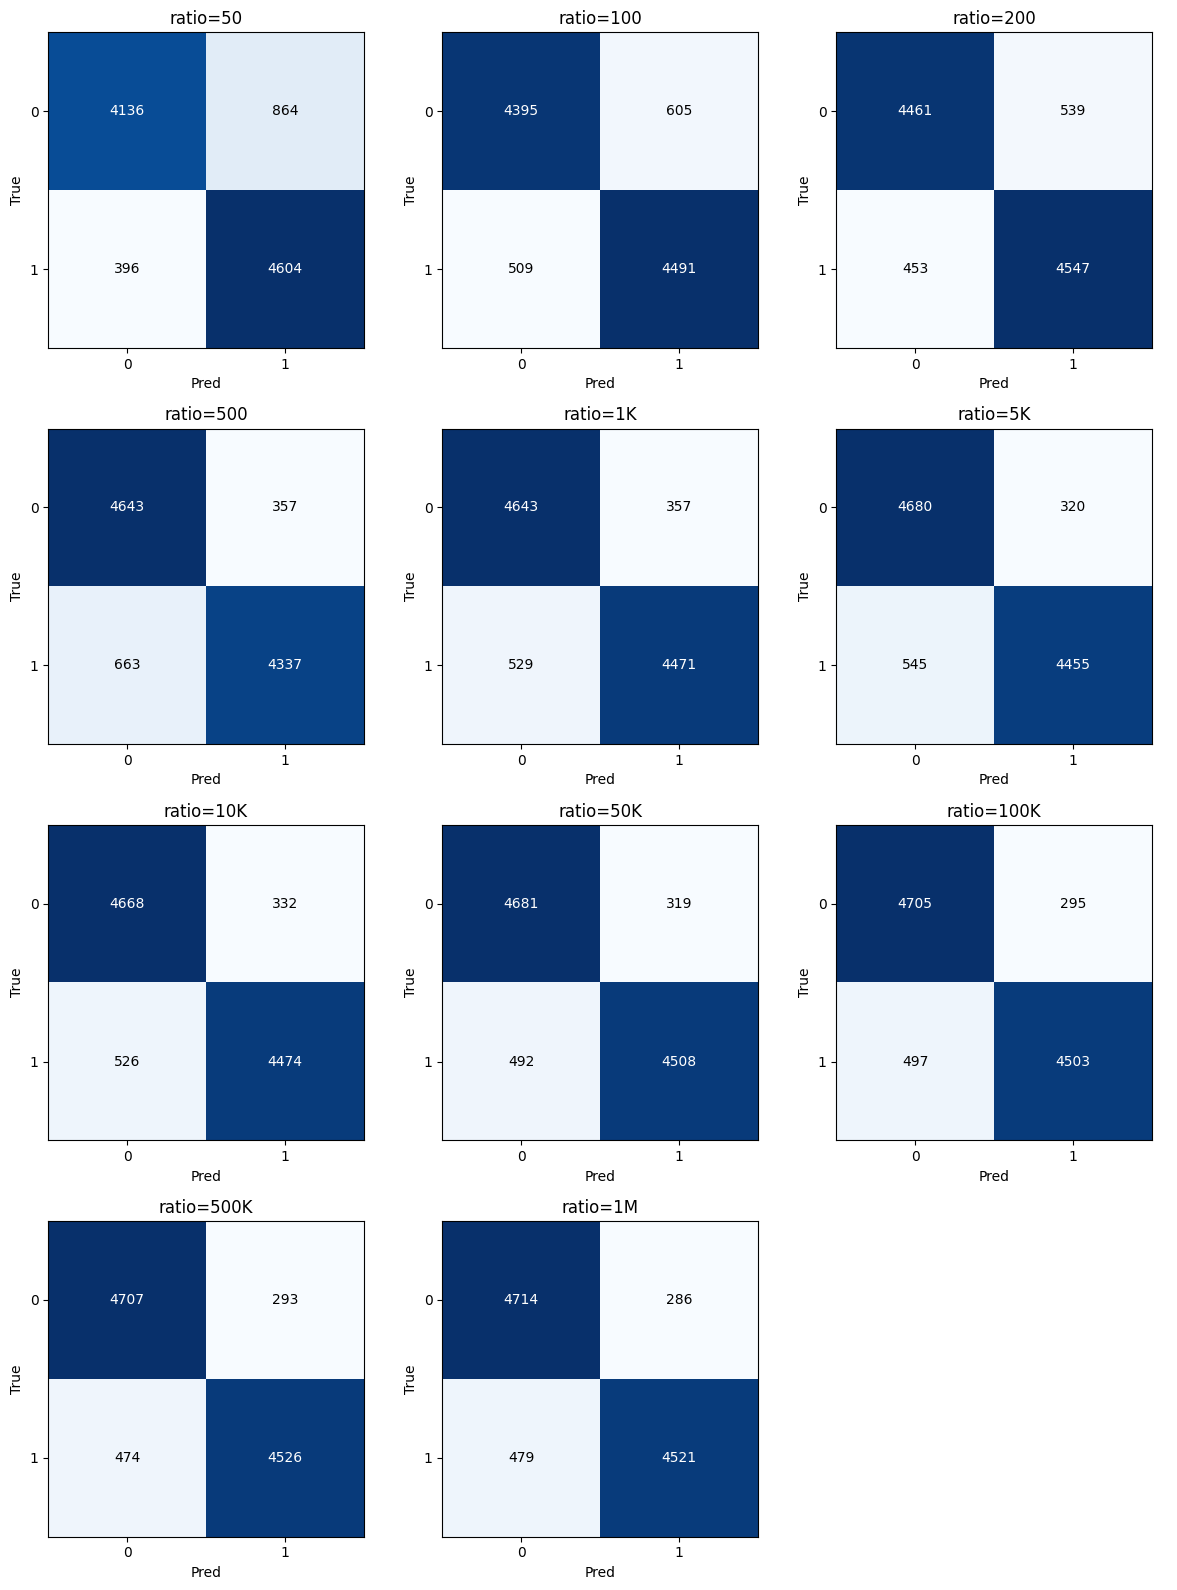

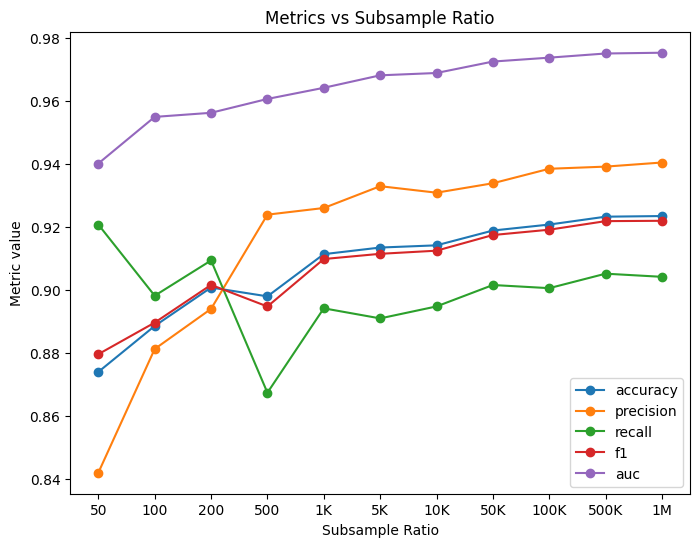


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.8740  0.8886  0.9008  0.8980  0.9114  0.9135  0.9142  0.9189  0.9208  0.9233  0.9235
precision  0.8420  0.8813  0.8940  0.9239  0.9261  0.9330  0.9309  0.9339  0.9385  0.9392  0.9405
recall     0.9208  0.8982  0.9094  0.8674  0.8942  0.8910  0.8948  0.9016  0.9006  0.9052  0.9042
f1         0.8796  0.8897  0.9016  0.8948  0.9098  0.9115  0.9125  0.9175  0.9192  0.9219  0.9220
auc        0.9402  0.9550  0.9563  0.9607  0.9642  0.9682  0.9689  0.9726  0.9738  0.9751  0.9754


In [10]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    "early_stopping_rounds" : 50,
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=flights_post_departure,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Flights Pre Departure

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.4862, precision=0.4829, recall=0.3890, f1=0.4309, auc=0.4723
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.5332, precision=0.5381, recall=0.4686, f1=0.5010, auc=0.5456
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.5335, precision=0.5346, recall=0.5172, f1=0.5258, auc=0.5516
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.5705, precision=0.5731, recall=0.5524, f1=0.5626, auc=0.6026
Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.5847, precision=0.5782, recall=0.6264, f1=0.6013, auc=0.6094
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.6174, precision=0.6168, recall=0.6198, f1=0.6183, auc=0.6553
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.6205, precision=0.6157, recall=0.6412, f1=0.6282, auc=0.6671
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.6425, precision=0.6412, recall=0.6472, f1=0.6442, auc=0.6956
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.6512, precision=0.6508, recall=0.6524, f1=0.6516, auc=0.7075
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.6675, precision=0.6704, recall=0.6590, f1=0.6646, auc=0.7272
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.6753, precision=0.6749, recall=0.6764, f1=0.6757, auc=0.7337


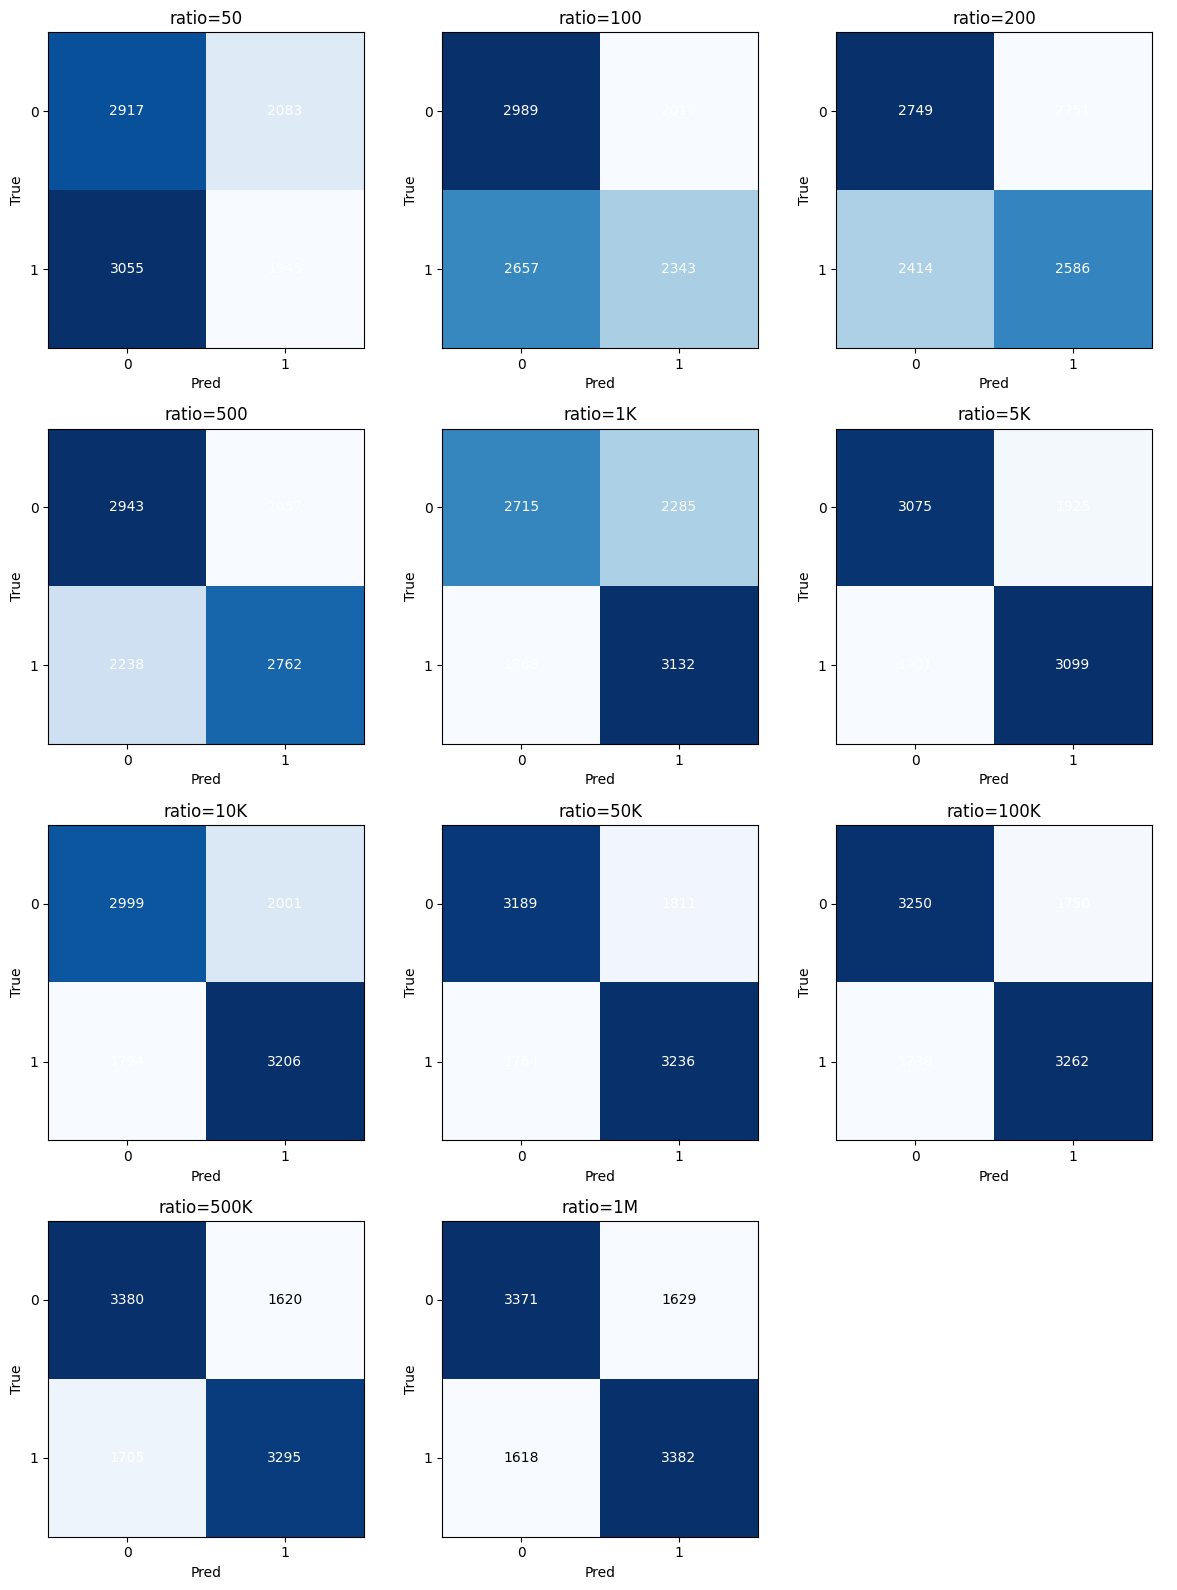

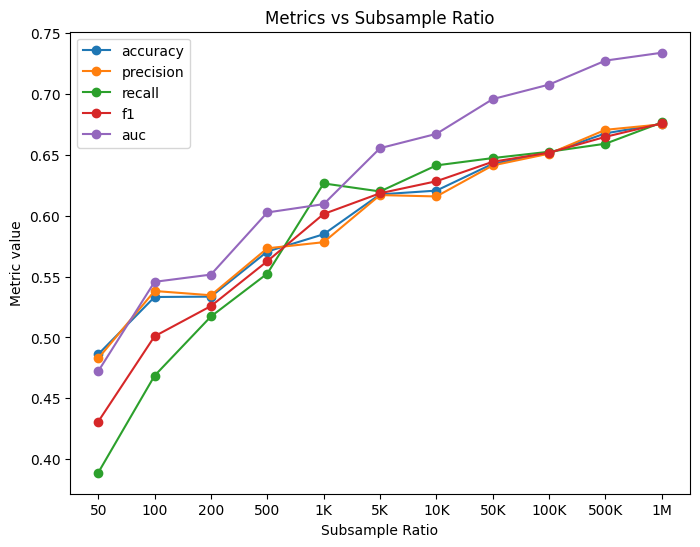


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K     50K    100K    500K      1M
accuracy   0.4862  0.5332  0.5335  0.5705  0.5847  0.6174  0.6205  0.6425  0.6512  0.6675  0.6753
precision  0.4829  0.5381  0.5346  0.5731  0.5782  0.6168  0.6157  0.6412  0.6508  0.6704  0.6749
recall     0.3890  0.4686  0.5172  0.5524  0.6264  0.6198  0.6412  0.6472  0.6524  0.6590  0.6764
f1         0.4309  0.5010  0.5258  0.5626  0.6013  0.6183  0.6282  0.6442  0.6516  0.6646  0.6757
auc        0.4723  0.5456  0.5516  0.6026  0.6094  0.6553  0.6671  0.6956  0.7075  0.7272  0.7337


In [20]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    "early_stopping_rounds" : 50,
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=flights_pre_departure,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500','1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

#### Flights Post Arrival

Learning Curves (ratio=1K, train=1,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000, val=10000, test=10000):
  accuracy=0.9947, precision=0.9911, recall=0.9984, f1=0.9947, auc=0.9995
Learning Curves (ratio=5K, train=5,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=5000, val=10000, test=10000):
  accuracy=0.9963, precision=0.9936, recall=0.9990, f1=0.9963, auc=0.9999
Learning Curves (ratio=10K, train=10,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=10000, val=10000, test=10000):
  accuracy=0.9960, precision=0.9930, recall=0.9990, f1=0.9960, auc=0.9999
Learning Curves (ratio=50K, train=50,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50000, val=10000, test=10000):
  accuracy=0.9981, precision=0.9962, recall=1.0000, f1=0.9981, auc=1.0000
Learning Curves (ratio=100K, train=100,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100000, val=10000, test=10000):
  accuracy=0.9984, precision=0.9968, recall=1.0000, f1=0.9984, auc=1.0000
Learning Curves (ratio=500K, train=500,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500000, val=10000, test=10000):
  accuracy=0.9983, precision=0.9966, recall=1.0000, f1=0.9983, auc=1.0000
Learning Curves (ratio=1M, train=1,000,000, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=1000000, val=10000, test=10000):
  accuracy=0.9984, precision=0.9968, recall=1.0000, f1=0.9984, auc=1.0000


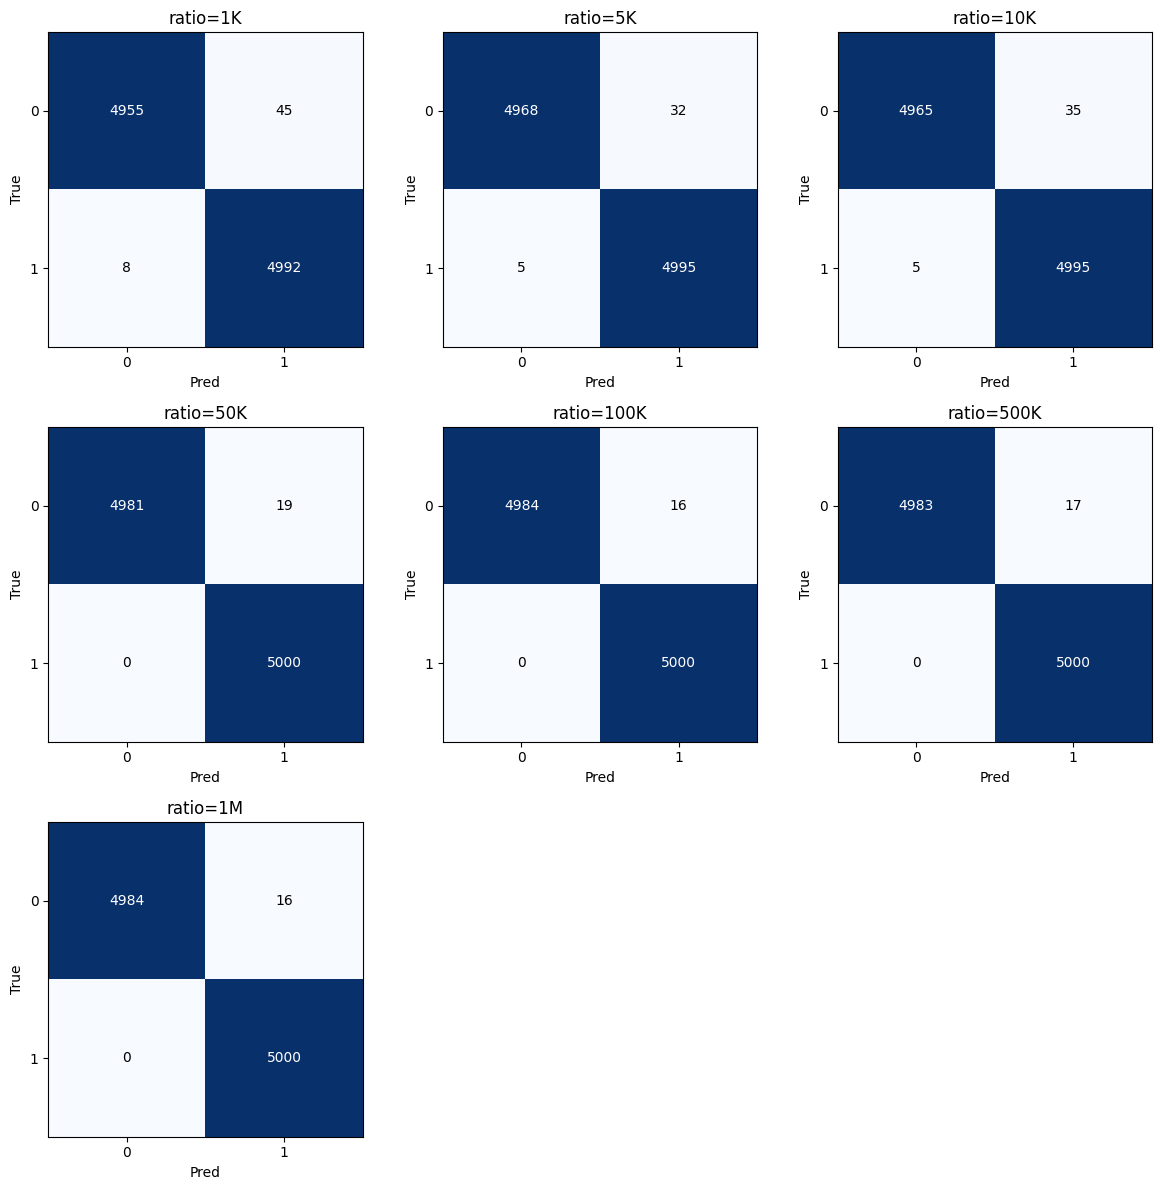

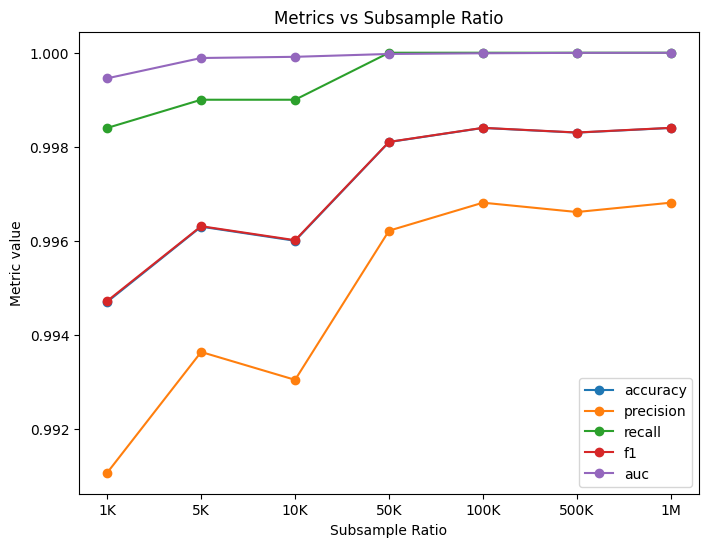


=== Summary table (rows=metrics, cols=subsample sizes) ===
               1K      5K     10K     50K    100K    500K      1M
accuracy   0.9947  0.9963  0.9960  0.9981  0.9984  0.9983  0.9984
precision  0.9911  0.9936  0.9930  0.9962  0.9968  0.9966  0.9968
recall     0.9984  0.9990  0.9990  1.0000  1.0000  1.0000  1.0000
f1         0.9947  0.9963  0.9960  0.9981  0.9984  0.9983  0.9984
auc        0.9995  0.9999  0.9999  1.0000  1.0000  1.0000  1.0000


In [21]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    "early_stopping_rounds" : 50,
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=flights_post_arrival,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['1K','5K','10K','50K','100K','500K','1M'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

Learning Curves (ratio=50, train=50, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=50, val=10000, test=10000):
  accuracy=0.9682, precision=0.9429, recall=0.9968, f1=0.9691, auc=0.9955
Learning Curves (ratio=100, train=100, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=100, val=10000, test=10000):
  accuracy=0.9796, precision=0.9673, recall=0.9928, f1=0.9799, auc=0.9966
Learning Curves (ratio=200, train=200, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=200, val=10000, test=10000):
  accuracy=0.9848, precision=0.9734, recall=0.9968, f1=0.9850, auc=0.9974
Learning Curves (ratio=500, train=500, val=10,000)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test metrics (ratio=None, train=500, val=10000, test=10000):
  accuracy=0.9935, precision=0.9905, recall=0.9966, f1=0.9935, auc=0.9990


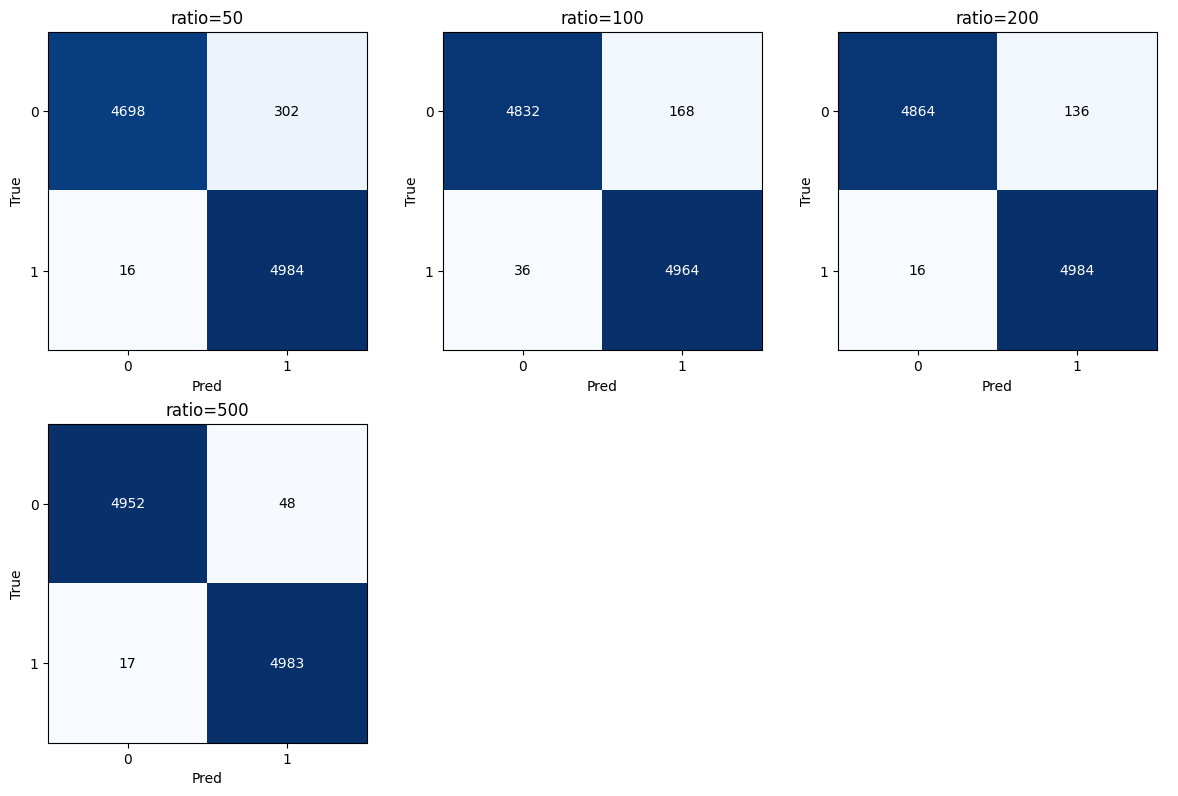

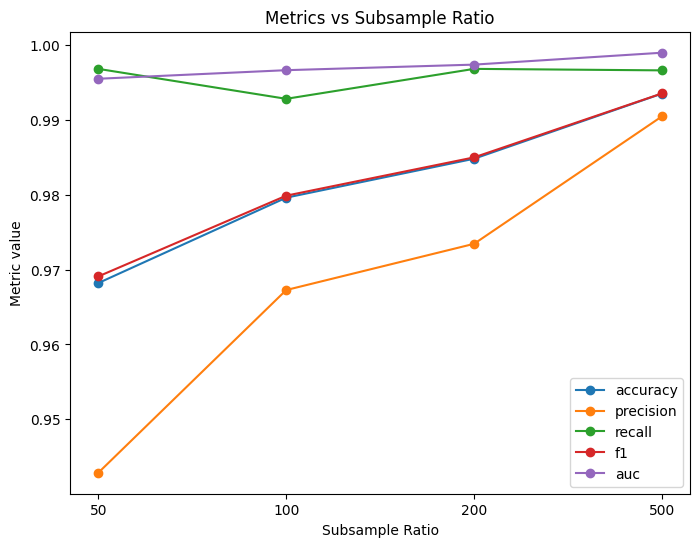


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500
accuracy   0.9682  0.9796  0.9848  0.9935
precision  0.9429  0.9673  0.9734  0.9905
recall     0.9968  0.9928  0.9968  0.9966
f1         0.9691  0.9799  0.9850  0.9935
auc        0.9955  0.9966  0.9974  0.9990


In [29]:
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "early_stopping_rounds": 100,
    "eval_metric": "Logloss",
    "early_stopping_rounds" : 50,
    # turn class balancing on/off here
    "balance": False,          # or omit / set False
    # OR provide explicit class_weights instead:
    # "class_weights": [1, 10],
}

results = run_baseline_experiment_sets(
    df=flights_post_arrival,
    label_col="label",
    test_size=0.1,
    #subsample_ratios=[0.0005, 0.001],
    subsample_sets=['50','100','200','500'],
    val_ratio=0.2,
    catboost_params=params,
    random_state=42,
)

## TabPFN Few-Shot

Test metrics (ratio=1e-05, train=56, val=5,656,811, test=57,141):
  accuracy=0.8512, precision=0.8735, recall=0.8512, f1=0.8047, auc=0.8373
Learning Curves (ratio=1e-05, train=56, val=5,656,811)
Test metrics (ratio=5e-05, train=282, val=5,656,585, test=57,141):
  accuracy=0.9179, precision=0.9174, recall=0.9179, f1=0.9109, auc=0.8952
Learning Curves (ratio=5e-05, train=282, val=5,656,585)
Test metrics (ratio=0.0001, train=565, val=5,656,302, test=57,141):
  accuracy=0.9265, precision=0.9239, recall=0.9265, f1=0.9237, auc=0.9170
Learning Curves (ratio=0.0001, train=565, val=5,656,302)
Test metrics (ratio=0.0005, train=2,828, val=5,654,039, test=57,141):
  accuracy=0.9316, precision=0.9297, recall=0.9316, f1=0.9287, auc=0.9247
Learning Curves (ratio=0.0005, train=2,828, val=5,654,039)
Test metrics (ratio=0.001, train=5,656, val=5,651,211, test=57,141):
  accuracy=0.9334, precision=0.9318, recall=0.9334, f1=0.9303, auc=0.9247
Learning Curves (ratio=0.001, train=5,656, val=5,651,211)


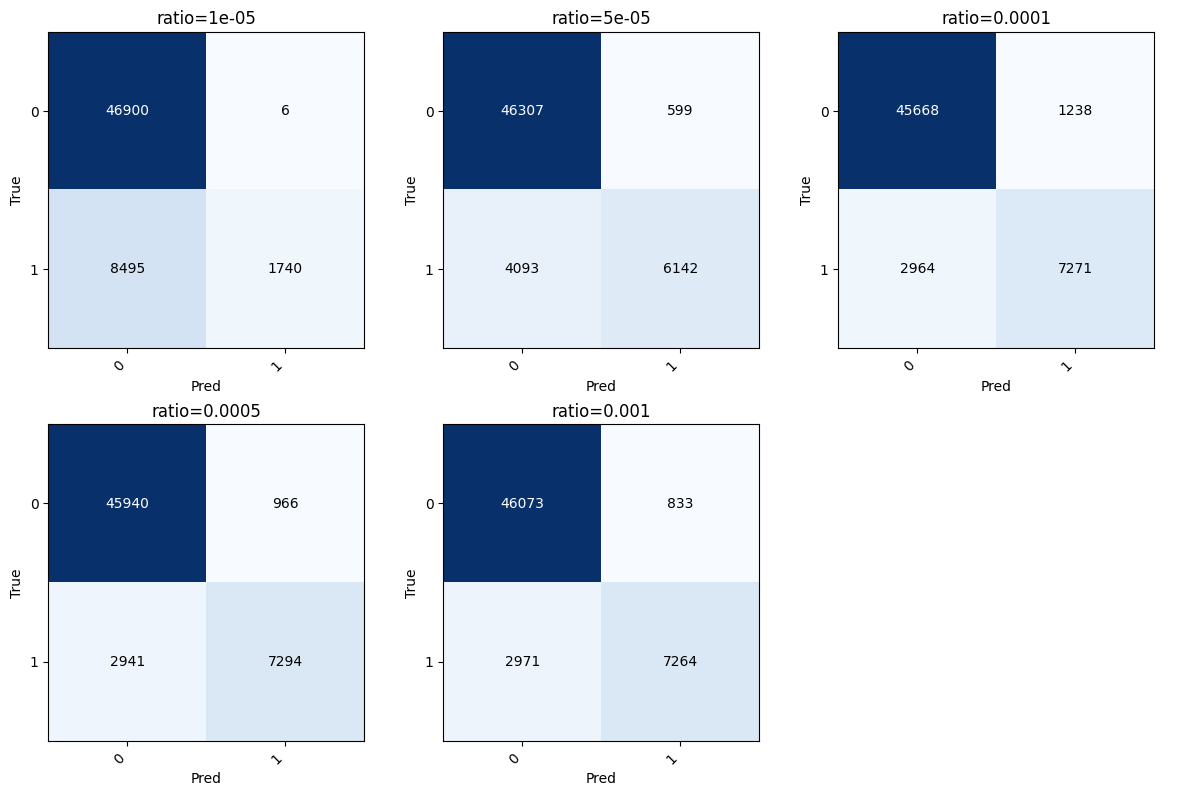

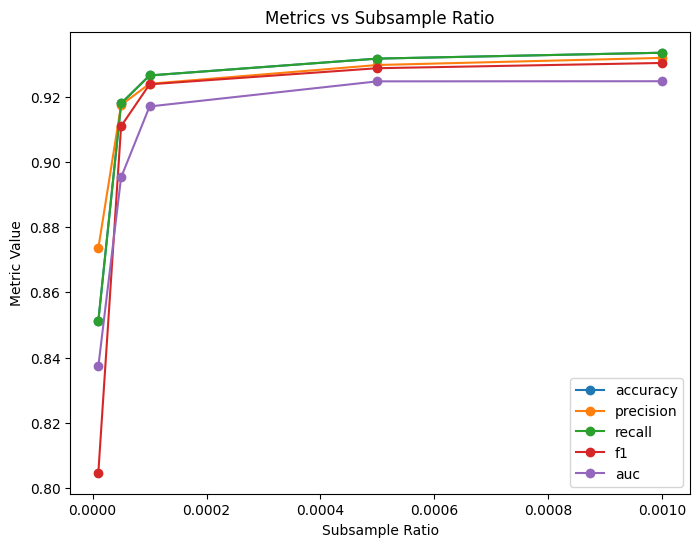

In [44]:
results = run_tabpfn_experiment(
    df=df,
    label_col='label',
    test_size=0.01,
    subsample_ratios=[0.00001, 0.00005, 0.0001, 0.0005, 0.001],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

### Static Sets

#### Flights Post Departure

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.8894, precision=0.8919, recall=0.8894, f1=0.8892, auc=0.9596
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.8932, precision=0.8952, recall=0.8932, f1=0.8931, auc=0.9610
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.8979, precision=0.8999, recall=0.8979, f1=0.8978, auc=0.9623
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.9104, precision=0.9105, recall=0.9104, f1=0.9104, auc=0.9639
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.9117, precision=0.9121, recall=0.9117, f1=0.9117, auc=0.9649
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.9163, precision=0.9170, recall=0.9163, f1=0.9163, auc=0.9684
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.9168, precision=0.9179, recall=0.9168, f1=0.9167, auc=0.9692


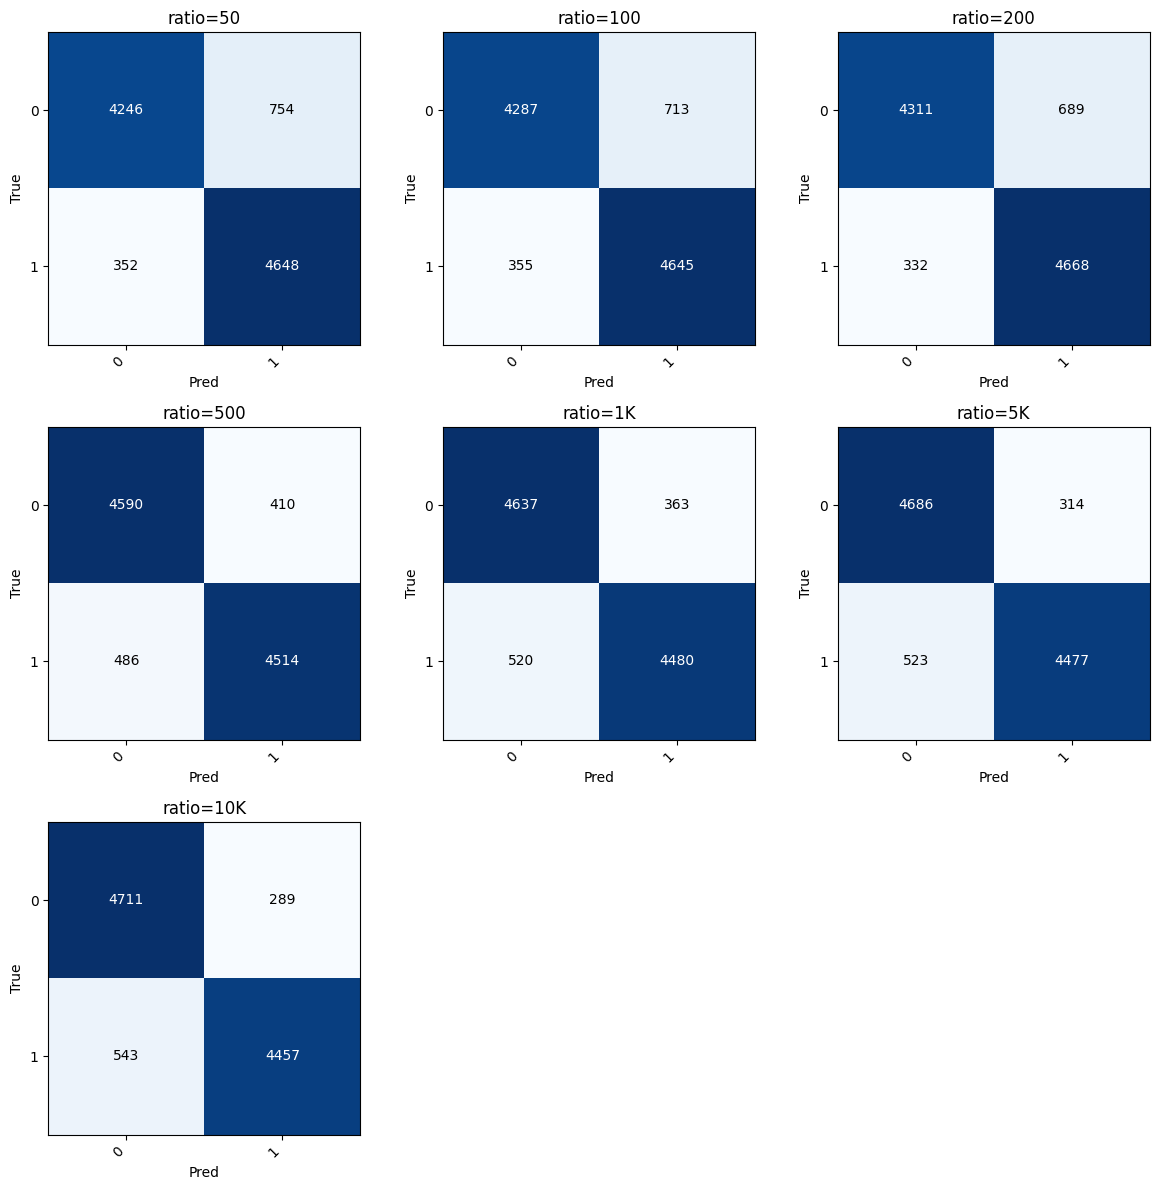

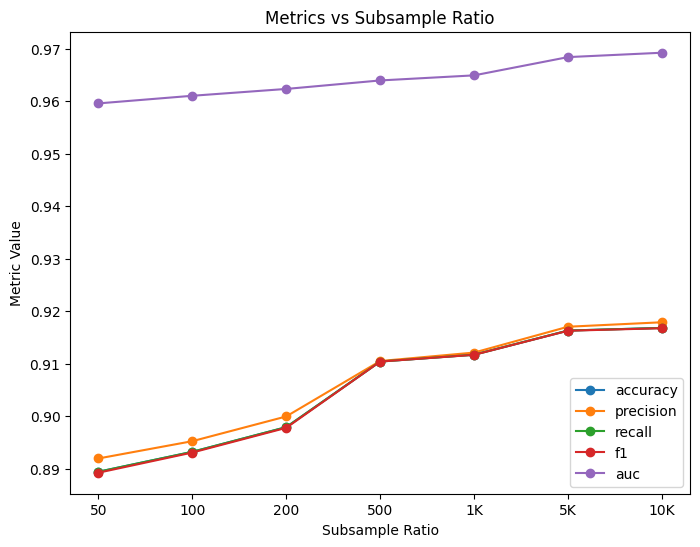


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.8894  0.8932  0.8979  0.9104  0.9117  0.9163  0.9168
precision  0.8919  0.8952  0.8999  0.9105  0.9121  0.9170  0.9179
recall     0.8894  0.8932  0.8979  0.9104  0.9117  0.9163  0.9168
f1         0.8892  0.8931  0.8978  0.9104  0.9117  0.9163  0.9167
auc        0.9596  0.9610  0.9623  0.9639  0.9649  0.9684  0.9692


In [23]:
results = run_tabpfn_experiment_sets(
    df=flights_post_departure,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Flights Pre Departure

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.4660, precision=0.4654, recall=0.4660, f1=0.4636, auc=0.4607
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.5087, precision=0.5138, recall=0.5087, f1=0.4590, auc=0.4969
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.5158, precision=0.5166, recall=0.5158, f1=0.5100, auc=0.5170
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.5914, precision=0.5915, recall=0.5914, f1=0.5913, auc=0.6228
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.6002, precision=0.6031, recall=0.6002, f1=0.5974, auc=0.6311
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.6176, precision=0.6177, recall=0.6176, f1=0.6176, auc=0.6600
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.6314, precision=0.6318, recall=0.6314, f1=0.6311, auc=0.6769


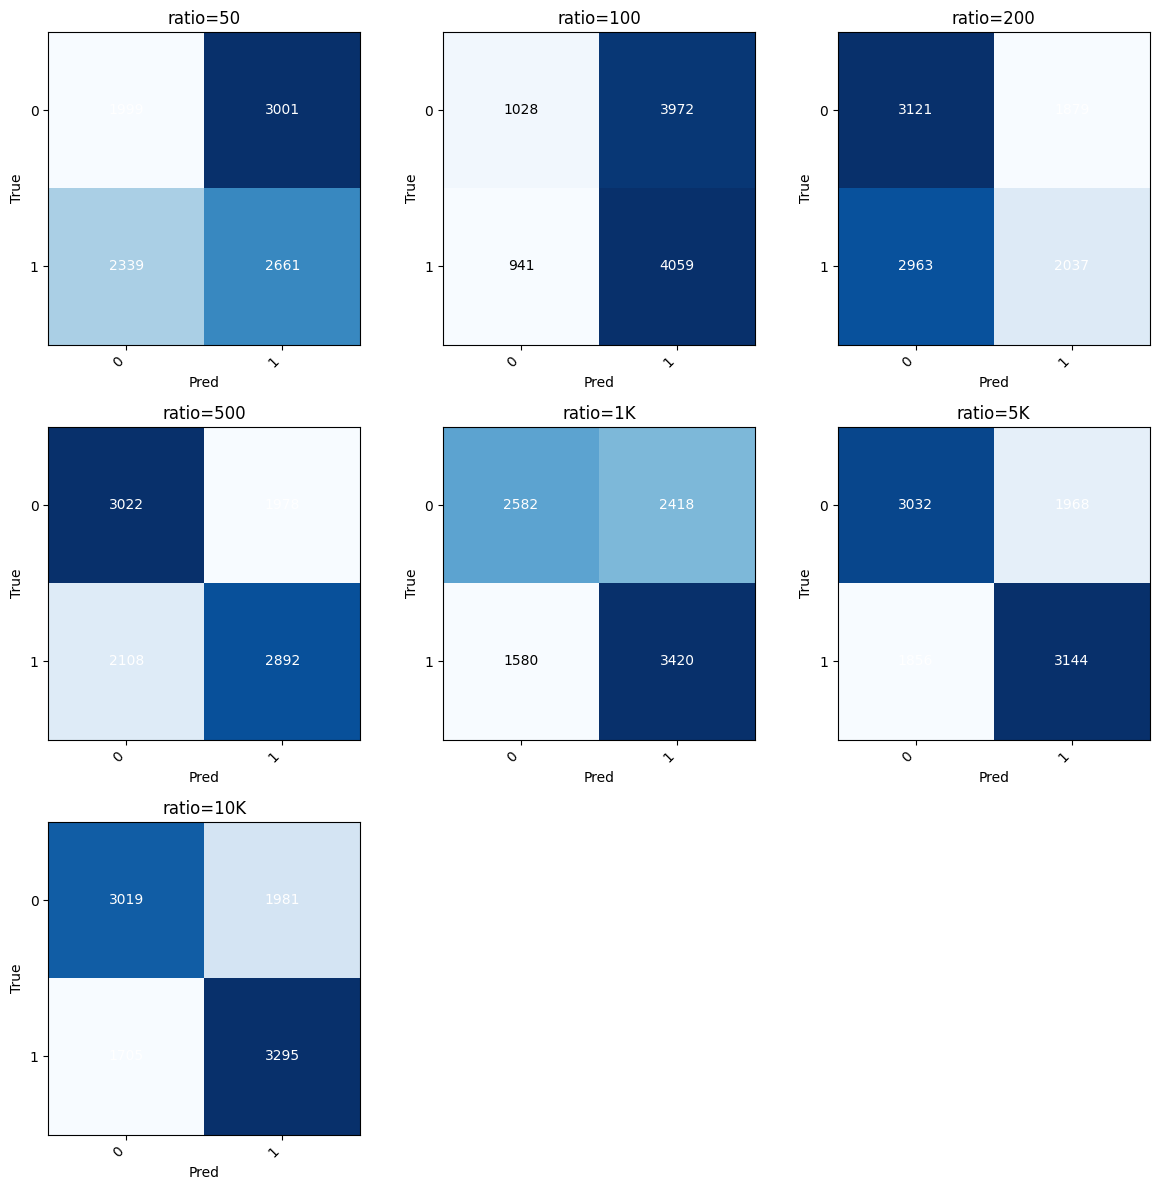

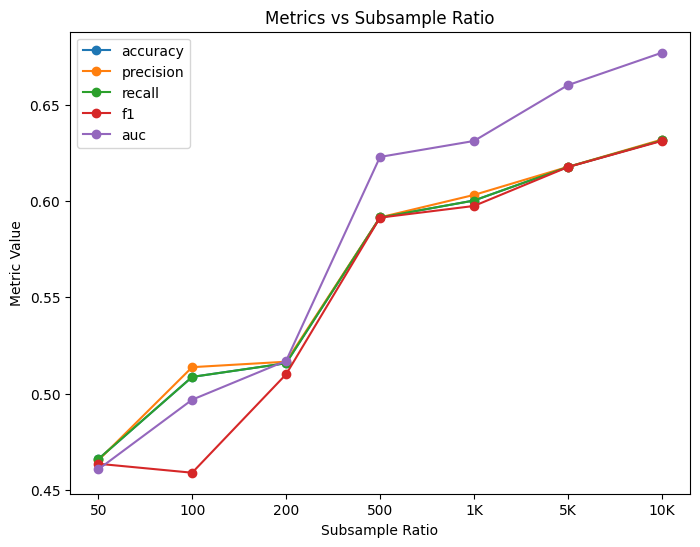


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.4660  0.5087  0.5158  0.5914  0.6002  0.6176  0.6314
precision  0.4654  0.5138  0.5166  0.5915  0.6031  0.6177  0.6318
recall     0.4660  0.5087  0.5158  0.5914  0.6002  0.6176  0.6314
f1         0.4636  0.4590  0.5100  0.5913  0.5974  0.6176  0.6311
auc        0.4607  0.4969  0.5170  0.6228  0.6311  0.6600  0.6769


In [24]:
results = run_tabpfn_experiment_sets(
    df=flights_pre_departure,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

#### Flights Post Arrival

Test metrics (ratio=50, train=50, val=10,000, test=10,000):
  accuracy=0.9930, precision=0.9930, recall=0.9930, f1=0.9930, auc=0.9971
Test metrics (ratio=100, train=100, val=10,000, test=10,000):
  accuracy=0.9933, precision=0.9933, recall=0.9933, f1=0.9933, auc=0.9983
Test metrics (ratio=200, train=200, val=10,000, test=10,000):
  accuracy=0.9930, precision=0.9930, recall=0.9930, f1=0.9930, auc=0.9981
Test metrics (ratio=500, train=500, val=10,000, test=10,000):
  accuracy=0.9950, precision=0.9950, recall=0.9950, f1=0.9950, auc=0.9984
Test metrics (ratio=1K, train=1,000, val=10,000, test=10,000):
  accuracy=0.9950, precision=0.9950, recall=0.9950, f1=0.9950, auc=0.9991
Test metrics (ratio=5K, train=5,000, val=10,000, test=10,000):
  accuracy=0.9957, precision=0.9957, recall=0.9957, f1=0.9957, auc=0.9997
Test metrics (ratio=10K, train=10,000, val=10,000, test=10,000):
  accuracy=0.9956, precision=0.9956, recall=0.9956, f1=0.9956, auc=0.9998


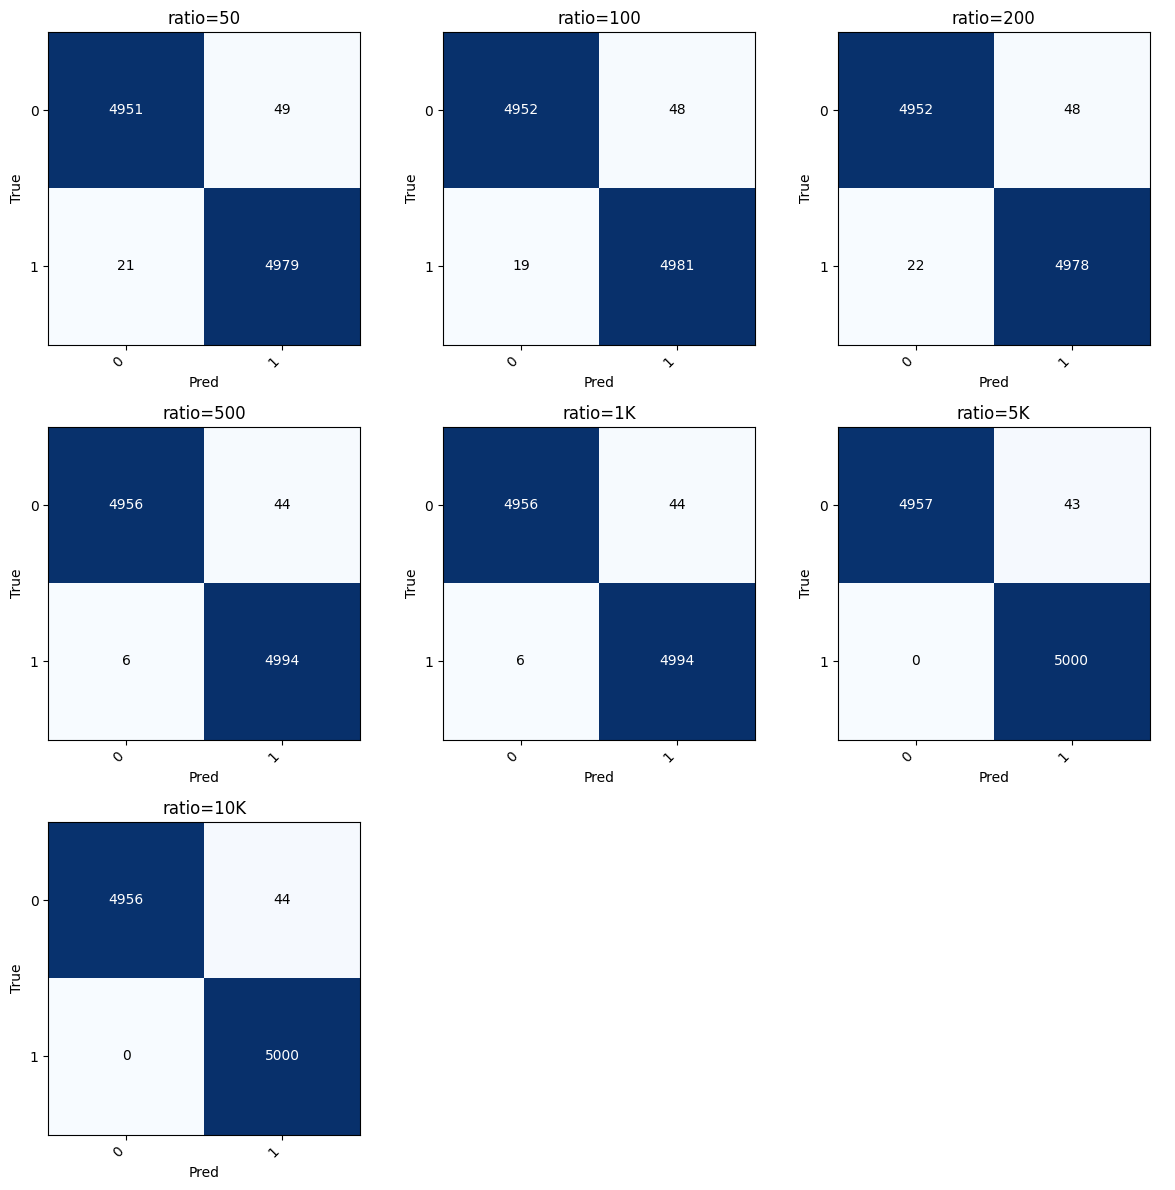

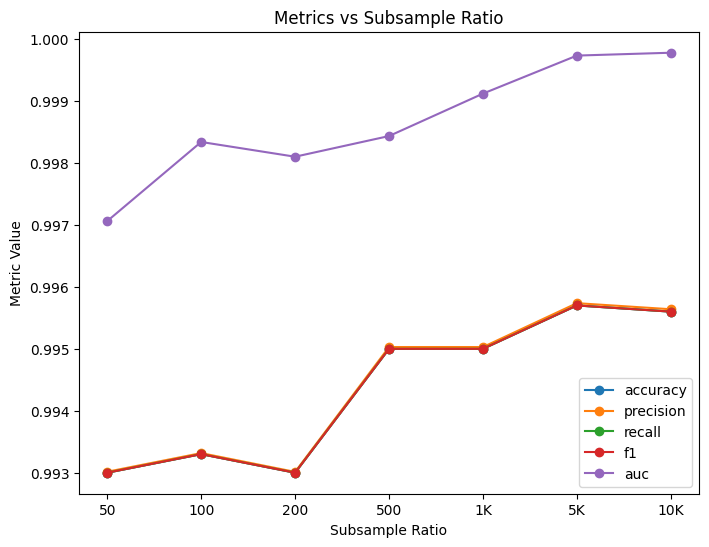


=== Summary table (rows=metrics, cols=subsample sizes) ===
               50     100     200     500      1K      5K     10K
accuracy   0.9930  0.9933  0.9930  0.9950  0.9950  0.9957  0.9956
precision  0.9930  0.9933  0.9930  0.9950  0.9950  0.9957  0.9956
recall     0.9930  0.9933  0.9930  0.9950  0.9950  0.9957  0.9956
f1         0.9930  0.9933  0.9930  0.9950  0.9950  0.9957  0.9956
auc        0.9971  0.9983  0.9981  0.9984  0.9991  0.9997  0.9998


In [22]:
results = run_tabpfn_experiment_sets(
    df=flights_post_arrival,
    label_col='label',
    test_size=None,
    subsample_sets=['50','100','200','500','1K','5K','10K'],
    device='cuda',
    is_classifier=True,
    use_remote=False,
)

## T5 Encoder Head Only Fine-tuning

### Ratios

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio 0.01 ===


/home/ubuntu/oron/nlp/t5_enc_pipeline.py:394: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=39977, val=17134, test=2858):
  accuracy=0.8209, precision=0.6738, recall=0.8209, f1=0.7401, auc=0.5281
Learning Curves (ratio=0.01, train=39,977, val=17,134)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=39977, val=17134, test=2858):
  accuracy=0.8209, precision=0.6738, recall=0.8209, f1=0.7401, auc=0.5344
Learning Curves (ratio=0.01, train=39,977, val=17,134)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=39977, val=17134, test=2858):
  accuracy=0.8209, precision=0.6738, recall=0.8209, f1=0.7401, auc=0.5360
Learning Curves (ratio=0.01, train=39,977, val=17,134)



/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=0.01, train=39977, val=17134, test=2858):
  accuracy=0.8209, precision=0.6738, recall=0.8209, f1=0.7401, auc=0.5338
Learning Curves (ratio=0.01, train=39,977, val=17,134)

Test metrics (ratio=0.01, train=39977, val=17134, test=2858):
  accuracy=0.8209, precision=0.6738, recall=0.8209, f1=0.7401, auc=0.5338
Learning Curves (ratio=0.01, train=39,977, val=17,134)



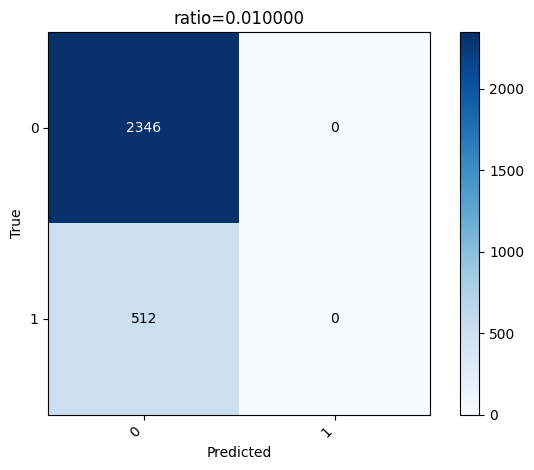

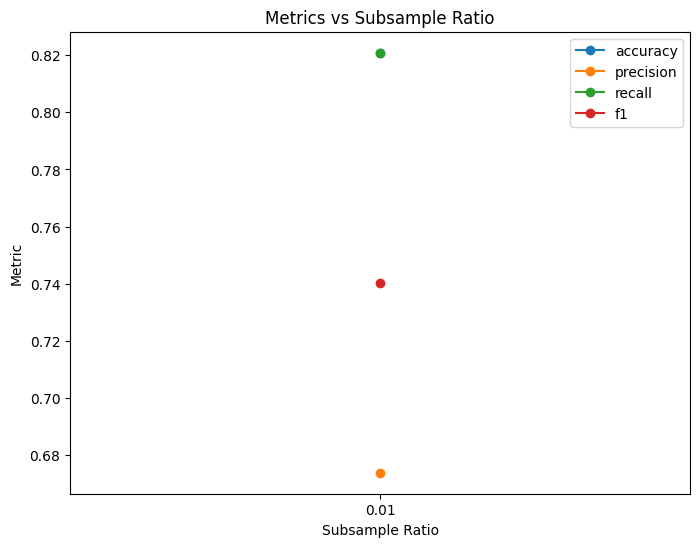

In [42]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment(
    df=df,
    label_col='label',
    task_def='Flight Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_ratios=[0.01],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_flight_delay',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=1e-5,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=False,
    bf16=True,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=320,
)

### Static Sets

In [ ]:
results = run_t5_enc_experiment_sets(
    df=flights_post_departure,
    label_col='label',
    task_def='Flights Delay Classification',
    subsample_sets=['50','100','200','500','1K','5K','10K','50K'],  # train‐set fractions to sweep
    model_name='t5-base',
    output_dir='./t5_flights_post_departure_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=12,
    per_device_train_batch_size=32, #16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    # optimizer & scheduler
    learning_rate=5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,
    dataloader_num_workers=8,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=320,
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=231, max=239
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":4,"AIRLINE":"WN","FLIGHT_NUMBER":266,"TAIL_NUMBER":"N441WN","ORIGIN_AIRPORT":"LGA","DESTINATION_AIRPORT":"MKE","DEPARTURE_TIME":1251.0,"DEPARTURE_DELAY":26.0,"TAXI_OUT":16.0,"WHEELS_OFF":1307.0,"SCHEDULED_TIME":150.0,"DISTANCE":738,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":7,"scheduled_departure_hour":12,"scheduled_departure_minute":25,"scheduled_arrival_hour":13,"scheduled_arrival_minute":55
DEBUG: Sample training label: 1
DEBUG: Training data size: 50
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.9464
DEBUG: Pre-training logits: tensor([[ 0.7709, -0.7087],
        [ 0.7533, -0.7110]])
DEBUG: Pre-training predictions: tensor([0, 0])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test metrics (ratio=50, train=50, val=10000, test=10000):
  accuracy=0.5000, precision=0.2500, recall=0.5000, f1=0.3333, auc=0.5001

=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=230, max=238
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"WN","FLIGHT_NUMBER":988,"TAIL_NUMBER":"N785SW","ORIGIN_AIRPORT":"MCO","DESTINATION_AIRPORT":"PIT","DEPARTURE_TIME":1448.0,"DEPARTURE_DELAY":18.0,"TAXI_OUT":10.0,"WHEELS_OFF":1458.0,"SCHEDULED_TIME":135.0,"DISTANCE":834,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":14,"scheduled_departure_minute":30,"scheduled_arrival_hour":16,"scheduled_arrival_minute":45
DEBUG: Sample training label: 0
DEBUG: Training data size: 100
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.6914
DEBUG: Pre-training logits: tensor

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test metrics (ratio=100, train=100, val=10000, test=10000):
  accuracy=0.4998, precision=0.4974, recall=0.4998, f1=0.3501, auc=0.5032

=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=229, max=238
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"AS","FLIGHT_NUMBER":895,"TAIL_NUMBER":"N596AS","ORIGIN_AIRPORT":"SAN","DESTINATION_AIRPORT":"HNL","DEPARTURE_TIME":1112.0,"DEPARTURE_DELAY":7.0,"TAXI_OUT":30.0,"WHEELS_OFF":1142.0,"SCHEDULED_TIME":374.0,"DISTANCE":2614,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":11,"scheduled_departure_minute":5,"scheduled_arrival_hour":15,"scheduled_arrival_minute":19
DEBUG: Sample training label: 1
DEBUG: Training data size: 200
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.6459
DEBUG: Pre-training logits: tenso

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test metrics (ratio=200, train=200, val=10000, test=10000):
  accuracy=0.5000, precision=0.2500, recall=0.5000, f1=0.3333, auc=0.5112

=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=229, max=238
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":2,"AIRLINE":"EV","FLIGHT_NUMBER":3851,"TAIL_NUMBER":"N13964","ORIGIN_AIRPORT":"IAH","DESTINATION_AIRPORT":"MFE","DEPARTURE_TIME":1057.0,"DEPARTURE_DELAY":24.0,"TAXI_OUT":15.0,"WHEELS_OFF":1112.0,"SCHEDULED_TIME":79.0,"DISTANCE":316,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":5,"scheduled_departure_hour":10,"scheduled_departure_minute":33,"scheduled_arrival_hour":11,"scheduled_arrival_minute":52
DEBUG: Sample training label: 1
DEBUG: Training data size: 500
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.6458
DEBUG: Pre-training logits: tens

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test metrics (ratio=500, train=500, val=10000, test=10000):
  accuracy=0.5000, precision=0.2500, recall=0.5000, f1=0.3333, auc=0.5337

=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=229, max=240
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"AA","FLIGHT_NUMBER":1503,"TAIL_NUMBER":"N3CCAA","ORIGIN_AIRPORT":"FLL","DESTINATION_AIRPORT":"DFW","DEPARTURE_TIME":834.0,"DEPARTURE_DELAY":-6.0,"TAXI_OUT":14.0,"WHEELS_OFF":848.0,"SCHEDULED_TIME":195.0,"DISTANCE":1119,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":40,"scheduled_arrival_hour":10,"scheduled_arrival_minute":55
DEBUG: Sample training label: 0
DEBUG: Training data size: 1000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.7399
DEBUG: Pre-training logits: tens

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test metrics (ratio=1K, train=1000, val=10000, test=10000):
  accuracy=0.5141, precision=0.7281, recall=0.5141, f1=0.3652, auc=0.7375

=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=229, max=241
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"DISTANCE":1269,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.7404
DEBUG: Pre-training logits: tenso

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.8943, precision=0.8955, recall=0.8943, f1=0.8942, auc=0.9536

=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=228, max=241
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":2003,"TAIL_NUMBER":"N940DL","ORIGIN_AIRPORT":"LGA","DESTINATION_AIRPORT":"MIA","DEPARTURE_TIME":701.0,"DEPARTURE_DELAY":-4.0,"TAXI_OUT":16.0,"WHEELS_OFF":717.0,"SCHEDULED_TIME":200.0,"DISTANCE":1096,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":7,"scheduled_departure_minute":5,"scheduled_arrival_hour":10,"scheduled_arrival_minute":25
DEBUG: Sample training label: 0
DEBUG: Training data size: 10000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.9139
DEBUG: Pre-training logits: tensor([[-0.1913,  0.2076],
        [-0.2016,  0.2024]])
DEBUG: Pre-training predictions: tensor([1, 1])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=10K, train=10000, val=10000, test=10000):
  accuracy=0.9048, precision=0.9048, recall=0.9048, f1=0.9048, auc=0.9611

=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=227, max=242
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"UA","FLIGHT_NUMBER":1532,"TAIL_NUMBER":"N77066","ORIGIN_AIRPORT":"SFO","DESTINATION_AIRPORT":"DEN","DEPARTURE_TIME":550.0,"DEPARTURE_DELAY":19.0,"TAXI_OUT":15.0,"WHEELS_OFF":605.0,"SCHEDULED_TIME":146.0,"DISTANCE":967,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":5,"scheduled_departure_minute":31,"scheduled_arrival_hour":8,"scheduled_arrival_minute":57
DEBUG: Sample training label: 1
DEBUG: Training data size: 50000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.5296
DEBUG: Pre-training logits: tensor([[0.0058, 0.3711],
        [0.0084, 0.3615]])
DEBUG: Pre-training predictions: tensor([1, 1])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:451: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [6]:
# ─── 0) Restart your kernel and run *only* this cell first ────────────

# 1) Force 'spawn' at the torch.multiprocessing level
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

# 2) Patch the exact function notebook_launcher will call
import accelerate.launchers
from torch.multiprocessing import start_processes as _orig_start_processes

def _spawn_only_start(fn, args=(), nprocs=None, join=True, daemon=None, start_method=None):
    # ignore the fork that accelerate hard-codes, force spawn
    return _orig_start_processes(
        fn,
        args=args,
        nprocs=nprocs,
        join=join,
        daemon=daemon,
        start_method="spawn",
    )

# overwrite the name accelerate.notebook_launcher will use
accelerate.launchers.start_processes = _spawn_only_start

# 3) Pin CPU threads & disable HF-tokenizer threading
import os
os.environ["ACCELERATE_SKIP_DEVICE_INIT_CHECK"] = "1"
os.environ["OMP_NUM_THREADS"]        = "1"
os.environ["MKL_NUM_THREADS"]        = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
torch.set_num_threads(1)
# (do NOT call torch.set_num_interop_threads here)

# ─── 4) Now it’s safe to import accelerate and your train fn ─────────
from accelerate import notebook_launcher

def _train_fn(args):
    return run_t5_enc_experiment_sets(**args)

# ─── 6) Prepare your args dict (unchanged) ───────────────────────────
args = {
    "df":                         flights_post_departure,
    "label_col":                  "label",
    "task_def":                   "Flights Delay Classification",
    "subsample_sets":             ["50","100","200","500","1K","5K","10K","50K"],
    "model_name":                 "t5-base",
    "output_dir":                 "./t5_flights_post_departure_t5_enc",
    "random_state":               42,
    "num_train_epochs":           12,
    "per_device_train_batch_size":32,
    "per_device_eval_batch_size": 32,
    "gradient_accumulation_steps":1,
    "learning_rate":              5e-4,
    "weight_decay":               0.01,
    "optim":                      "adamw_torch",
    "lr_scheduler_type":          "linear",
    "warmup_ratio":               0.1,
    "fp16":                       True,
    "bf16":                       False,
    "dataloader_num_workers":     8,
    "use_lora":                   True,
    "lora_r":                     8,
    "lora_alpha":                 32,
    "lora_dropout":               0.0,
    "eval_strategy":              "steps",
    "eval_steps":                 200,
    "logging_strategy":           "steps",
    "logging_steps":              50,
    "save_steps":                 None,
    "save_total_limit":           2,
    "overwrite_output_dir":       True,
    "save_safetensors":           False,
    "load_best_model_at_end":     False,
    "metric_for_best_model":      "f1",
    "greater_is_better":          True,
    "early_stopping_patience":    3,
    "max_length":                 320,
}


# ─── 7) Launch across your 8 GPUs (now using spawn) ───────────────────
results = notebook_launcher(_train_fn, args=(args,), num_processes=8)
print(results)

Launching training on 8 CUDAs.


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using the default legacy behaviour of the <class 'transformers.model


=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===


The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
W0808 14:36:47.960000 95000 torch/multiprocessing/spawn.py:169] Terminating process 95295 via signal SIGTERM
W0

ChildFailedError: 
============================================================
_train_fn FAILED
------------------------------------------------------------
Failures:
  <NO_OTHER_FAILURES>
------------------------------------------------------------
Root Cause (first observed failure):
[0]:
  time      : 2025-08-08_14:36:47
  host      : ip-10-207-90-215
  rank      : 0 (local_rank: 0)
  exitcode  : 1 (pid: 95292)
  error_file: /tmp/torchelastic_x5motgzl/none_0ne711n6/attempt_0/0/error.json
  traceback : Traceback (most recent call last):
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/distributed/elastic/multiprocessing/errors/__init__.py", line 355, in wrapper
      return f(*args, **kwargs)
    File "/tmp/ipykernel_95000/3240616742.py", line 40, in _train_fn
      return run_t5_enc_experiment_sets(**args)
    File "/home/ubuntu/oron/nlp/t5_enc_pipeline_sets_optim.py", line 369, in run_t5_enc_experiment_sets
      classifier.model = get_peft_model(classifier.model, peft_config)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/mapping_func.py", line 125, in get_peft_model
      return MODEL_TYPE_TO_PEFT_MODEL_MAPPING[peft_config.task_type](
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/peft_model.py", line 1586, in __init__
      super().__init__(model, peft_config, adapter_name, **kwargs)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/peft_model.py", line 130, in __init__
      self.base_model = cls(model, {adapter_name: peft_config}, adapter_name)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/lora/model.py", line 143, in __init__
      super().__init__(model, config, adapter_name, low_cpu_mem_usage=low_cpu_mem_usage)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/tuners_utils.py", line 203, in __init__
      self.inject_adapter(self.model, adapter_name, low_cpu_mem_usage=low_cpu_mem_usage)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/tuners_utils.py", line 531, in inject_adapter
      self._create_and_replace(peft_config, adapter_name, target, target_name, parent, current_key=key)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/lora/model.py", line 240, in _create_and_replace
      new_module = self._create_new_module(lora_config, adapter_name, target, device_map=device_map, **kwargs)
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/lora/model.py", line 321, in _create_new_module
      from .bnb import dispatch_bnb_8bit
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/peft/tuners/lora/bnb.py", line 19, in <module>
      import bitsandbytes as bnb
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/bitsandbytes/__init__.py", line 19, in <module>
      from .nn import modules
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/bitsandbytes/nn/__init__.py", line 21, in <module>
      from .triton_based_modules import (
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/bitsandbytes/nn/triton_based_modules.py", line 6, in <module>
      from bitsandbytes.triton.dequantize_rowwise import dequantize_rowwise
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/bitsandbytes/triton/dequantize_rowwise.py", line 7, in <module>
      if not is_triton_available():
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/bitsandbytes/triton/triton_utils.py", line 10, in is_triton_available
      return has_triton_package() and has_triton()
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/utils/_triton.py", line 95, in has_triton
      return is_device_compatible_with_triton()
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/utils/_triton.py", line 91, in is_device_compatible_with_triton
      if device_interface.is_available() and extra_check(device_interface):
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/utils/_triton.py", line 72, in cuda_extra_check
      return device_interface.Worker.get_device_properties().major >= 7
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/_dynamo/device_interface.py", line 209, in get_device_properties
      device = CudaInterface.Worker.current_device()
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/_dynamo/device_interface.py", line 198, in current_device
      return torch.cuda.current_device()
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/cuda/__init__.py", line 1026, in current_device
      _lazy_init()
    File "/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/cuda/__init__.py", line 358, in _lazy_init
      raise RuntimeError(
  RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
  
============================================================

### Previous Experiments

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.8654, precision=0.8916, recall=0.8654, f1=0.8631, auc=0.9967


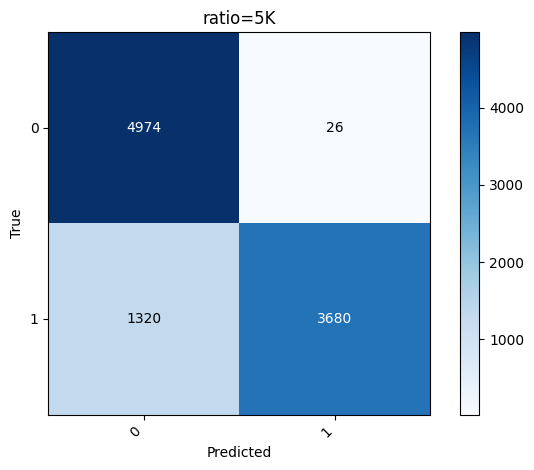

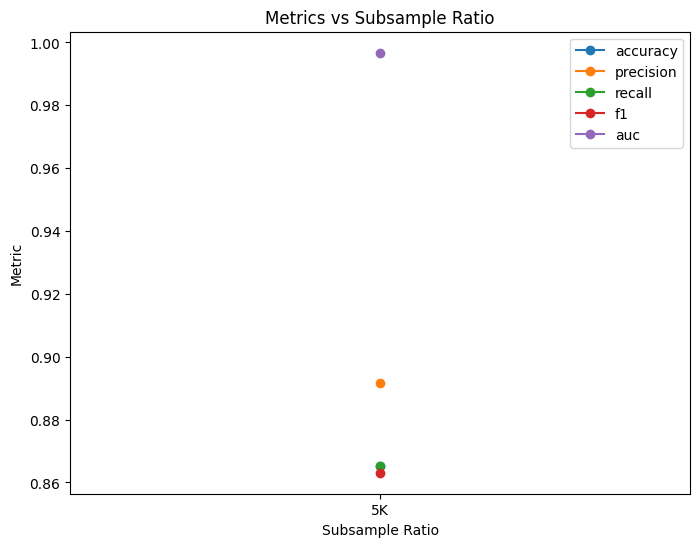

In [9]:
# flights with features known PRE-ARRIVAL ONLY
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=5e-4,#1e-5,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG =

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.5000, precision=0.2500, recall=0.5000, f1=0.3333, auc=0.6354


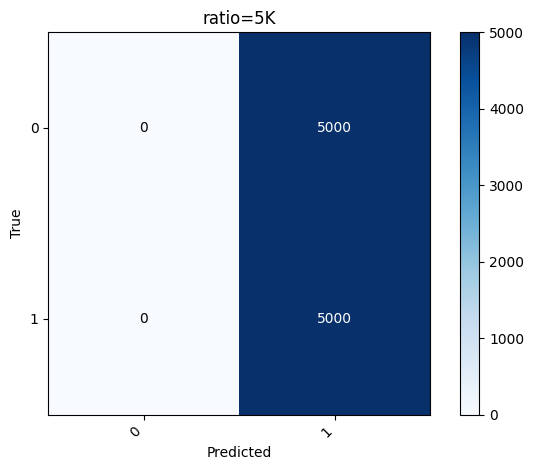

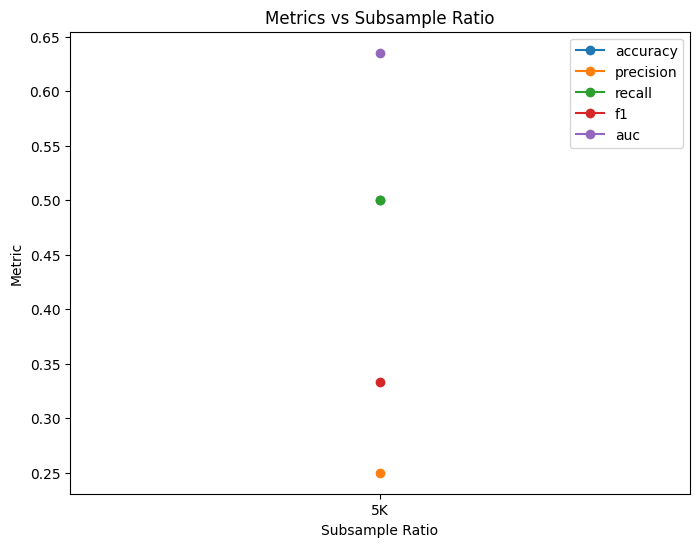

In [10]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=1e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG =

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.9232, precision=0.9316, recall=0.9232, f1=0.9228, auc=0.9951


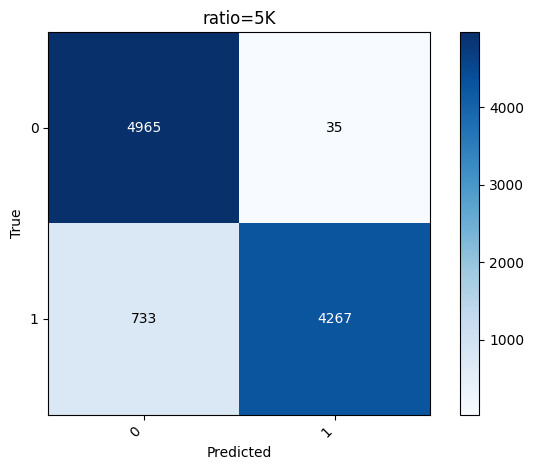

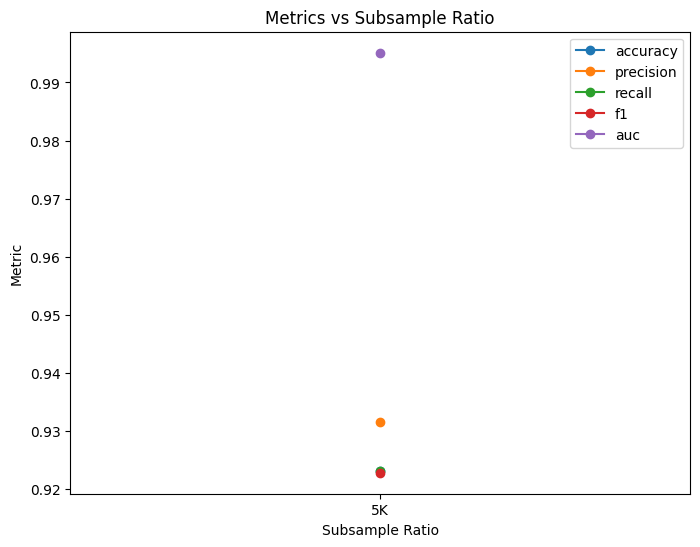

In [11]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=3e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)


=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.8109, precision=0.8605, recall=0.8109, f1=0.8042, auc=0.9968


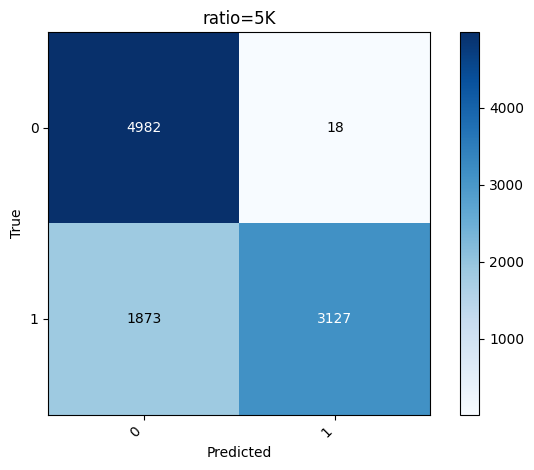

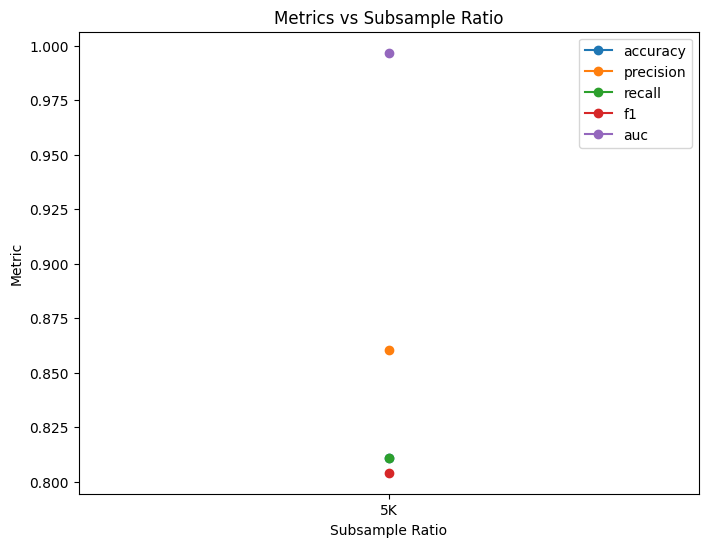

In [12]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=4e-4,#3e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG =

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.7035, precision=0.7995, recall=0.7035, f1=0.6777, auc=0.9289


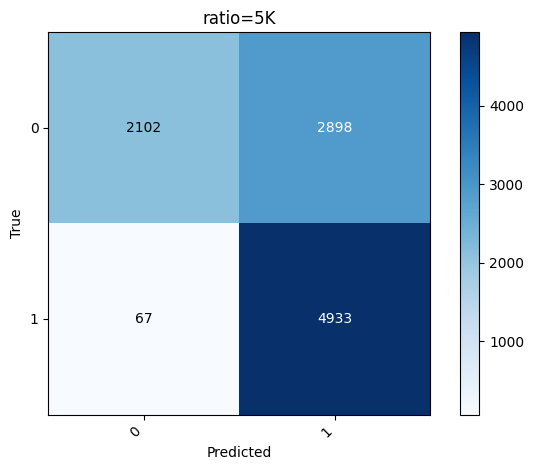

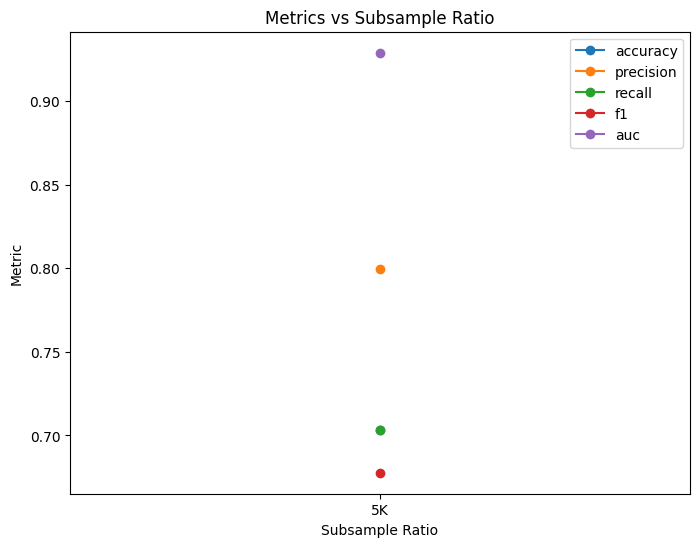

In [13]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # optimizer & scheduler
    learning_rate=2e-4,#4e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG =

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.9831, precision=0.9832, recall=0.9831, f1=0.9831, auc=0.9970


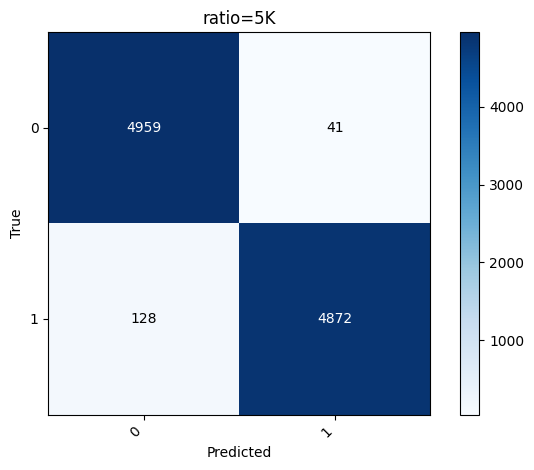

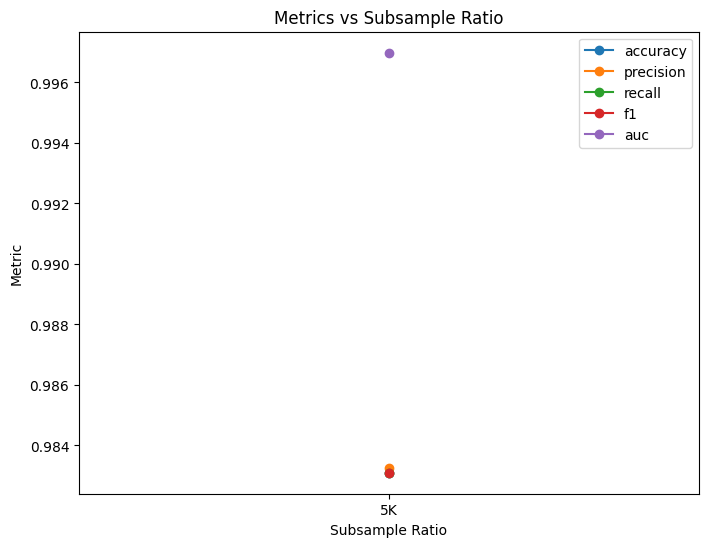

In [16]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, #2,

    # optimizer & scheduler
    learning_rate=3e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=333, max=349
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"ELAPSED_TIME":172.0,"AIR_TIME":140.0,"DISTANCE":1269,"WHEELS_ON":1241.0,"TAXI_IN":6.0,"ARRIVAL_TIME":1247.0,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","AIR_SYSTEM_DELAY":0.0,"SECURITY_DELAY":0.0,"AIRLINE_DELAY":0.0,"LATE_AIRCRAFT_DELAY":0.0,"WEATHER_DELAY":0.0,"month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG =

/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.8170, precision=0.8631, recall=0.8170, f1=0.8110, auc=0.9969


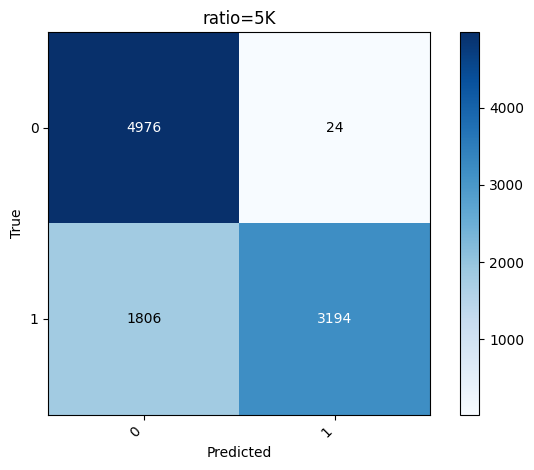

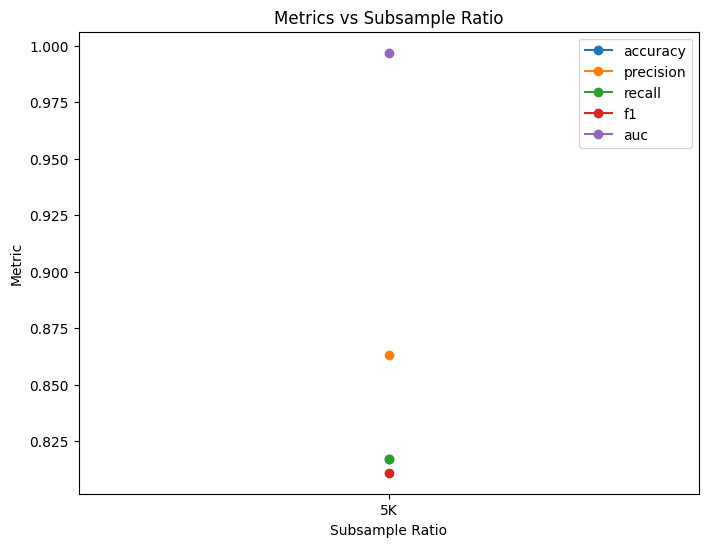

In [17]:
# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, #2,

    # optimizer & scheduler
    learning_rate=3e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1, #0.0,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=229, max=241
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","DEPARTURE_TIME":755.0,"DEPARTURE_DELAY":-5.0,"TAXI_OUT":26.0,"WHEELS_OFF":821.0,"SCHEDULED_TIME":176.0,"DISTANCE":1269,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.2075
DEBUG: Pre-training logits: tensor([[ 0.7717, -0.7127],
        [ 0.7461, -0.7041]])
DEBUG: Pre-training predictions: tensor([0, 0])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.7960, precision=0.8168, recall=0.7960, f1=0.7926, auc=0.9086


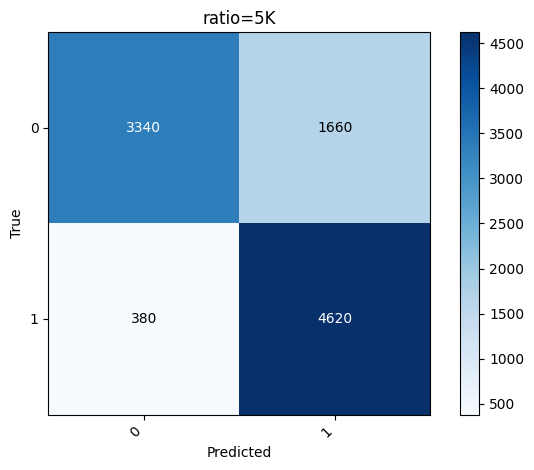

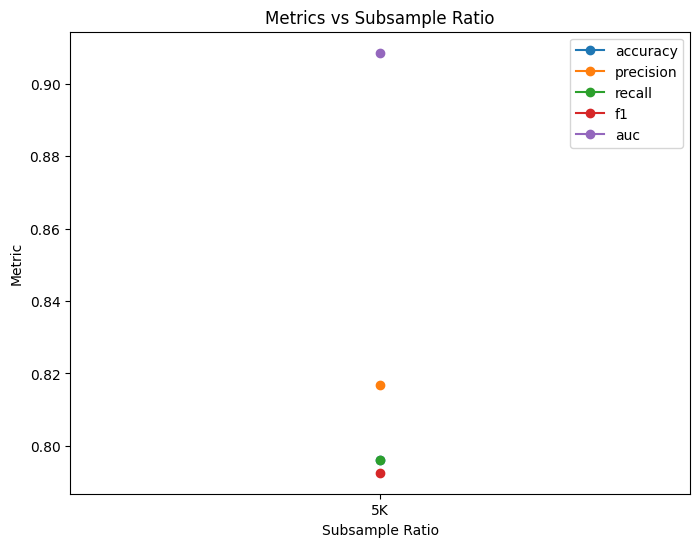

In [24]:
# Flights df with features that are known only PRE-ARRIVAL

# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, #2,

    # optimizer & scheduler
    learning_rate=3e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=420,
)


=== Processing ratio None ===


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=187, max=196
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","SCHEDULED_TIME":176.0,"DISTANCE":1269,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.1863
DEBUG: Pre-training logits: tensor([[ 0.8983, -0.7138],
        [ 0.8731, -0.6872]])
DEBUG: Pre-training predictions: tensor([0, 0])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.5049, precision=0.6116, recall=0.5049, f1=0.3494, auc=0.5497


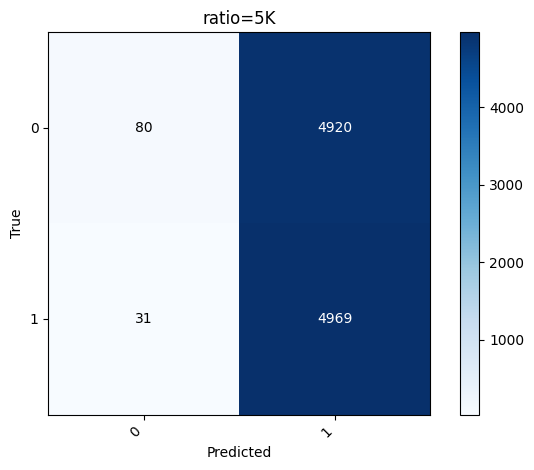

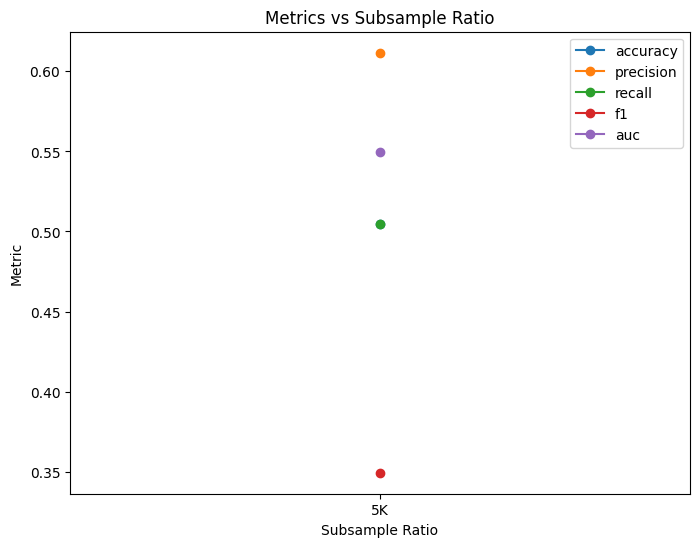

In [31]:
# Flights df with features that are known only PRE-DEPARTURE

# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, #2,

    # optimizer & scheduler
    learning_rate=3e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=220,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Processing ratio None ===
LoRA applied. Trainable parameters:
  Total: 224,380,418
  Trainable: 884,736 (0.4%)
DEBUG: token-lengths in this batch → min=187, max=196
DEBUG: Sample training prompt: Flights Delay Classification | "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","SCHEDULED_TIME":176.0,"DISTANCE":1269,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.1863
DEBUG: Pre-training logits: tensor([[ 0.8983, -0.7138],
        [ 0.8731, -0.6872]])
DEBUG: Pre-training predictions: tensor([0, 0])


/home/ubuntu/oron/nlp/t5_enc_pipeline_sets.py:448: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(**trainer_kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics (ratio=5K, train=5000, val=10000, test=10000):
  accuracy=0.5065, precision=0.5539, recall=0.5065, f1=0.3674, auc=0.5646


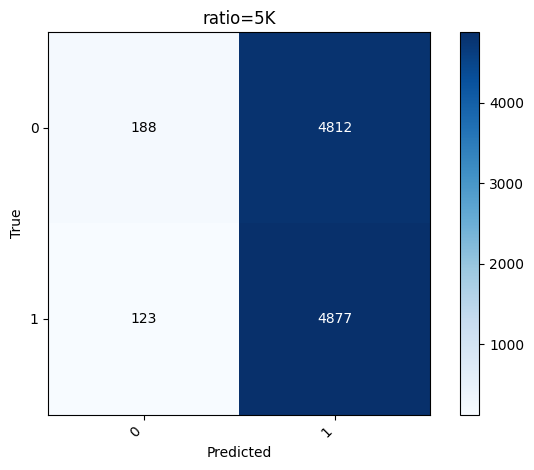

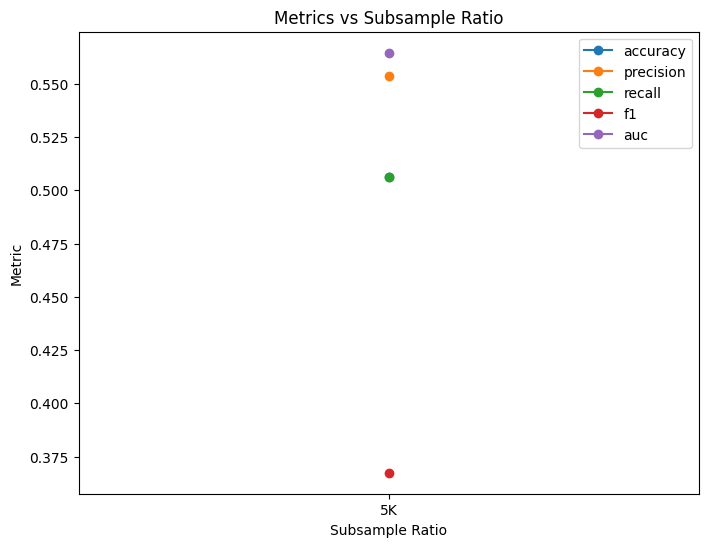

In [6]:
# Flights df with features that are known only PRE-DEPARTURE

# assume your flights DataFrame is called `flights_df`, with a 'label' column
results = run_t5_enc_experiment_sets(
    df=flights_df,
    label_col='label',
    task_def='Flights Delay Classification',
    test_size=0.0005,                    # hold out 20% of data for testing
    subsample_sets=['5K'],  # train‐set fractions to sweep
    val_ratio=0.3,                    # 20% of each subsample for validation
    model_name='t5-base',
    output_dir='./t5_higgs_t5_enc',    
    random_state=42,

    # training schedule
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1, #2,

    # optimizer & scheduler
    learning_rate=5e-4,#5e-4,
    weight_decay=0.01,
    optim='adamw_torch',
    lr_scheduler_type='linear',
    warmup_ratio=0.1,

    # precision & performance
    fp16=True,
    bf16=False,

    # LoRA
    use_lora=True,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.0, #0.1,

    # label smoothing
    #label_smoothing_factor=0.1,

    # evaluation & checkpointing
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy='steps',
    logging_steps=50,
    #save_strategy='steps',
    save_steps=None,
    save_total_limit=2,
    overwrite_output_dir=True,
    save_safetensors=False,
    load_best_model_at_end=False,
    metric_for_best_model='f1',
    greater_is_better=True,

    # early stopping
    early_stopping_patience=3,

    # prompt & tokenization
    max_length=220,
)

## T5 Fused Head Fine-tuning

### Ratios


=== Processing ratio 0.01 ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=180, max=195
DEBUG: Sample training prompt: task: flights_delay_classification | DAY: 26.0 ; AIRLINE: B6 ; FLIGHT_NUMBER: 2301.0 ; TAIL_NUMBER: N279JB ; ORIGIN_AIRPORT: BUF ; DESTINATION_AIRPORT: JFK ; DEPARTURE_TIME: 940.0 ; SCHEDULED_TIME: 83.0 ; DISTANCE: 301.0 ; WEATHER_DELAY: 0.0 ; month: 6.0 ; day_of_week: 5.0 ; sched_departure_hour: 9.0 ; sched_departure_minute: 45.0 ; sched_arrival_hour: 11.0 ; sched_arrival_minute: 8.0</s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 39977
DEBUG: Validation data size: 17134

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.7843
DEBUG: Pre-training logits: tensor([[0.3037, 0.3420],
        [0.1522, 0.3209]])
DEBUG: Pre-training predictions: tensor([1, 1])
DEBUG: Trainable parameters: 1,182,338 / 224,085,890 (0.5%)


/home/ubuntu/oron/nlp/t5_small_pipeline.py:588: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (17134, 2)
DEBUG: Sample logits: [[ 0.5589825  -0.07520375]
 [ 0.5535815  -0.06960473]
 [ 0.5547385  -0.06683563]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [17134]
DEBUG: True labels: [0 1 0 0 1 0 0 0 0 0]
DEBUG: True label distribution: [14065  3069]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (17134, 2)
DEBUG: Sample logits: [[ 0.5467446  -0.0401303 ]
 [ 0.53701186 -0.03134366]
 [ 0.5352441  -0.02781976]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [17134]
DEBUG: True labels: [0 1 0 0 1 0 0 0 0 0]
DEBUG: True label distribution: [14065  3069]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (17134, 2)
DEBUG: Sample logits: [[ 0.5215518  -0.02759508]
 [ 0.52061874 -0.02282216]
 [ 0.52077085 -0.01998396]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [17134]
DEBUG: True labels: [0 1 0 0 1 0 0 0 0 0]
DEBUG: True label distribution: [14065  3069]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (17134, 2)
DEBUG: Sample logits: [[ 0.5193947  -0.01874258]
 [ 0.5141322  -0.01737162]
 [ 0.5120719  -0.00876709]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [17134]
DEBUG: True labels: [0 1 0 0 1 0 0 0 0 0]
DEBUG: True label distribution: [14065  3069]


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (2858, 2)
DEBUG: Sample logits: [[ 0.54652894 -0.06793321]
 [ 0.56784326 -0.07178687]
 [ 0.55804825 -0.06816562]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [2858]
DEBUG: True labels: [0 0 0 0 1 0 0 1 1 0]
DEBUG: True label distribution: [2346  512]
DEBUG: Raw logits shape: (2858, 2)
DEBUG: Sample logits: [[ 0.54652894 -0.06793321]
 [ 0.56784326 -0.07178687]
 [ 0.55804825 -0.06816562]]
DEBUG: Predictions: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [2858]
DEBUG: True labels: [0 0 0 0 1 0 0 1 1 0]
DEBUG: True label distribution: [2346  512]
DEBUG: Final predictions for confusion matrix: [0 0 0 0 0 0 0 0 0 0]
DEBUG: Prediction distribution: [2858]
DEBUG: Final true labels for confusion matrix: [0 0 0 0 1 0 0 1 1 0]
DEBUG: True label distribution: [2346  512]


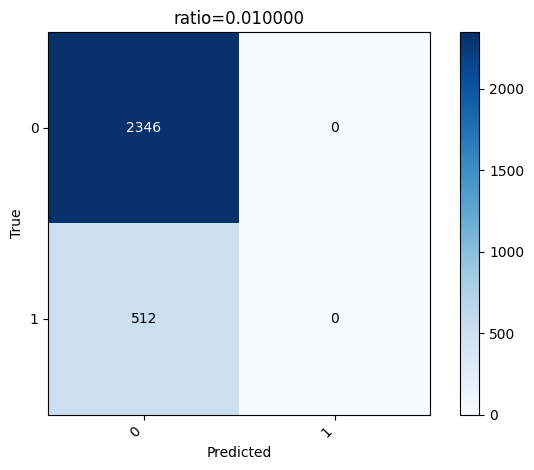

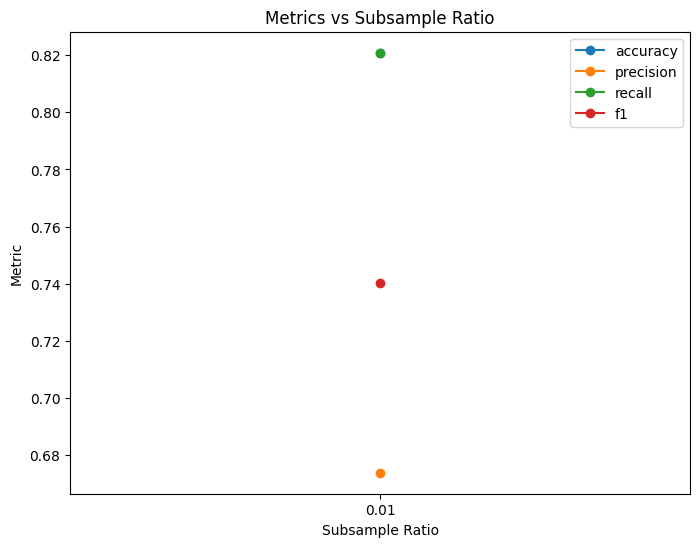

In [5]:
results = run_t5_experiment(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=df,                           # ■ full DataFrame of all examples
    label_col='label',                 # ■ name of the target column
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_ratios=[0.01],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=5e-5,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=True,
    bf16=False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.1,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=True,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)

### Static Sets


=== Processing ratio 5K ===
LoRA applied. Trainable parameters:
  Total: 224,085,890
  Trainable: 1,182,338 (0.5%)
DEBUG: token‐lengths in this batch → min=187, max=196
DEBUG: Sample training prompt: Flights Delay Classification | <unk> "DAY":1,"AIRLINE":"DL","FLIGHT_NUMBER":1969,"TAIL_NUMBER":"N958DL","ORIGIN_AIRPORT":"ABQ","DESTINATION_AIRPORT":"ATL","SCHEDULED_TIME":176.0,"DISTANCE":1269,"DIVERTED":0,"CANCELLED":0,"CANCELLATION_REASON":"Missing","month":1,"day_of_week":4,"scheduled_departure_hour":8,"scheduled_departure_minute":0,"scheduled_arrival_hour":12,"scheduled_arrival_minute":56<unk></s>
DEBUG: Sample training label: 0
DEBUG: Training data size: 5000
DEBUG: Validation data size: 10000

=== PRE-TRAINING DEBUG ===
DEBUG: Pre-training loss: 0.7013
DEBUG: Pre-training logits: tensor([[0.2677, 0.1836],
        [0.1857, 0.3003]])
DEBUG: Pre-training predictions: tensor([0, 1])
DEBUG: Trainable parameters: 1,182,338 / 224,085,890 (0.5%)


/home/ubuntu/oron/nlp/t5_fused_pipeline_sets.py:525: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/ubuntu/nlp_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Raw logits shape: (10000, 2)
DEBUG: Sample logits: [[0.18683346 0.22074436]
 [0.18771587 0.2190477 ]
 [0.18805839 0.21751729]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [    0 10000]
DEBUG: True labels: [0 1 0 0 0 1 1 0 0 1]
DEBUG: True label distribution: [5000 5000]
DEBUG: Raw logits shape: (10000, 2)
DEBUG: Sample logits: [[0.18683346 0.22074436]
 [0.18771587 0.2190477 ]
 [0.18805839 0.21751729]]
DEBUG: Predictions: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [    0 10000]
DEBUG: True labels: [0 1 0 0 0 1 1 0 0 1]
DEBUG: True label distribution: [5000 5000]
DEBUG: Final predictions for confusion matrix: [1 1 1 1 1 1 1 1 1 1]
DEBUG: Prediction distribution: [    0 10000]
DEBUG: Final true labels for confusion matrix: [0 1 0 0 0 1 1 0 0 1]
DEBUG: True label distribution: [5000 5000]


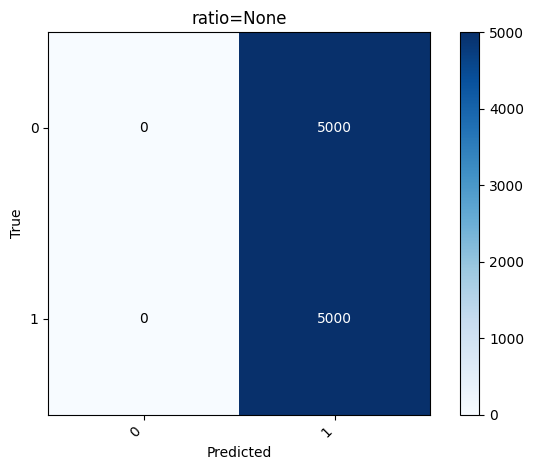

ValueError: x, y, and format string must not be None

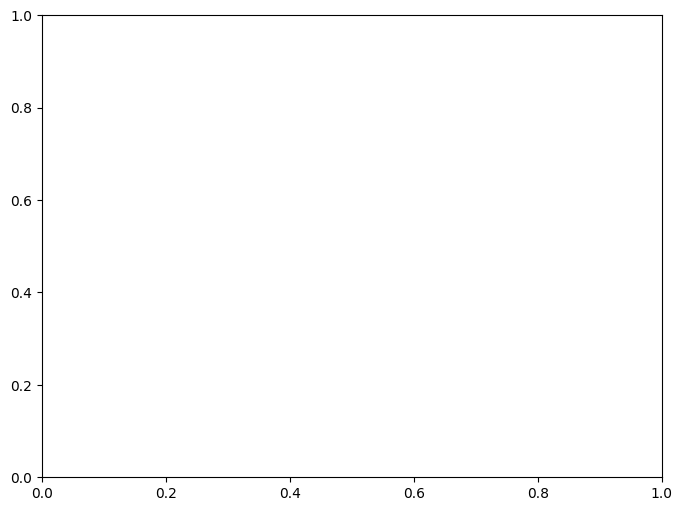

In [27]:
results = run_t5_fused_experiment_sets(
    # ─── Dataset & Splitting ─────────────────────────────────────
    df=flights_df,                           # ■ full DataFrame of all examples
    label_col='label',                 # ■ name of the target column
    task_def='Flights Delay Classification',
    test_size=0.0005,                            # ■ fraction for hold‑out test split (e.g. 0.2)
    subsample_sets=['5K'],                  # ■ list of train‐fraction experiments (e.g. [0.1,0.5,1.0])
    val_ratio=0.3,                              # ■ fraction of (subsampled) train set held for validation

    # ─── Model & IO ─────────────────────────────────────────────
    model_name='t5-base',                       # ■ HuggingFace model ID (e.g. "t5-base")
    output_dir='./t5_results',                  # ■ base directory for checkpoints & logs
    max_length=320,
    random_state=42,                            # ■ global seed for splits, RNG (typical: 42)

    # ─── Training Schedule ──────────────────────────────────────
    num_train_epochs=8,#6, #4,                         # ■ total epochs per run (typical: 3–5)
    per_device_train_batch_size=32, #16, #8,              # ■ batch size per GPU/CPU (tune for memory)
    per_device_eval_batch_size=16, #8,                  # ■ batch size for evaluation (often ≥ train bs)
    gradient_accumulation_steps=1, #2,              # ■ accumulate gradients to simulate larger bs

    # ─── Optimization Hyperparameters ───────────────────────────
    learning_rate=4e-5,#5e-3,#5e-5,#5e-4,                         # ■ initial LR (e.g. 5e‑5); critical to tune
    weight_decay=0.01,                          # ■ L2 decay (default 0.01 is common)
    adam_beta1=0.9,                             # ■ Adam β1 (default 0.9 standard)
    adam_beta2=0.999,                           # ■ Adam β2 (default 0.999 standard)
    adam_epsilon=1e-8,                          # ■ Adam ε (default 1e‑8 standard)
    optim="adamw_torch",                        # ■ optimizer choice

    # ─── Scheduler & Warmup ─────────────────────────────────────
    lr_scheduler_type='linear', #"cosine",                 # ■ scheduler ("linear","cosine", …)
    warmup_steps=100,                             # ■ steps to warm up LR at start

    # ─── Precision & Performance ─────────────────────────────────
    # fp16=torch.cuda.is_available(),           # ■ use FP16 if GPU available
    fp16=True,
    bf16=False,                                 # ■ use BF16 (overrides fp16)
    #gradient_checkpointing = False,      # ■ trade compute for memory

    # ─── Data Loading ────────────────────────────────────────────
    dataloader_num_workers=8,#4,                   # ■ parallel data loaders (default 4)
    max_grad_norm=1.0,                          # ■ clip gradients to this norm (1.0 common)

    # ─── LoRA Fine‑Tuning ────────────────────────────────────────
    use_lora=True,                              # ■ whether to apply LoRA adapters
    lora_r=8,                                   # ■ LoRA rank (small ≲ 8)
    lora_alpha=32,                              # ■ LoRA scaling factor
    lora_dropout=0.1,                           # ■ dropout in LoRA adapters

    # ─── Regularization & Label Smoothing ───────────────────────
    label_smoothing_factor=0.0,                 # ■ softens targets (0.1 often helps minority)

    # ─── Evaluation & Checkpointing ─────────────────────────────
    eval_strategy="steps",                      # ■ when to eval: "no"|"steps"|"epoch"
    eval_steps=200,                             # ■ how often (in steps) to run eval
    logging_steps=50,
    save_strategy="no",                      # ■ checkpointing: "no"|"steps"|"epoch"
    save_steps=None,                            # ■ if None, defaults to `eval_steps`
    save_total_limit=2,                         # ■ max number of checkpoints to keep
    overwrite_output_dir=True,                  # ■ overwrite existing output without error
    save_safetensors=False,                     # ■ if True, use safetensors (disabled for T5)

    load_best_model_at_end=False,                # ■ reload best checkpoint after training
    metric_for_best_model="f1",                 # ■ metric name used to compare checkpoints
    greater_is_better=True,                     # ■ whether higher metric value is better

    # ─── Early‑Stopping ──────────────────────────────────────────
    early_stopping_patience=3,                  # ■ stop after N evals without improvement
)